# import data

In [1]:
pip install databento

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 312.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations

import re
from datetime import datetime, timedelta, time as dtime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import databento as db


# ===== CONFIG =====
API_KEY = "db-iKVuPA7sBdWpefhWQyHPkrSjJpLgH"
client = db.Historical(API_KEY)

# Parent symbol -> expands to all ES contracts
PARENT = "NQ.FUT"

# Month code mapping & symbol regex (e.g., ESZ4, ESH25)
MONTH_MAP = {'F':1,'G':2,'H':3,'J':4,'K':5,'M':6,'N':7,'Q':8,'U':9,'V':10,'X':11,'Z':12}
SYM_RE = re.compile(r"^([A-Z]{1,3})([FGHJKMNQUVXZ])(\d{1,2})$")  # root + month + 1–2 digit year


def _resolve_year(two_digit: int, ref_year: int) -> int:
    """
    Map a 1–2 digit year code to a full year close to the reference year (tracking day).
    """
    candidates = [2000 + two_digit, 2010 + two_digit, 2020 + two_digit, 2030 + two_digit]
    return min(candidates, key=lambda Y: (abs(Y - ref_year), Y))


def _parse_expiry(symbol: str, ref_year: int) -> tuple[int, int]:
    """
    Return (YYYY, MM) for a futures symbol like ESZ4 / ESZ24.
    """
    m = SYM_RE.match(symbol)
    if not m:
        return (9999, 12)  # push unknowns to the back
    _, mon_code, yy = m.groups()
    mm = MONTH_MAP[mon_code]
    y = int(yy)
    yyyy = _resolve_year(y, ref_year)
    return (yyyy, mm)


def _build_bar_ends(start_dt, end_dt, freq="15min"):
    """
    Build bar-end timestamps from RTH open to RTH close inclusive, in America/Chicago time.
    Bars are shifted by +3 minutes relative to the regular grid.
    First bar ends at start_dt + 3 minutes (e.g. 08:33 CT), then every `freq` thereafter.
    Last bar is clipped so it does not exceed end_dt (15:00 CT).
    """
    start_dt = pd.Timestamp(start_dt)
    end_dt   = pd.Timestamp(end_dt)

    # Build grid: start at RTH open + 3min, then every `freq`
    first = start_dt + pd.Timedelta("3min")
    grid = pd.date_range(first, end_dt + pd.Timedelta(freq), freq=freq)

    # Clip any value that overshoots the session close (e.g., 15:03 -> 15:00)
    grid = grid.where(grid <= end_dt, end_dt)

    # Drop duplicates if last two collapse at 15:00
    grid = grid.drop_duplicates()

    return grid



def download_us_rth_day(tracking_day: str,
                        freq: str = "15min",
                        output_csv: str | None = None) -> pd.DataFrame:
    """
    Download TBBO + trades for ES during **US Regular Trading Hours** (09:30–16:00 ET),
    compute:
      - Bid/Ask at each bar end (last known TBBO)
      - VWAP since RTH open (cumulative from 09:30 ET) at each bar end
    Keep only ONE contract at each timestamp: the front month (nearest expiry).
    Save to CSV if output_csv is provided. Return the final DataFrame.
    """
    chi = ZoneInfo("America/Chicago")
    nyc = ZoneInfo("America/New_York")

    # Tracking day in CT (we anchor on the local date)
    day_ct = datetime.fromisoformat(tracking_day).replace(tzinfo=chi)

    # US RTH window: 09:30–16:00 ET == 08:30–15:00 CT for the same civil day
    rth_open_ct  = day_ct.replace(hour=8, minute=30, second=0, microsecond=0)
    rth_close_ct = day_ct.replace(hour=15, minute=0, second=0, microsecond=0)

    # Bar ends grid in CT, within RTH only
    bar_ends = _build_bar_ends(rth_open_ct, rth_close_ct, freq=freq)

    # === Download raw data (expand parent to all active ES contracts) within RTH window ===
    quotes = client.timeseries.get_range(
        dataset="GLBX.MDP3",
        schema="tbbo",
        symbols=[PARENT],
        stype_in="parent",
        start=rth_open_ct.isoformat(),
        end=rth_close_ct.isoformat(),
    ).to_df()

    trades = client.timeseries.get_range(
        dataset="GLBX.MDP3",
        schema="trades",
        symbols=[PARENT],
        stype_in="parent",
        start=rth_open_ct.isoformat(),
        end=rth_close_ct.isoformat(),
    ).to_df()

    if quotes.empty and trades.empty:
        raise RuntimeError("No data returned for the requested RTH window.")

    # === Keep only outright futures, drop inter-month spreads ===
    mask_q = quotes["symbol"].astype(str).str.match(SYM_RE)
    quotes = quotes[mask_q].copy()
    if not trades.empty:
        mask_t = trades["symbol"].astype(str).str.match(SYM_RE)
        trades = trades[mask_t].copy()

    # === Normalize timestamps to America/Chicago ===
    quotes["Time"] = pd.to_datetime(quotes["ts_event"], utc=True).dt.tz_convert(chi)
    if not trades.empty:
        trades["Time"] = pd.to_datetime(trades["ts_event"], utc=True).dt.tz_convert(chi)

    # === Prepare TBBO at bar ends: last known before or at each bar end (per symbol) ===
    def resample_tbbo_per_symbol(df_sym: pd.DataFrame) -> pd.DataFrame:
        q = (
            df_sym.loc[:, ["Time", "bid_px_00", "ask_px_00"]]
            .sort_values("Time")
            .drop_duplicates("Time", keep="last")
        )
        target = pd.DataFrame({"Time": bar_ends})
        out = pd.merge_asof(
            target, q, on="Time", direction="backward", allow_exact_matches=True
        )
        out["symbol"] = df_sym["symbol"].iloc[0]
        return out

    tbbo = (
        quotes.sort_values(["symbol", "Time"])
              .groupby("symbol", group_keys=False)
              .apply(resample_tbbo_per_symbol)
    )

    # === VWAP since RTH open: cumulative only within the RTH window (per symbol) ===
    if trades.empty:
        vwap_bars = tbbo.loc[:, ["Time", "symbol"]].copy()
        vwap_bars["vwap_cum"] = np.nan
    else:
        tr = trades.loc[:, ["symbol", "Time", "price", "size"]].copy()
        tr = tr.sort_values(["symbol", "Time"])
        tr["notional"] = tr["price"] * tr["size"]
        # start cumulation at RTH open by filtering to the RTH window only
        tr = tr[(tr["Time"] >= rth_open_ct) & (tr["Time"] <= rth_close_ct)]
        tr["cum_notional"] = tr.groupby("symbol")["notional"].cumsum()
        tr["cum_volume"]   = tr.groupby("symbol")["size"].cumsum()
        tr = tr.loc[:, ["symbol", "Time", "cum_notional", "cum_volume"]]

        def vwap_per_symbol(df_sym: pd.DataFrame) -> pd.DataFrame:
            s = df_sym.loc[:, ["Time", "cum_notional", "cum_volume"]].drop_duplicates("Time")
            s = s.sort_values("Time")
            target = pd.DataFrame({"Time": bar_ends})
            out = pd.merge_asof(
                target, s, on="Time", direction="backward", allow_exact_matches=True
            )
            out["symbol"] = df_sym["symbol"].iloc[0]
            out["vwap_cum"] = out["cum_notional"] / out["cum_volume"]
            return out.loc[:, ["Time", "symbol", "vwap_cum"]]

        vwap_bars = tr.groupby("symbol", group_keys=False).apply(vwap_per_symbol)

    # === Merge TBBO and VWAP on (Time, symbol) ===
    bars = pd.merge(tbbo, vwap_bars, on=["Time", "symbol"], how="left")

    # === Determine front month (nearest expiry) per timestamp and keep only that ===
    ref_year = day_ct.year
    exp_ym = bars["symbol"].astype(str).map(lambda s: _parse_expiry(s, ref_year))
    bars["exp_year"]  = [ym[0] for ym in exp_ym]
    bars["exp_month"] = [ym[1] for ym in exp_ym]
    bars["expiry_key"] = bars["exp_year"] * 12 + bars["exp_month"]



    # IMPORTANT: columns indexer must be a LIST (not a tuple)
    out = bars.loc[:, ["Time", "symbol", "bid_px_00", "ask_px_00", "vwap_cum", "exp_year", "exp_month", "expiry_key"]].sort_values("Time")



    # Forward-fill VWAP after first valid trade within the day
    # (initial NaNs—before first trade—are left as NaN)
    first_valid = out["vwap_cum"].first_valid_index()
    if first_valid is not None:
        out.loc[first_valid:, "vwap_cum"] = out.loc[first_valid:, "vwap_cum"].ffill()

    if output_csv:
        out.to_csv(output_csv, index=False)

    return out

In [3]:
# ===== Example usage =====
df = download_us_rth_day("2010-06-07", freq="15min", output_csv="/data/workspace_files/2010-06-07_nasdaq.csv")
display(df.head())

/tmp/ipykernel_207/291650387.py:145: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(resample_tbbo_per_symbol)
/tmp/ipykernel_207/291650387.py:173: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwap_bars = tr.groupby("symbol", group_keys=False).apply(vwap_per_symbol)


Time 
 symbol 
 bid_px_00 
 ask_px_00 
 vwap_cum 
 exp_year 
 exp_month 
 expiry_key 
 
 
 
 
 0 
 2010-06-07 08:33:00-05:00 
 NQM0 
 1843.75 
 1844.00 
 1841.514008 
 2010 
 6 
 24126 
 
 
 27 
 2010-06-07 08:33:00-05:00 
 NQU0 
 1840.25 
 1841.00 
 1839.253086 
 2010 
 9 
 24129 
 
 
 1 
 2010-06-07 08:48:00-05:00 
 NQM0 
 1830.50 
 1830.75 
 1835.539750 
 2010 
 6 
 24126 
 
 
 28 
 2010-06-07 08:48:00-05:00 
 NQU0 
 1828.00 
 1828.25 
 1833.995536 
 2010 
 9 
 24129 
 
 
 2 
 2010-06-07 09:03:00-05:00 
 NQM0 
 1839.25 
 1839.50 
 1836.565266 
 2010 
 6 
 24126

In [4]:
from time import sleep
import pandas as pd
from pathlib import Path

def run_range(download_fn, start="2010-06-06", end="2010-06-10",
              business_days=True, pause_sec=0.0):
    # Choose trading days: Mon–Fri (business) or every calendar day
    rng = (pd.bdate_range if business_days else pd.date_range)(
        start=start, end=end, freq="D"
    )
    failures = []
    total = len(rng)

    for i, d in enumerate(rng, 1):
        td = d.date().isoformat()
        try:
            print(f"[{i}/{total}] {td} ... ", end="", flush=True)
            download_fn(td)
            print("done")
        except Exception as e:
            print("FAILED")
            failures.append((td, str(e)))
        if pause_sec:
            sleep(pause_sec)

    print(f"\nFinished: {total - len(failures)} ok, {len(failures)} failed.")
    if failures:
        print("Sample failures (up to 10):")
        for td, msg in failures[:10]:
            print(f"  {td}: {msg}")

# === Example run ===
outdir = Path("/data/workspace_files/nasdaq")
outdir.mkdir(parents=True, exist_ok=True)

# If your function is named download_us_rth_day (per the latest code), use that:
run_range(
    lambda d: download_us_rth_day(d, freq="15min",
                                  output_csv=str(outdir / f"{d}.csv")),
    start="2014-01-01",
    end="2025-01-01",
    business_days=True,
    pause_sec=0.0,
)

# You should now see files like:
# /data/workspace_files/2010-06-07_RTH.csv
# /data/workspace_files/2010-06-08_RTH.csv

[1/4019] 2014-01-01 ... FAILED
[2/4019] 2014-01-02 ... done
[3/4019] 2014-01-03 ... done
[4/4019] 2014-01-04 ... FAILED
[5/4019] 2014-01-05 ... FAILED
[6/4019] 2014-01-06 ... done
[7/4019] 2014-01-07 ... done
[8/4019] 2014-01-08 ... done
[9/4019] 2014-01-09 ... done
[10/4019] 2014-01-10 ... done
[11/4019] 2014-01-11 ... FAILED
[12/4019] 2014-01-12 ... FAILED
[13/4019] 2014-01-13 ... done
[14/4019] 2014-01-14 ... done
[15/4019] 2014-01-15 ... done
[16/4019] 2014-01-16 ... done
[17/4019] 2014-01-17 ... done
[18/4019] 2014-01-18 ... FAILED
[19/4019] 2014-01-19 ... FAILED
[20/4019] 2014-01-20 ... FAILED
[21/4019] 2014-01-21 ... done
[22/4019] 2014-01-22 ... done
[23/4019] 2014-01-23 ... done
[24/4019] 2014-01-24 ... done
[25/4019] 2014-01-25 ... FAILED
[26/4019] 2014-01-26 ... FAILED
[27/4019] 2014-01-27 ... done
[28/4019] 2014-01-28 ... done
[29/4019] 2014-01-29 ... done
[30/4019] 2014-01-30 ... done
[31/4019] 2014-01-31 ... done
[32/4019] 2014-02-01 ... FAILED
[33/4019] 2014-02-02 ... FA

  vwap_bars = tr.groupby("symbol", group_keys=False).apply(vwap_per_symbol)
/tmp/ipykernel_207/291650387.py:145: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(resample_tbbo_per_symbol)
/tmp/ipykernel_207/291650387.py:173: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwap_bars = tr.groupby("symbol", group_keys=False).apply(vwap_per_symbol)
/tmp/ipykernel_207/291650387.py:95: BentoWarning: No data fou

# Merge data together

In [2]:
from pathlib import Path
import re
import numpy as np
import pandas as pd

DATE_RE = re.compile(r"(\d{4}-\d{2}-\d{2})\.csv$")

def load_daily_folder(
    folder: str | Path,
    start: str | None = None,
    end: str | None = None
) -> pd.DataFrame:

    folder = Path(folder)
    files = []
    for fp in sorted(folder.glob("*.csv")):
        m = DATE_RE.search(fp.name)
        if not m:
            continue
        day = m.group(1)
        if start and day < start:
            continue
        if end and day >= end:
            continue
        files.append((day, fp))

    if not files:
        raise FileNotFoundError("No matching CSV files found in the given range.")

    dfs = []
    for day, fp in files:
        print(fp)
        df = pd.read_csv(fp, low_memory=False)

        # --- TEMP datetime in ET for calculations; DO NOT modify df['Time'] ---
        t = pd.to_datetime(df["Time"], errors="coerce")
        # if naive, treat as Chicago local; if tz-aware, keep and convert
        if getattr(t.dtype, "tz", None) is None:
            t = t.dt.tz_localize("America/Chicago")
        time_et_tmp = t.dt.tz_convert("America/New_York")

        ### we compute the time until expiry to rank the contracts
        mmap = {'F':1,'G':2,'H':3,'J':4,'K':5,'M':6,'N':7,'Q':8,'U':9,'V':10,'X':11,'Z':12}
        m = df['symbol'].astype(str).str.extract(r'([FGHJKMNQUVXZ])(\d{1,2})$')
        df['exp_month'] = m[0].map(mmap).astype('Int64')
        y = pd.to_numeric(m[1], errors='coerce')
        df['exp_year']  = np.where(y < 10, 2020 + y, 2000 + y)   # 4→2024, 24→2024

        base = pd.to_datetime(
            df['exp_year'].astype(int, errors='ignore').astype(str) + 
            df['exp_month'].astype(int, errors='ignore').astype(str).str.zfill(2),
            format='%Y%m',
            errors='coerce'
        )
        third_fri = base + pd.offsets.WeekOfMonth(week=2, weekday=4)  # 3rd Friday
        df['expiry_dt_et'] = third_fri.dt.tz_localize('America/New_York') + pd.Timedelta(hours=9, minutes=30)

        # Use temporary ET time for subtraction; df['Time'] is unchanged
        df['time_to_expiry'] = df['expiry_dt_et'] - time_et_tmp
        df['days_to_expiry'] = df['time_to_expiry'].dt.total_seconds() / 86400

        df['expiry_order'] = df.groupby('Time')['expiry_dt_et'].rank(method='dense').astype(int)

        dfs.append(df)

    out = pd.concat(dfs, ignore_index=False, sort=False)
    return out


final_df = load_daily_folder(
    folder="/data/workspace_files/nasdaq",
    start="2010-06-06",
    end="2025-01-01",
)

print(final_df.shape)

# keeping only the useful columns
final_df = final_df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

final_df.to_csv('/data/workspace_files/nasdaq.csv', index=False)
final_df

/data/workspace_files/nasdaq/2010-06-07.csv
/data/workspace_files/nasdaq/2010-06-08.csv
/data/workspace_files/nasdaq/2010-06-09.csv
/data/workspace_files/nasdaq/2010-06-10.csv
/data/workspace_files/nasdaq/2010-06-11.csv
/data/workspace_files/nasdaq/2010-06-14.csv
/data/workspace_files/nasdaq/2010-06-15.csv
/data/workspace_files/nasdaq/2010-06-16.csv
/data/workspace_files/nasdaq/2010-06-17.csv
/data/workspace_files/nasdaq/2010-06-18.csv
/data/workspace_files/nasdaq/2010-06-21.csv
/data/workspace_files/nasdaq/2010-06-22.csv
/data/workspace_files/nasdaq/2010-06-23.csv
/data/workspace_files/nasdaq/2010-06-24.csv
/data/workspace_files/nasdaq/2010-06-25.csv
/data/workspace_files/nasdaq/2010-06-28.csv
/data/workspace_files/nasdaq/2010-06-29.csv
/data/workspace_files/nasdaq/2010-06-30.csv
/data/workspace_files/nasdaq/2010-07-01.csv
/data/workspace_files/nasdaq/2010-07-02.csv
/data/workspace_files/nasdaq/2010-07-05.csv
/data/workspace_files/nasdaq/2010-07-06.csv
/data/workspace_files/nasdaq/201

/tmp/ipykernel_3391/2762008146.py:55: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  third_fri = base + pd.offsets.WeekOfMonth(week=2, weekday=4)  # 3rd Friday
/tmp/ipykernel_3391/2762008146.py:55: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  third_fri = base + pd.offsets.WeekOfMonth(week=2, weekday=4)  # 3rd Friday
/tmp/ipykernel_3391/2762008146.py:55: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  third_fri = base + pd.offsets.WeekOfMonth(week=2, weekday=4)  # 3rd Friday
/tmp/ipykernel_3391/2762008146.py:55: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  third_fri = base + pd.offsets.WeekOfMonth(week=2, weekday=4)  # 3rd Friday
/tmp/ipykernel_3391/2762008146.py:55: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  third_fri = base + pd.offsets.WeekOfMonth(week=2, weekday=4)

Time 
 symbol 
 expiry_order 
 bid_px_00 
 ask_px_00 
 vwap_cum 
 
 
 
 
 0 
 2010-06-07 08:33:00-05:00 
 NQM0 
 1 
 1843.75 
 1844.00 
 1841.514008 
 
 
 1 
 2010-06-07 08:33:00-05:00 
 NQU0 
 2 
 1840.25 
 1841.00 
 1839.253086 
 
 
 2 
 2010-06-07 08:48:00-05:00 
 NQM0 
 1 
 1830.50 
 1830.75 
 1835.539750 
 
 
 3 
 2010-06-07 08:48:00-05:00 
 NQU0 
 2 
 1828.00 
 1828.25 
 1833.995536 
 
 
 4 
 2010-06-07 09:03:00-05:00 
 NQM0 
 1 
 1839.25 
 1839.50 
 1836.565266 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 49 
 2024-12-31 14:33:00-06:00 
 NQH5 
 1 
 21289.75 
 21290.50 
 21321.197330 
 
 
 50 
 2024-12-31 14:48:00-06:00 
 NQM5 
 2 
 21501.25 
 21504.25 
 21563.041818 
 
 
 51 
 2024-12-31 14:48:00-06:00 
 NQH5 
 1 
 21271.50 
 21272.00 
 21319.046374 
 
 
 52 
 2024-12-31 15:00:00-06:00 
 NQH5 
 1 
 21220.25 
 21220.75 
 21311.938467 
 
 
 53 
 2024-12-31 15:00:00-06:00 
 NQM5 
 2 
 21456.50 
 21462.00 
 21549.936120 
 
 
 
 267705 rows × 6 columns

# Strat 1

In [3]:
### Stop opposite band + fix bet size

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
import datetime as dt
import matplotlib.dates as mdates

In [5]:
### import the data
df = pd.read_csv('/data/workspace_files/nasdaq.csv')
df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

# (Optional) drop bad rows
df = df.dropna(subset=['Time'])

# Convert UTC -> New York (handles DST)
df['Time'] = df['Time'].dt.tz_convert('America/New_York')

# Build hour/day AFTER conversion
df['hour'] = df['Time'].dt.strftime('%H:%M')
df['day']  = df['Time'].dt.date

# Keep only US RTH 09:30–16:00 ET
market_open, market_close = dt.time(9, 30), dt.time(16, 0)
df = df[df['Time'].dt.time.between(market_open, market_close)]

# Sanity check (optional)
tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()


### order by symbol, hour and day
df = df.sort_values(['symbol', 'hour', 'day'])

### price
df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


### opening price
df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


# settling price and previous day settling price
daily_settle = (
    df.sort_values(['symbol','day','Time'])
      .groupby(['symbol','day'])['price']
      .last()
      .rename('settl_price')
)

prev_settle = (
    daily_settle.groupby(level='symbol')
                .shift(1)
                .rename('settl_price_previous')
)

df = df.join(daily_settle, on=['symbol','day'])
df = df.join(prev_settle,   on=['symbol','day'])


### move since opening
df["move"] = np.where(
    df["open_price"] > 0,
    np.abs(df["price"] / df["open_price"] - 1),
    np.nan
)


### compute mean of move over the last period
n = 14
df['sigma_observed'] = (
    df.groupby(['symbol', 'hour'])['move']
      .transform(lambda x: x.rolling(n, min_periods=n).mean())
)


### compute upper bound
df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + df['sigma_observed'])


### compute lower bound
df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - df['sigma_observed'])


### get return
df['return'] = df['settl_price']/df['open_price'] - 1


### get variance onf returns among the last 14 days
daily = (df.sort_values(['symbol','day'])
           .groupby(['symbol','day'], as_index=False)['return'].last())

daily['ret_std_14d'] = (
    daily.groupby('symbol')['return']
         .transform(lambda s: s.rolling(14, min_periods=14).std())
)

df = df.merge(daily[['symbol','day','ret_std_14d']], on=['symbol','day'], how='left')


df = df.sort_values(['symbol', 'day', 'hour'])
df[df['expiry_order']==1]

Time 
 symbol 
 expiry_order 
 bid_px_00 
 ask_px_00 
 vwap_cum 
 hour 
 day 
 price 
 open_price 
 settl_price 
 settl_price_previous 
 move 
 sigma_observed 
 upper_bound 
 lower_bound 
 return 
 ret_std_14d 
 
 
 
 
 0 
 2019-03-15 09:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 NaN 
 09:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 188 
 2019-03-15 09:48:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7303.251423 
 09:48 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 376 
 2019-03-15 10:03:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:03 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 564 
 2019-03-15 10:18:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:18 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 752 
 2019-03-15 10:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7314.065510 
 10:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 261856 
 2018-12-20 15:03:00-05:00 
 NQZ8 
 1 
 6248.00 
 6250.50 
 6284.578275 
 15:03 
 2018-12-20 
 6249.250 
 6336.125 
 6247.0 
 6342.0 
 0.013711 
 0.012701 
 6422.550370 
 6255.649249 
 -0.014066 
 0.01603 
 
 
 262049 
 2018-12-20 15:18:00-05:00 
 NQZ8 
 1 
 6273.25 
 6274.50 
 6283.674965 
 15:18 
 2018-12-20 
 6273.875 
 6336.125 
 6247.0 
 6342.0 
 0.009825 
 0.011280 
 6413.537885 
 6264.653385 
 -0.014066 
 0.01603 
 
 
 262242 
 2018-12-20 15:33:00-05:00 
 NQZ8 
 1 
 6270.50 
 6273.00 
 6283.447989 
 15:33 
 2018-12-20 
 6271.750 
 6336.125 
 6247.0 
 6342.0 
 0.010160 
 0.012874 
 6423.646645 
 6254.553989 
 -0.014066 
 0.01603 
 
 
 262435 
 2018-12-20 15:48:00-05:00 
 NQZ8 
 1 
 6242.25 
 6242.75 
 6282.792038 
 15:48 
 2018-12-20 
 6242.500 
 6336.125 
 6247.0 
 6342.0 
 0.014776 
 0.014118 
 6431.535710 
 6246.672233 
 -0.014066 
 0.01603 
 
 
 262628 
 2018-12-20 16:00:00-05:00 
 NQZ8 
 1 
 6246.25 
 6247.75 
 6279.934103 
 16:00 
 2018-12-20 
 6247.000 
 6336.125 
 6247.0 
 6342.0 
 0.014066 
 0.014080 
 6431.294203 
 6246.913516 
 -0.014066 
 0.01603 
 
 
 
 101061 rows × 18 columns

# Running strat one day

In [6]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
            .sort_values('Time')
            .copy())
    backtest_df = backtest_df.sort_values('hour')

    bid_list = backtest_df['bid_px_00'].values
    ask_list = backtest_df['ask_px_00'].values
    upper_bound = backtest_df['upper_bound'].values
    lower_bound = backtest_df['lower_bound'].values
    vwap_list = backtest_df['vwap_cum'].values
    hour = backtest_df['hour'].values

    if not (len(bid_list) == len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound)):
        return initial_cash
    elif any(pd.isna(x) for x in bid_list + ask_list + vwap_list + upper_bound + lower_bound):
        return initial_cash
    

        
    position = 0
    sigma_target = 0.02
    total_shares_to_hold = math.floor(initial_cash / backtest_df['open_price'].values[0])


    

    for i in range(1, len(bid_list) - 1):
        if ask_list[i] > max(upper_bound[i], vwap_list[i]):
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * ask_list[i]
                print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        elif bid_list[i] < min(vwap_list[i], lower_bound[i]):
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * bid_list[i]
                print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        # elif bid_list[i] >= min(vwap_list[i], lower_bound[i]) and max(upper_bound[i], vwap_list[i]) >= ask_list[i]:
        #     # we must close our position
        #     if position > 0: # we are long so we need to sell
        #         initial_cash += position * bid_list[i]
        #         # print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
        #         position = 0
        #     elif position < 0: # we are short so we need to buy
        #         initial_cash -= abs(position) * ask_list[i]
        #         # print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
        #         position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * bid_list[-1]
        print(f"Sold {position} shares at {ask_list[-1]} on {day_str} at {hour[-1]}")
        position = 0

    elif position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * ask_list[-1]
        print(f"Bought {abs(position)} shares at {bid_list[-1]} on {day_str} at {hour[-1]}")
        position = 0

    return initial_cash

backtest_one_day(df, "2010-10-13", 1, 100000)

Bought 48 shares at 2057.75 on 2010-10-13 at 11:03
Sold 48 shares at 2055.75 on 2010-10-13 at 16:00


99892.0

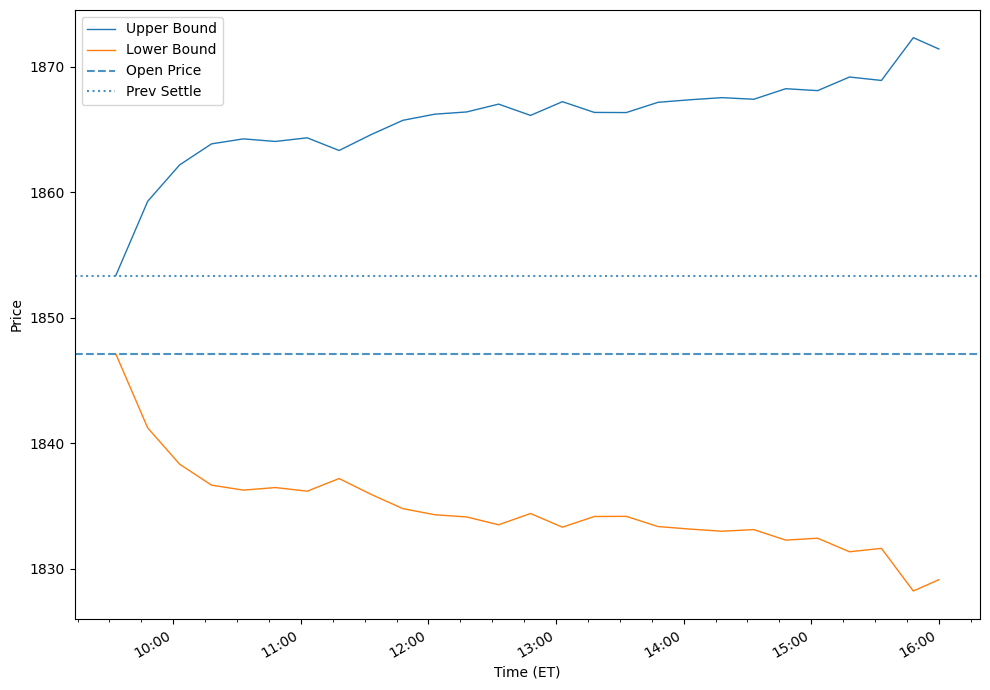

In [7]:
# Ensure Time is tz-aware ET
df["Time"] = pd.to_datetime(df["Time"], utc=True).dt.tz_convert("America/New_York")

# Define day as plain date (no tz needed)
day_str = "2010-07-16"
day = pd.to_datetime(day_str).date()

# Recompute day column in ET if not already done
df["day"] = df["Time"].dt.date

# Filter front-month contract for that day
one = df[(df['expiry_order'] == 1) & (df['day'] == day)].copy()
one = one.sort_values('Time')

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
x = one['Time']

# ax.plot(x, one['price'], label='Mid Price')
if 'upper_bound' in one and one['upper_bound'].notna().any():
    ax.plot(x, one['upper_bound'], label='Upper Bound', linewidth=1)
if 'lower_bound' in one and one['lower_bound'].notna().any():
    ax.plot(x, one['lower_bound'], label='Lower Bound', linewidth=1)

if 'open_price' in one and one['open_price'].notna().any():
    ax.axhline(one['open_price'].iloc[0], linestyle='--', alpha=0.8, label='Open Price')
if 'settl_price_previous' in one and one['settl_price_previous'].notna().any():
    ax.axhline(one['settl_price_previous'].iloc[0], linestyle=':', alpha=0.8, label='Prev Settle')

# if 'vwap_cum' in one.columns and one['vwap_cum'].notna().any():
#     ax.plot(x, one['vwap_cum'], label='VWAP (cum)', linewidth=1)

# Tidy x-axis
import matplotlib.dates as mdates
from zoneinfo import ZoneInfo


tz = ZoneInfo("America/New_York")

ax.xaxis.set_major_locator(mdates.HourLocator(tz=tz))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45], tz=tz))

fig.autofmt_xdate()

ax.set_xlabel("Time (ET)")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
backtest_one_day(df, "2010-07-16", 1, 100000)

Sold 54 shares at 1836.0 on 2010-07-16 at 09:48
Bought 54 shares at 1801.75 on 2010-07-16 at 16:00


101822.5

Bought 24 shares at 4213.75 on 2015-10-02 at 13:18
Sold 24 shares at 4256.75 on 2015-10-02 at 16:00
101026.0


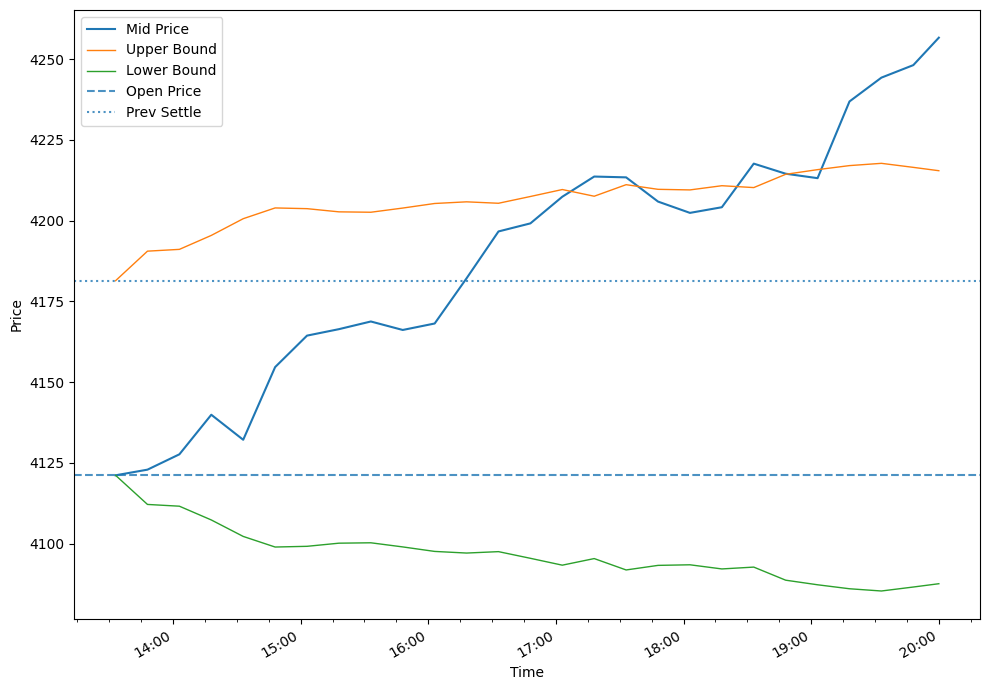

In [9]:
day_str = "2015-10-02"
day = pd.to_datetime(day_str).date()

print(backtest_one_day(df, day_str, 1, 100000))
one = df[(df['expiry_order'] == 1) & (df['day'] == day)].copy()
one = one.sort_values('Time')

fig, ax = plt.subplots(figsize=(10, 7))

x = one['Time']

ax.plot(x, one['price'], label='Mid Price')
if 'upper_bound' in one and one['upper_bound'].notna().any():
    ax.plot(x, one['upper_bound'], label='Upper Bound', linewidth=1)
if 'lower_bound' in one and one['lower_bound'].notna().any():
    ax.plot(x, one['lower_bound'], label='Lower Bound', linewidth=1)

# Horizontal lines for open and previous settlement
if 'open_price' in one and one['open_price'].notna().any():
    ax.axhline(one['open_price'].iloc[0], linestyle='--', alpha=0.8, label='Open Price')
if 'settl_price_previous' in one and one['settl_price_previous'].notna().any():
    ax.axhline(one['settl_price_previous'].iloc[0], linestyle=':', alpha=0.8, label='Prev Settle')

# Optional: VWAP
# if 'vwap_cum' in one.columns and one['vwap_cum'].notna().any():
#     ax.plot(x, one['vwap_cum'], label='VWAP (cum)', linewidth=1)

# Tidy x-axis: show one tick per hour, minor ticks at 15-min
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45]))
fig.autofmt_xdate()
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()

# Bactests on all day since 2011

In [10]:
def backtest(backtest_df, rank_to_expiry, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        print(day_ts)
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

In [11]:
results = backtest(df, 1)
results

2010-06-07 00:00:00-04:00
2010-06-08 00:00:00-04:00
2010-06-09 00:00:00-04:00
2010-06-10 00:00:00-04:00
2010-06-11 00:00:00-04:00
2010-06-14 00:00:00-04:00
2010-06-15 00:00:00-04:00
2010-06-16 00:00:00-04:00
2010-06-17 00:00:00-04:00
2010-06-18 00:00:00-04:00
2010-06-21 00:00:00-04:00
2010-06-22 00:00:00-04:00
2010-06-23 00:00:00-04:00
2010-06-24 00:00:00-04:00
Sold 53 shares at 1855.0 on 2010-06-24 00:00:00-04:00 at 10:03
Bought 53 shares at 1843.5 on 2010-06-24 00:00:00-04:00 at 16:00
2010-06-25 00:00:00-04:00
Sold 54 shares at 1834.5 on 2010-06-25 00:00:00-04:00 at 09:48
Bought 54 shares at 1840.25 on 2010-06-25 00:00:00-04:00 at 16:00
2010-06-28 00:00:00-04:00
Sold 54 shares at 1831.25 on 2010-06-28 00:00:00-04:00 at 09:48
Bought 54 shares at 1833.5 on 2010-06-28 00:00:00-04:00 at 16:00
2010-06-29 00:00:00-04:00
Sold 55 shares at 1787.75 on 2010-06-29 00:00:00-04:00 at 09:48
Bought 55 shares at 1762.75 on 2010-06-29 00:00:00-04:00 at 16:00
2010-06-30 00:00:00-04:00
Sold 57 shares a

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 0 
 2010-06-07 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 1 
 2010-06-08 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 2 
 2010-06-09 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 3 
 2010-06-10 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 4 
 2010-06-11 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3738 
 2024-12-24 00:00:00-05:00 
 163614.75 
 164806.50 
 1191.75 
 0.007284 
 True 
 
 
 3739 
 2024-12-26 00:00:00-05:00 
 164806.50 
 164806.50 
 0.00 
 0.000000 
 False 
 
 
 3740 
 2024-12-27 00:00:00-05:00 
 164806.50 
 165006.00 
 199.50 
 0.001211 
 True 
 
 
 3741 
 2024-12-30 00:00:00-05:00 
 165006.00 
 164349.75 
 -656.25 
 -0.003977 
 True 
 
 
 3742 
 2024-12-31 00:00:00-05:00 
 164349.75 
 164831.00 
 481.25 
 0.002928 
 True 
 
 
 
 3743 rows × 6 columns

In [12]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [13]:
evaluate_strategy(results)

{'total_return': 0.6483099999999999,
 'irr_annual': 0.034218470922113164,
 'vol_annual': 0.10732984746283207,
 'sharpe': 0.36737348868774683,
 'hit_ratio': 0.5287784679089027,
 'mdd': -0.293018433457509,
 'n_days': 3743,
 'n_traded_days': 2415}

In [24]:
results.sort_values('return')

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 344 
 2011-10-04 00:00:00-04:00 
 94374.00 
 90515.25 
 -3858.75 
 -0.040888 
 True 
 
 
 2506 
 2020-03-18 00:00:00-04:00 
 151446.50 
 146228.00 
 -5218.50 
 -0.034458 
 True 
 
 
 2499 
 2020-03-09 00:00:00-04:00 
 162862.25 
 157647.25 
 -5215.00 
 -0.032021 
 True 
 
 
 2507 
 2020-03-19 00:00:00-04:00 
 146228.00 
 141753.00 
 -4475.00 
 -0.030603 
 True 
 
 
 2984 
 2022-01-24 00:00:00-05:00 
 156325.00 
 151804.00 
 -4521.00 
 -0.028921 
 True 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2137 
 2018-10-10 00:00:00-04:00 
 137493.75 
 141593.25 
 4099.50 
 0.029816 
 True 
 
 
 2190 
 2018-12-26 00:00:00-05:00 
 156958.25 
 161742.25 
 4784.00 
 0.030479 
 True 
 
 
 3205 
 2022-11-30 00:00:00-05:00 
 173744.00 
 179500.25 
 5756.25 
 0.033131 
 True 
 
 
 1964 
 2018-02-08 00:00:00-05:00 
 124831.50 
 129030.00 
 4198.50 
 0.033633 
 True 
 
 
 2147 
 2018-10-24 00:00:00-04:00 
 138440.50 
 143632.25 
 5191.75 
 0.037502 
 True 
 
 
 
 3743 rows × 6 columns

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clean the series
s = pd.Series(results['return'], dtype='float64')
s = s.replace([np.inf, -np.inf], np.nan).dropna()

fig, ax = plt.subplots(figsize=(8, 5))

# Density histogram
ax.hist(s, bins=100, density=True, alpha=0.3, label='Histogram (density)')

# KDE overlay (if scipy available)
try:
    from scipy.stats import gaussian_kde
    xs = np.linspace(s.quantile(0.001), s.quantile(0.999), 512)
    kde = gaussian_kde(s)
    ax.plot(xs, kde(xs), linewidth=2, label='KDE')
except Exception:
    # If scipy isn't installed, just skip the KDE
    pass

# Nice viewing window (doesn't affect density calc)
qlo, qhi = s.quantile([0.001, 0.999])
ax.set_xlim(qlo, qhi)

ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.set_title('Return Density')
ax.legend()
plt.tight_layout()
plt.show()

# Strat1_hyperparameters

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
import matplotlib.dates as mdates
import datetime as dt

In [28]:
### import the data
df = pd.read_csv('/data/workspace_files/nasdaq.csv')
df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

# (Optional) drop bad rows
df = df.dropna(subset=['Time'])

# Convert UTC -> New York (handles DST)
df['Time'] = df['Time'].dt.tz_convert('America/New_York')

# Build hour/day AFTER conversion
df['hour'] = df['Time'].dt.strftime('%H:%M')
df['day']  = df['Time'].dt.date

# Keep only US RTH 09:30–16:00 ET
market_open, market_close = dt.time(9, 30), dt.time(16, 0)
df = df[df['Time'].dt.time.between(market_open, market_close)]

# Sanity check (optional)
tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()


### order by symbol, hour and day
df = df.sort_values(['symbol', 'hour', 'day'])

### price
df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


### opening price
df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


# settling price and previous day settling price
daily_settle = (
    df.sort_values(['symbol','day','Time'])
      .groupby(['symbol','day'])['price']
      .last()
      .rename('settl_price')
)

prev_settle = (
    daily_settle.groupby(level='symbol')
                .shift(1)
                .rename('settl_price_previous')
)

df = df.join(daily_settle, on=['symbol','day'])
df = df.join(prev_settle,   on=['symbol','day'])


### move since opening
df["move"] = np.where(
    df["open_price"] > 0,
    np.abs(df["price"] / df["open_price"] - 1),
    np.nan
)


### compute mean of move over the last period
n = 14
df['sigma_observed'] = (
    df.groupby(['symbol', 'hour'])['move']
      .transform(lambda x: x.rolling(n, min_periods=n).mean())
)


### compute upper bound
df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + df['sigma_observed'])


### compute lower bound
df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - df['sigma_observed'])


### get return
df['return'] = df['settl_price']/df['open_price'] - 1


### get variance onf returns among the last 14 days
daily = (df.sort_values(['symbol','day'])
           .groupby(['symbol','day'], as_index=False)['return'].last())

daily['ret_std_14d'] = (
    daily.groupby('symbol')['return']
         .transform(lambda s: s.rolling(14, min_periods=14).std())
)

df = df.merge(daily[['symbol','day','ret_std_14d']], on=['symbol','day'], how='left')


df = df.sort_values(['symbol', 'day', 'hour'])
# df[df['expiry_order']==1]
df

Time 
 symbol 
 expiry_order 
 bid_px_00 
 ask_px_00 
 vwap_cum 
 hour 
 day 
 price 
 open_price 
 settl_price 
 settl_price_previous 
 move 
 sigma_observed 
 upper_bound 
 lower_bound 
 return 
 ret_std_14d 
 
 
 
 
 0 
 2019-03-15 09:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 NaN 
 09:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 188 
 2019-03-15 09:48:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7303.251423 
 09:48 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 376 
 2019-03-15 10:03:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:03 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 564 
 2019-03-15 10:18:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:18 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 752 
 2019-03-15 10:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7314.065510 
 10:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 266952 
 2019-12-19 15:03:00-05:00 
 NQZ9 
 3 
 8632.25 
 8632.50 
 8613.137849 
 15:03 
 2019-12-19 
 8632.375 
 8604.125 
 8640.625 
 8581.75 
 0.003283 
 0.003430 
 8633.640469 
 8552.311286 
 0.004242 
 0.004776 
 
 
 267140 
 2019-12-19 15:18:00-05:00 
 NQZ9 
 3 
 8628.75 
 8629.25 
 8613.525157 
 15:18 
 2019-12-19 
 8629.000 
 8604.125 
 8640.625 
 8581.75 
 0.002891 
 0.003126 
 8631.021031 
 8554.923912 
 0.004242 
 0.004776 
 
 
 267328 
 2019-12-19 15:33:00-05:00 
 NQZ9 
 3 
 8628.75 
 8629.00 
 8613.953049 
 15:33 
 2019-12-19 
 8628.875 
 8604.125 
 8640.625 
 8581.75 
 0.002877 
 0.003475 
 8634.025434 
 8551.927322 
 0.004242 
 0.004776 
 
 
 267516 
 2019-12-19 15:48:00-05:00 
 NQZ9 
 3 
 8631.75 
 8632.00 
 8614.566532 
 15:48 
 2019-12-19 
 8631.875 
 8604.125 
 8640.625 
 8581.75 
 0.003225 
 0.003479 
 8634.062597 
 8551.890255 
 0.004242 
 0.004776 
 
 
 267704 
 2019-12-19 16:00:00-05:00 
 NQZ9 
 3 
 8640.50 
 8640.75 
 8617.831876 
 16:00 
 2019-12-19 
 8640.625 
 8604.125 
 8640.625 
 8581.75 
 0.004242 
 0.003756 
 8636.446077 
 8549.512973 
 0.004242 
 0.004776 
 
 
 
 267705 rows × 18 columns

In [29]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash, sigma_target):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
                               .sort_values('Time')
                               .copy())
    backtest_df = backtest_df.sort_values('hour')

    # --- basic guards ---
    if backtest_df.empty:
        return initial_cash

    # Pull scalars safely
    ret_std = backtest_df['ret_std_14d'].iloc[0]
    open_price = backtest_df['open_price'].iloc[0]

    # Validate inputs used in floor(); avoid NaN / inf / nonpositive std or price
    if (not np.isfinite(ret_std)) or (ret_std <= 0) or (not np.isfinite(open_price)) or (open_price <= 0):
        total_shares_to_hold = 0
    else:
        lev = 1  # cap leverage at 4x
        sizing = initial_cash * lev / open_price
        total_shares_to_hold = int(np.floor(sizing)) if np.isfinite(sizing) and sizing > 0 else 0

    # Extract arrays
    bid_list     = backtest_df['bid_px_00'].to_numpy()
    ask_list     = backtest_df['ask_px_00'].to_numpy()
    upper_bound  = backtest_df['upper_bound'].to_numpy()
    lower_bound  = backtest_df['lower_bound'].to_numpy()
    vwap_list    = backtest_df['vwap_cum'].to_numpy()
    hour         = backtest_df['hour'].to_numpy()

    # Length / NaN checks
    n = len(bid_list)
    if not (len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound) == n) or n == 0:
        return initial_cash

    # IMPORTANT: your previous NaN check added arrays together (elementwise sum).
    # Do proper per-array NaN checks:
    if (np.isnan(bid_list).any() or np.isnan(ask_list).any() or
        np.isnan(vwap_list).any() or np.isnan(upper_bound).any() or
        np.isnan(lower_bound).any()):
        return initial_cash

    position = 0
    cash = float(initial_cash)

    for i in range(1, n - 1):
        # Long region: price breaking above both local band and trend
        if ask_list[i] > max(upper_bound[i], vwap_list[i]):
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                cash -= shares_to_buy * ask_list[i]

        # Short region: price breaking below both local band and trend
        elif bid_list[i] < min(vwap_list[i], lower_bound[i]):
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold  # positive number
                position -= shares_to_sell
                cash += shares_to_sell * bid_list[i]

        # # Flat/inside band: close any open position
        # elif (bid_list[i] >= min(vwap_list[i], lower_bound[i])) and \
        #      (bid_list[i] <= max(upper_bound[i], vwap_list[i])):
        #     if position > 0:  # close long at bid
        #         cash += position * bid_list[i]
        #         position = 0
        #     elif position < 0:  # close short at ask
        #         cash -= abs(position) * ask_list[i]
        #         position = 0

    # Close at the last tick (use correct side of book)
    if position > 0:      # close long at bid
        cash += position * bid_list[-1]
        position = 0
    elif position < 0:    # close short at ask
        cash -= abs(position) * ask_list[-1]
        position = 0

    return cash

backtest_one_day(df, "2011-10-10", 1, 100000, 0.02)

100990.0

In [30]:
def backtest(backtest_df, rank_to_expiry, sigma_target, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash, sigma_target)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

# backtest(df, rank_to_expiry = 1, sigma_target=0.02, initial_cash=100_000)

In [31]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [32]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization, sigma_leverage_period, sigma_leverage_bound, sigma_target):

    df = pd.read_csv('/data/workspace_files/nasdaq.csv')
    df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # (Optional) drop bad rows
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST)
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')

    # Build hour/day AFTER conversion
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date

    # Keep only US RTH 09:30–16:00 ET
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Sanity check (optional)
    tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()

    ### order by symbol, hour and day
    df = df.sort_values(['symbol', 'hour', 'day'])

    ### price
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


    ### opening price
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


    # settling price and previous day settling price
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
        .groupby(['symbol','day'])['price']
        .last()
        .rename('settl_price')
    )

    prev_settle = (
        daily_settle.groupby(level='symbol')
                    .shift(1)
                    .rename('settl_price_previous')
    )

    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])


    ### move since opening
    df["move"] = np.where(
        df["open_price"] > 0,
        np.abs(df["price"] / df["open_price"] - 1),
        np.nan
    )


    ### compute mean of move over the last period
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
        .transform(lambda x: x.rolling(sigma_leverage_bound, min_periods=sigma_leverage_bound).mean())
    )


    ### compute upper bound
    df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + coef_sigma * df['sigma_observed']) + percentage_penalization * df['open_price']


    ### compute lower bound
    df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - coef_sigma * df['sigma_observed']) - percentage_penalization * df['open_price']


    ### get return
    df['return'] = df['settl_price']/df['open_price'] - 1


    ### get variance onf returns among the last 14 days
    daily = (df.sort_values(['symbol','day'])
            .groupby(['symbol','day'], as_index=False)['return'].last())

    daily[f'ret_std_14d'] = (
        daily.groupby('symbol')['return']
            .transform(lambda s: s.rolling(sigma_leverage_period, min_periods=sigma_leverage_period).std())
    )

    df = df.merge(daily[['symbol','day', f'ret_std_14d']], on=['symbol','day'], how='left')


    df = df.sort_values(['symbol', 'day', 'hour'])

    results = backtest(df, 1, sigma_target)

    return evaluate_strategy(results, risk_free_rate=0.00)


In [33]:
results = backtest_with_hyperparameters(0.142857, 0.008143, 30, 30, 0.02)
results

{'total_return': 0.7512125000000001,
 'irr_annual': 0.03844369096551703,
 'vol_annual': 0.06546663729533318,
 'sharpe': 0.6089773317872827,
 'hit_ratio': 0.5588235294117647,
 'mdd': -0.17309699134294576,
 'n_days': 3743,
 'n_traded_days': 918}

In [36]:
import itertools
import math
import numpy as np
import pandas as pd

def run_grid_search(
    backtest_fn,
    p1_values,
    p2_values,
    p3_values,
    p4_values,
    p5_values,
    verbose=True,
):
    """
    backtest_fn: callable like backtest_with_hyperparameters(p1, p2) -> dict
    p1_values, p2_values: iterables of parameter candidates
    """
    rows = []
    for p1, p2, p3, p4, p5 in itertools.product(p1_values, p2_values, p3_values, p4_values, p5_values):
        try:
            res = backtest_fn(p1, p2, p3, p4, p5)  # expected to return a dict with keys shown below
            # Ensure required keys exist (coerce missing to NaN)
            record = {
                "param1": p1,
                "param2": p2,                
                "param3": p3,
                "param4": p4,
                "param5": p5,
                "total_return": res.get("total_return", np.nan),
                "irr_annual": res.get("irr_annual", np.nan),
                "vol_annual": res.get("vol_annual", np.nan),
                "sharpe": res.get("sharpe", np.nan),
                "hit_ratio": res.get("hit_ratio", np.nan),
                "mdd": res.get("mdd", np.nan),
                "n_days": res.get("n_days", np.nan),
                "n_traded_days": res.get("n_traded_days", np.nan),
                "error": None,
            }
        except Exception as e:
            record = {
                "param1": p1,
                "param2": p2,                
                "param3": p3,
                "param4": p4,
                "param5": p5,
                "total_return": np.nan,
                "irr_annual": np.nan,
                "vol_annual": np.nan,
                "sharpe": np.nan,
                "hit_ratio": np.nan,
                "mdd": np.nan,
                "n_days": np.nan,
                "n_traded_days": np.nan,
                "error": str(e),
            }
        rows.append(record)
        print(record)

    df = pd.DataFrame(rows)

    # Keep only successful runs with finite metrics
    ok = df[df["error"].isna()].copy()
    for c in ["total_return", "sharpe"]:
        ok = ok[np.isfinite(ok[c])]

    if ok.empty:
        if verbose:
            print("No successful runs with finite metrics.")
        # Still return the full df for debugging
        return {
            "all_results": df.sort_values(["param1", "param2", "param3", "param4", "param5"]).reset_index(drop=True),
            "best_total_return": None,
            "best_sharpe": None,
        }

    # Best by total return
    idx_ret = ok["total_return"].idxmax()
    best_ret = ok.loc[idx_ret].to_dict()

    # Best by Sharpe
    idx_sharpe = ok["sharpe"].idxmax()
    best_sharpe = ok.loc[idx_sharpe].to_dict()

    if verbose:
        print("=== Best by total_return ===")
        print(
            f"param1={best_ret['param1']}, param2={best_ret['param2']}, param3={best_ret['param3']}, param4={best_ret['param4']}, param5={best_ret['param5']}"
            f"total_return={best_ret['total_return']:.6f}, "
            f"sharpe={best_ret['sharpe']:.6f}, vol_annual={best_ret['vol_annual']:.6f}, "
            f"hit_ratio={best_ret['hit_ratio']:.4f}, mdd={best_ret['mdd']:.4f}, "
            f"n_days={int(best_ret['n_days']) if not math.isnan(best_ret['n_days']) else 'NA'}, "
            f"n_traded_days={int(best_ret['n_traded_days']) if not math.isnan(best_ret['n_traded_days']) else 'NA'}"
        )
        print("\n=== Best by sharpe ===")
        print(
            f"param1={best_sharpe['param1']}, param2={best_sharpe['param2']}, param3={best_sharpe['param3']}, param4={best_sharpe['param4']}, param5={best_sharpe['param5']}"
            f"sharpe={best_sharpe['sharpe']:.6f}, "
            f"total_return={best_sharpe['total_return']:.6f}, vol_annual={best_sharpe['vol_annual']:.6f}, "
            f"hit_ratio={best_sharpe['hit_ratio']:.4f}, mdd={best_sharpe['mdd']:.4f}, "
            f"n_days={int(best_sharpe['n_days']) if not math.isnan(best_sharpe['n_days']) else 'NA'}, "
            f"n_traded_days={int(best_sharpe['n_traded_days']) if not math.isnan(best_sharpe['n_traded_days']) else 'NA'}"
        )

    return {
        "all_results": df.sort_values(["param1", "param2", 'param3', 'param4', 'param5']).reset_index(drop=True),
        "best_total_return": best_ret,
        "best_sharpe": best_sharpe,
    }

In [37]:
p1_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
p2_grid = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015]
p3_grid = [14]
p4_grid = [14] 
p5_grid = [0.02]

results = run_grid_search(backtest_with_hyperparameters, p1_grid, p2_grid, p3_grid, p4_grid, p5_grid,  verbose=True)

# Access the DataFrame of all runs:
all_runs_df = results["all_results"]
# Top 10 by total_return:
top10_return = all_runs_df.sort_values("total_return", ascending=False).head(10)
# Top 10 by Sharpe:
top10_sharpe = all_runs_df.sort_values("sharpe", ascending=False).head(10)

all_runs_df 

{'param1': 0.1, 'param2': 0.001, 'param3': 14, 'param4': 14, 'param5': 0.02, 'total_return': 0.020072499999999938, 'irr_annual': 0.0013389060101041128, 'vol_annual': 0.12810673741622633, 'sharpe': 0.07464316643027524, 'hit_ratio': 0.5102967898243489, 'mdd': -0.29286876995911876, 'n_days': 3743, 'n_traded_days': 3302, 'error': None}
{'param1': 0.1, 'param2': 0.002, 'param3': 14, 'param4': 14, 'param5': 0.02, 'total_return': 0.21465500000000004, 'irr_annual': 0.013178233978430098, 'vol_annual': 0.12225648893859381, 'sharpe': 0.16838945923618723, 'hit_ratio': 0.519179004037685, 'mdd': -0.23532388042471772, 'n_days': 3743, 'n_traded_days': 2972, 'error': None}
{'param1': 0.1, 'param2': 0.003, 'param3': 14, 'param4': 14, 'param5': 0.02, 'total_return': 0.43110500000000007, 'irr_annual': 0.024426227226171715, 'vol_annual': 0.1142898050316796, 'sharpe': 0.26852753251197736, 'hit_ratio': 0.5282801077337438, 'mdd': -0.2568659368515228, 'n_days': 3743, 'n_traded_days': 2599, 'error': None}
{'par

param1 
 param2 
 param3 
 param4 
 param5 
 total_return 
 irr_annual 
 vol_annual 
 sharpe 
 hit_ratio 
 mdd 
 n_days 
 n_traded_days 
 error 
 
 
 
 
 0 
 0.1 
 0.001 
 14 
 14 
 0.02 
 0.020072 
 0.001339 
 0.128107 
 0.074643 
 0.510297 
 -0.292869 
 3743 
 3302 
 None 
 
 
 1 
 0.1 
 0.002 
 14 
 14 
 0.02 
 0.214655 
 0.013178 
 0.122256 
 0.168389 
 0.519179 
 -0.235324 
 3743 
 2972 
 None 
 
 
 2 
 0.1 
 0.003 
 14 
 14 
 0.02 
 0.431105 
 0.024426 
 0.114290 
 0.268528 
 0.528280 
 -0.256866 
 3743 
 2599 
 None 
 
 
 3 
 0.1 
 0.004 
 14 
 14 
 0.02 
 0.767467 
 0.039090 
 0.106772 
 0.412752 
 0.540844 
 -0.201978 
 3743 
 2228 
 None 
 
 
 4 
 0.1 
 0.005 
 14 
 14 
 0.02 
 0.976152 
 0.046927 
 0.099077 
 0.512593 
 0.553619 
 -0.187821 
 3743 
 1893 
 None 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 220 
 1.5 
 0.011 
 14 
 14 
 0.02 
 -0.046810 
 -0.003222 
 0.027559 
 -0.103183 
 0.528090 
 -0.149638 
 3743 
 89 
 None 
 
 
 221 
 1.5 
 0.012 
 14 
 14 
 0.02 
 0.036177 
 0.002396 
 0.022536 
 0.117592 
 0.563380 
 -0.110425 
 3743 
 71 
 None 
 
 
 222 
 1.5 
 0.013 
 14 
 14 
 0.02 
 0.033065 
 0.002193 
 0.019991 
 0.119700 
 0.547170 
 -0.092806 
 3743 
 53 
 None 
 
 
 223 
 1.5 
 0.014 
 14 
 14 
 0.02 
 -0.007387 
 -0.000499 
 0.018778 
 -0.017012 
 0.461538 
 -0.077169 
 3743 
 39 
 None 
 
 
 224 
 1.5 
 0.015 
 14 
 14 
 0.02 
 -0.009328 
 -0.000631 
 0.018062 
 -0.025708 
 0.483871 
 -0.074620 
 3743 
 31 
 None 
 
 
 
 225 rows × 14 columns

In [38]:
top10_return

param1 
 param2 
 param3 
 param4 
 param5 
 total_return 
 irr_annual 
 vol_annual 
 sharpe 
 hit_ratio 
 mdd 
 n_days 
 n_traded_days 
 error 
 
 
 
 
 19 
 0.2 
 0.005 
 14 
 14 
 0.02 
 1.478110 
 0.063003 
 0.094332 
 0.695071 
 0.568182 
 -0.166300 
 3743 
 1716 
 None 
 
 
 107 
 0.8 
 0.003 
 14 
 14 
 0.02 
 1.422332 
 0.061375 
 0.084758 
 0.745294 
 0.555631 
 -0.209073 
 3743 
 1474 
 None 
 
 
 121 
 0.9 
 0.002 
 14 
 14 
 0.02 
 1.304520 
 0.057818 
 0.089897 
 0.670342 
 0.554282 
 -0.218632 
 3743 
 1658 
 None 
 
 
 5 
 0.1 
 0.006 
 14 
 14 
 0.02 
 1.300140 
 0.057683 
 0.091598 
 0.658234 
 0.560672 
 -0.182268 
 3743 
 1607 
 None 
 
 
 48 
 0.4 
 0.004 
 14 
 14 
 0.02 
 1.279812 
 0.057051 
 0.095087 
 0.631339 
 0.555107 
 -0.202619 
 3743 
 1733 
 None 
 
 
 34 
 0.3 
 0.005 
 14 
 14 
 0.02 
 1.272318 
 0.056816 
 0.091320 
 0.651040 
 0.562578 
 -0.197030 
 3743 
 1598 
 None 
 
 
 33 
 0.3 
 0.004 
 14 
 14 
 0.02 
 1.235110 
 0.055642 
 0.098596 
 0.598737 
 0.558698 
 -0.191641 
 3743 
 1874 
 None 
 
 
 151 
 1.1 
 0.002 
 14 
 14 
 0.02 
 1.176963 
 0.053771 
 0.080879 
 0.688073 
 0.558072 
 -0.175883 
 3743 
 1369 
 None 
 
 
 61 
 0.5 
 0.002 
 14 
 14 
 0.02 
 1.170285 
 0.053553 
 0.107641 
 0.538725 
 0.543029 
 -0.218375 
 3743 
 2324 
 None 
 
 
 150 
 1.1 
 0.001 
 14 
 14 
 0.02 
 1.149090 
 0.052857 
 0.091841 
 0.606879 
 0.548258 
 -0.228528 
 3743 
 1751 
 None

In [39]:
top10_sharpe

param1 
 param2 
 param3 
 param4 
 param5 
 total_return 
 irr_annual 
 vol_annual 
 sharpe 
 hit_ratio 
 mdd 
 n_days 
 n_traded_days 
 error 
 
 
 
 
 107 
 0.8 
 0.003 
 14 
 14 
 0.02 
 1.422332 
 0.061375 
 0.084758 
 0.745294 
 0.555631 
 -0.209073 
 3743 
 1474 
 None 
 
 
 19 
 0.2 
 0.005 
 14 
 14 
 0.02 
 1.478110 
 0.063003 
 0.094332 
 0.695071 
 0.568182 
 -0.166300 
 3743 
 1716 
 None 
 
 
 151 
 1.1 
 0.002 
 14 
 14 
 0.02 
 1.176963 
 0.053771 
 0.080879 
 0.688073 
 0.558072 
 -0.175883 
 3743 
 1369 
 None 
 
 
 121 
 0.9 
 0.002 
 14 
 14 
 0.02 
 1.304520 
 0.057818 
 0.089897 
 0.670342 
 0.554282 
 -0.218632 
 3743 
 1658 
 None 
 
 
 93 
 0.7 
 0.004 
 14 
 14 
 0.02 
 1.131222 
 0.052265 
 0.081389 
 0.666776 
 0.564394 
 -0.242721 
 3743 
 1320 
 None 
 
 
 122 
 0.9 
 0.003 
 14 
 14 
 0.02 
 1.124300 
 0.052035 
 0.082022 
 0.659618 
 0.564989 
 -0.216565 
 3743 
 1331 
 None 
 
 
 5 
 0.1 
 0.006 
 14 
 14 
 0.02 
 1.300140 
 0.057683 
 0.091598 
 0.658234 
 0.560672 
 -0.182268 
 3743 
 1607 
 None 
 
 
 34 
 0.3 
 0.005 
 14 
 14 
 0.02 
 1.272318 
 0.056816 
 0.091320 
 0.651040 
 0.562578 
 -0.197030 
 3743 
 1598 
 None 
 
 
 137 
 1.0 
 0.003 
 14 
 14 
 0.02 
 0.998955 
 0.047736 
 0.076127 
 0.650663 
 0.565506 
 -0.159539 
 3743 
 1206 
 None 
 
 
 195 
 1.4 
 0.001 
 14 
 14 
 0.02 
 1.017492 
 0.048387 
 0.077610 
 0.647736 
 0.560976 
 -0.178268 
 3743 
 1312 
 None

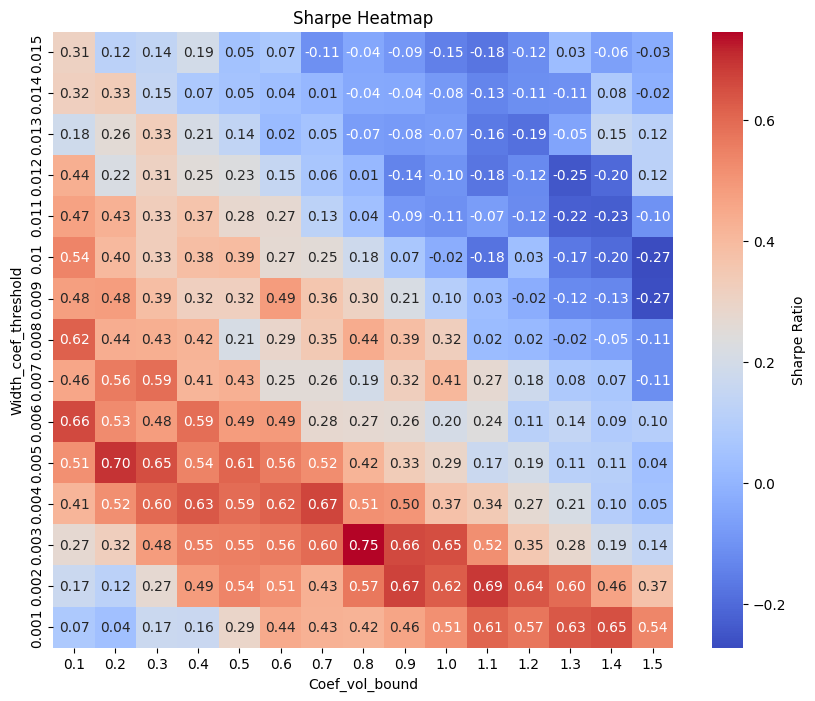

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="sharpe")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".2f", 
    cbar_kws={"label": "Sharpe Ratio"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Sharpe Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

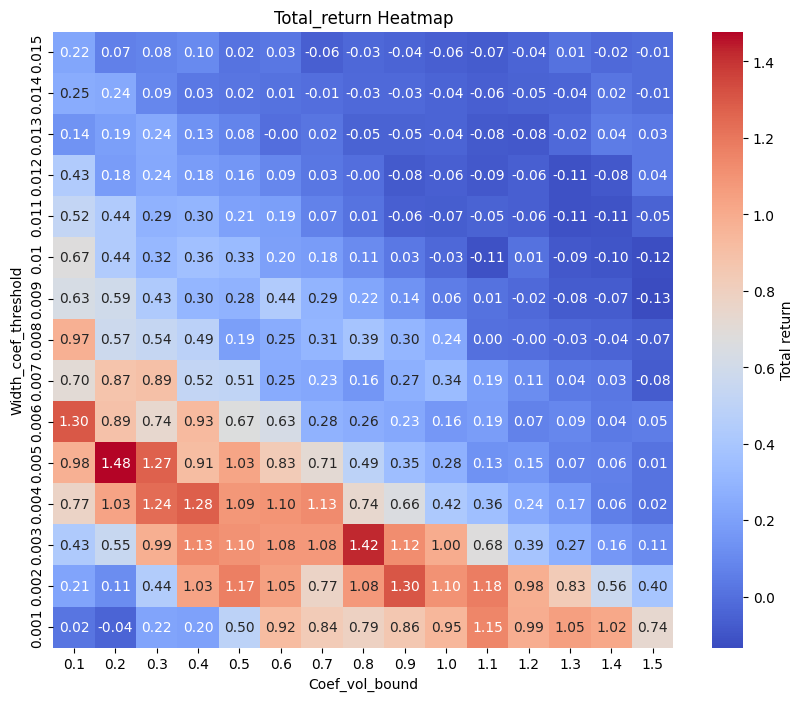

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="total_return")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".2f", 
    cbar_kws={"label": "Total return"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Total_return Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

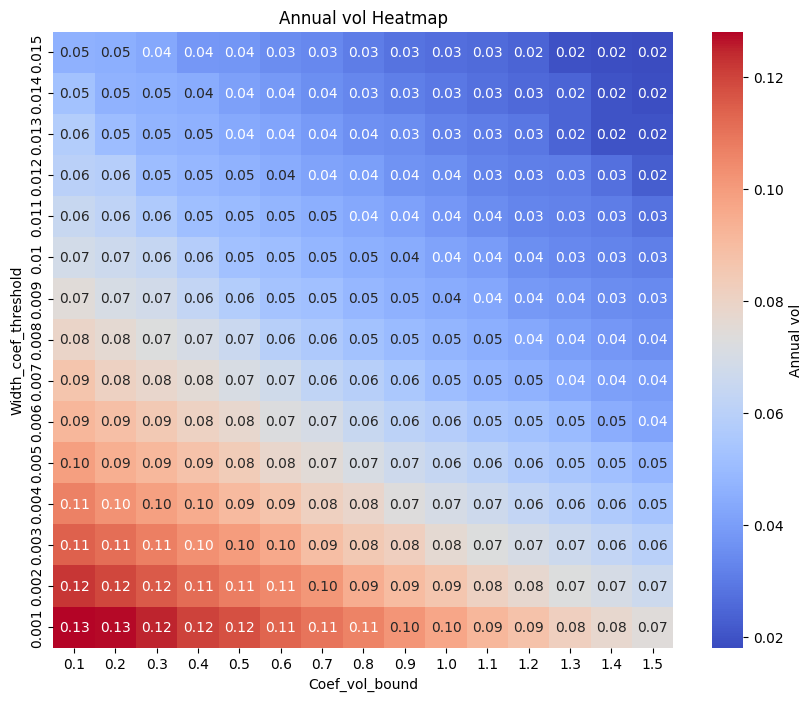

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="vol_annual")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".2f", 
    cbar_kws={"label": "Annual vol"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Annual vol Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

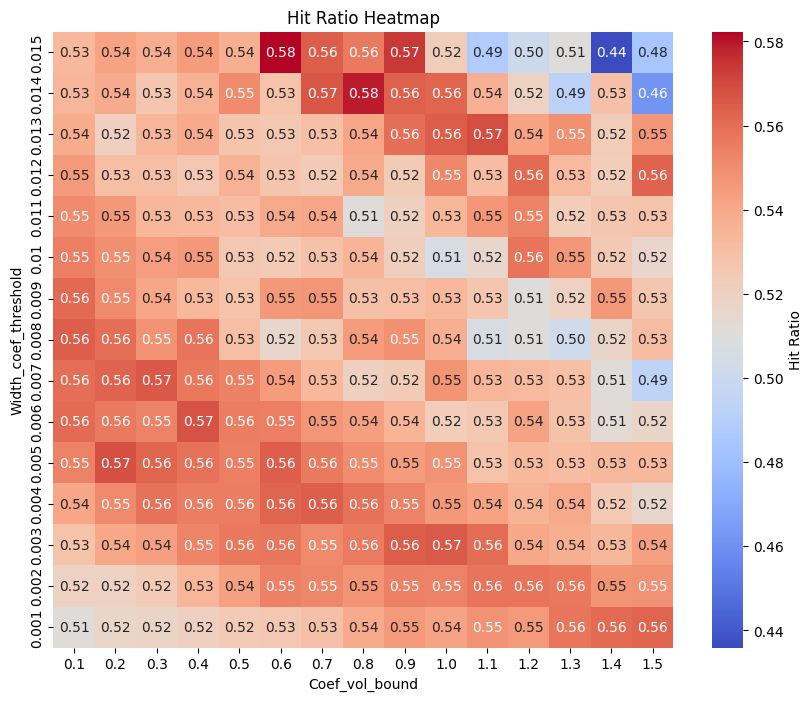

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="hit_ratio")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".2f", 
    cbar_kws={"label": "Hit Ratio"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Hit Ratio Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

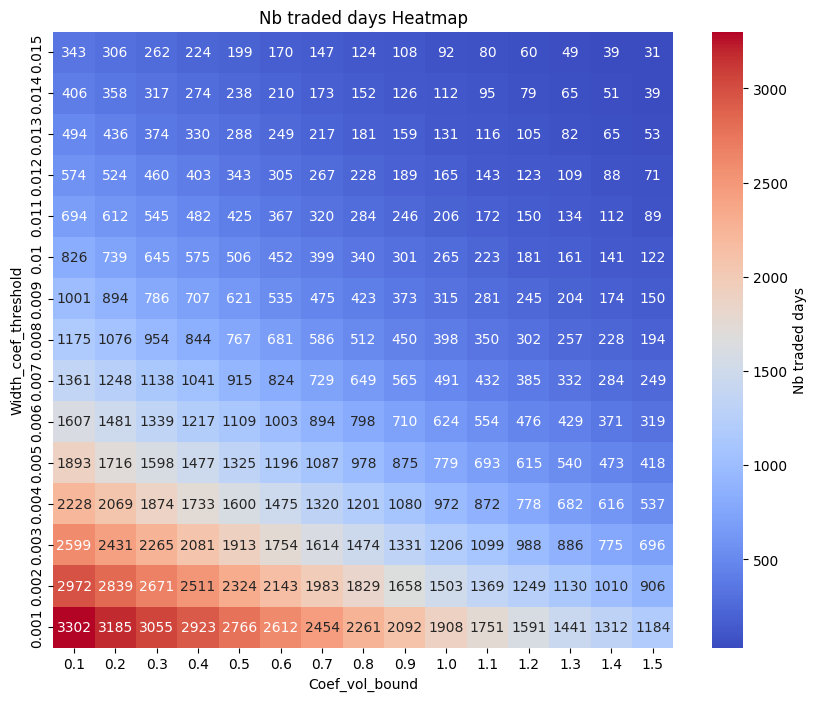

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="n_traded_days")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".0f", 
    cbar_kws={"label": "Nb traded days"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Nb traded days Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

# Strat 2

In [ ]:
### stop same band + vwap

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
import datetime as dt
import matplotlib.dates as mdates

In [15]:
### import the data
df = pd.read_csv('/data/workspace_files/nasdaq.csv')
df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

# (Optional) drop bad rows
df = df.dropna(subset=['Time'])

# Convert UTC -> New York (handles DST)
df['Time'] = df['Time'].dt.tz_convert('America/New_York')

# Build hour/day AFTER conversion
df['hour'] = df['Time'].dt.strftime('%H:%M')
df['day']  = df['Time'].dt.date

# Keep only US RTH 09:30–16:00 ET
market_open, market_close = dt.time(9, 30), dt.time(16, 0)
df = df[df['Time'].dt.time.between(market_open, market_close)]

# Sanity check (optional)
tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()
print("Min/Max ET times in df:", tmin, tmax)  # expect between 09:30 and 16:00


### order by symbol, hour and day
df = df.sort_values(['symbol', 'hour', 'day'])

### price
df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


### opening price
df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


# settling price and previous day settling price
daily_settle = (
    df.sort_values(['symbol','day','Time'])
      .groupby(['symbol','day'])['price']
      .last()
      .rename('settl_price')
)

prev_settle = (
    daily_settle.groupby(level='symbol')
                .shift(1)
                .rename('settl_price_previous')
)

df = df.join(daily_settle, on=['symbol','day'])
df = df.join(prev_settle,   on=['symbol','day'])


### move since opening
df["move"] = np.where(
    df["open_price"] > 0,
    np.abs(df["price"] / df["open_price"] - 1),
    np.nan
)


### compute mean of move over the last period
n = 14
df['sigma_observed'] = (
    df.groupby(['symbol', 'hour'])['move']
      .transform(lambda x: x.rolling(n, min_periods=n).mean())
)


### compute upper bound
df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + df['sigma_observed'])


### compute lower bound
df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - df['sigma_observed'])


### get return
df['return'] = df['settl_price']/df['open_price'] - 1


### get variance onf returns among the last 14 days
daily = (df.sort_values(['symbol','day'])
           .groupby(['symbol','day'], as_index=False)['return'].last())

daily['ret_std_14d'] = (
    daily.groupby('symbol')['return']
         .transform(lambda s: s.rolling(14, min_periods=14).std())
)

df = df.merge(daily[['symbol','day','ret_std_14d']], on=['symbol','day'], how='left')


df = df.sort_values(['symbol', 'day', 'hour'])
# df[df['expiry_order']==1]
df

Min/Max ET times in df: 09:33:00 16:00:00


Time 
 symbol 
 expiry_order 
 bid_px_00 
 ask_px_00 
 vwap_cum 
 hour 
 day 
 price 
 open_price 
 settl_price 
 settl_price_previous 
 move 
 sigma_observed 
 upper_bound 
 lower_bound 
 return 
 ret_std_14d 
 
 
 
 
 0 
 2019-03-15 09:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 NaN 
 09:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 188 
 2019-03-15 09:48:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7303.251423 
 09:48 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 376 
 2019-03-15 10:03:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:03 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 564 
 2019-03-15 10:18:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:18 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 752 
 2019-03-15 10:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7314.065510 
 10:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 266952 
 2019-12-19 15:03:00-05:00 
 NQZ9 
 3 
 8632.25 
 8632.50 
 8613.137849 
 15:03 
 2019-12-19 
 8632.375 
 8604.125 
 8640.625 
 8581.75 
 0.003283 
 0.003430 
 8633.640469 
 8552.311286 
 0.004242 
 0.004776 
 
 
 267140 
 2019-12-19 15:18:00-05:00 
 NQZ9 
 3 
 8628.75 
 8629.25 
 8613.525157 
 15:18 
 2019-12-19 
 8629.000 
 8604.125 
 8640.625 
 8581.75 
 0.002891 
 0.003126 
 8631.021031 
 8554.923912 
 0.004242 
 0.004776 
 
 
 267328 
 2019-12-19 15:33:00-05:00 
 NQZ9 
 3 
 8628.75 
 8629.00 
 8613.953049 
 15:33 
 2019-12-19 
 8628.875 
 8604.125 
 8640.625 
 8581.75 
 0.002877 
 0.003475 
 8634.025434 
 8551.927322 
 0.004242 
 0.004776 
 
 
 267516 
 2019-12-19 15:48:00-05:00 
 NQZ9 
 3 
 8631.75 
 8632.00 
 8614.566532 
 15:48 
 2019-12-19 
 8631.875 
 8604.125 
 8640.625 
 8581.75 
 0.003225 
 0.003479 
 8634.062597 
 8551.890255 
 0.004242 
 0.004776 
 
 
 267704 
 2019-12-19 16:00:00-05:00 
 NQZ9 
 3 
 8640.50 
 8640.75 
 8617.831876 
 16:00 
 2019-12-19 
 8640.625 
 8604.125 
 8640.625 
 8581.75 
 0.004242 
 0.003756 
 8636.446077 
 8549.512973 
 0.004242 
 0.004776 
 
 
 
 267705 rows × 18 columns

In [16]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
            .sort_values('Time')
            .copy())
    backtest_df = backtest_df.sort_values('hour')

    bid_list = backtest_df['bid_px_00'].values
    ask_list = backtest_df['ask_px_00'].values
    upper_bound = backtest_df['upper_bound'].values
    lower_bound = backtest_df['lower_bound'].values
    vwap_list = backtest_df['vwap_cum'].values
    hour = backtest_df['hour'].values

    if not (len(bid_list) == len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound)):
        return initial_cash
    elif any(pd.isna(x) for x in bid_list + ask_list + vwap_list + upper_bound + lower_bound):
        return initial_cash
    

        
    position = 0
    sigma_target = 0.02
    total_shares_to_hold = math.floor(initial_cash / backtest_df['open_price'].values[0])


    count = 0
    for i in range(1, len(bid_list) - 1):
        if ask_list[i] > max(upper_bound[i], vwap_list[i]) and count==0:
            count == 1
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * ask_list[i]
                print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        elif bid_list[i] < min(vwap_list[i], lower_bound[i]) and count == 0:
            count == 1
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * bid_list[i]
                print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        elif bid_list[i] >= min(vwap_list[i], lower_bound[i]) and max(upper_bound[i], vwap_list[i]) >= ask_list[i]:
            # we must close our position
            if position > 0: # we are long so we need to sell
                initial_cash += position * bid_list[i]
                print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
                position = 0
            elif position < 0: # we are short so we need to buy
                initial_cash -= abs(position) * ask_list[i]
                print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
                position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * bid_list[-1]
        position = 0

    elif position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * ask_list[-1]
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

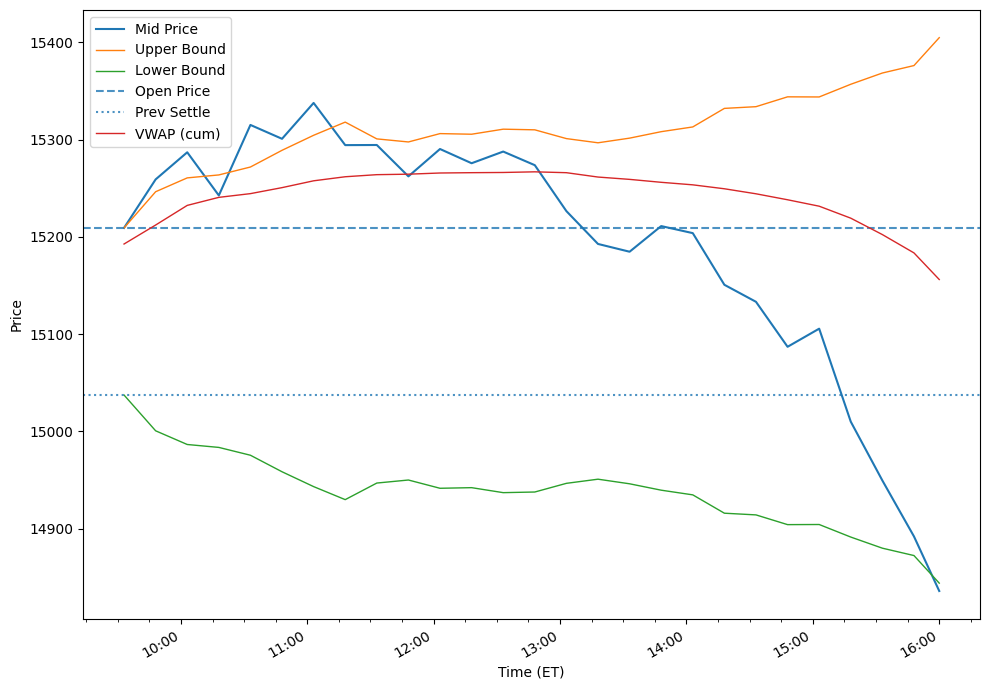

In [17]:
# Ensure Time is tz-aware ET
df["Time"] = pd.to_datetime(df["Time"], utc=True).dt.tz_convert("America/New_York")

# Define day as plain date (no tz needed)
day_str = "2022-01-20"
day = pd.to_datetime(day_str).date()

# Recompute day column in ET if not already done
df["day"] = df["Time"].dt.date

# Filter front-month contract for that day
one = df[(df['expiry_order'] == 1) & (df['day'] == day)].copy()
one = one.sort_values('Time')

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
x = one['Time']

ax.plot(x, one['price'], label='Mid Price')
if 'upper_bound' in one and one['upper_bound'].notna().any():
    ax.plot(x, one['upper_bound'], label='Upper Bound', linewidth=1)
if 'lower_bound' in one and one['lower_bound'].notna().any():
    ax.plot(x, one['lower_bound'], label='Lower Bound', linewidth=1)

if 'open_price' in one and one['open_price'].notna().any():
    ax.axhline(one['open_price'].iloc[0], linestyle='--', alpha=0.8, label='Open Price')
if 'settl_price_previous' in one and one['settl_price_previous'].notna().any():
    ax.axhline(one['settl_price_previous'].iloc[0], linestyle=':', alpha=0.8, label='Prev Settle')

if 'vwap_cum' in one.columns and one['vwap_cum'].notna().any():
    ax.plot(x, one['vwap_cum'], label='VWAP (cum)', linewidth=1)

# Tidy x-axis
import matplotlib.dates as mdates
from zoneinfo import ZoneInfo


tz = ZoneInfo("America/New_York")

ax.xaxis.set_major_locator(mdates.HourLocator(tz=tz))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45], tz=tz))

fig.autofmt_xdate()

ax.set_xlabel("Time (ET)")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
backtest_one_day(df, "2022-01-20", 1, 100000)

Bought 6 shares at 15259.5 on 2022-01-20 at 09:48
Sold 6 shares at 15242.25 on 2022-01-20 at 10:18
Bought 6 shares at 15315.5 on 2022-01-20 at 10:33
Sold 6 shares at 15294.0 on 2022-01-20 at 11:18


99767.5

Sold 23 shares at 4288.75 on 2015-10-06 at 10:33
Bought 23 shares at 4297.0 on 2015-10-06 at 10:48
Sold 23 shares at 4283.25 on 2015-10-06 at 11:33
Bought 23 shares at 4291.5 on 2015-10-06 at 13:18
99620.5


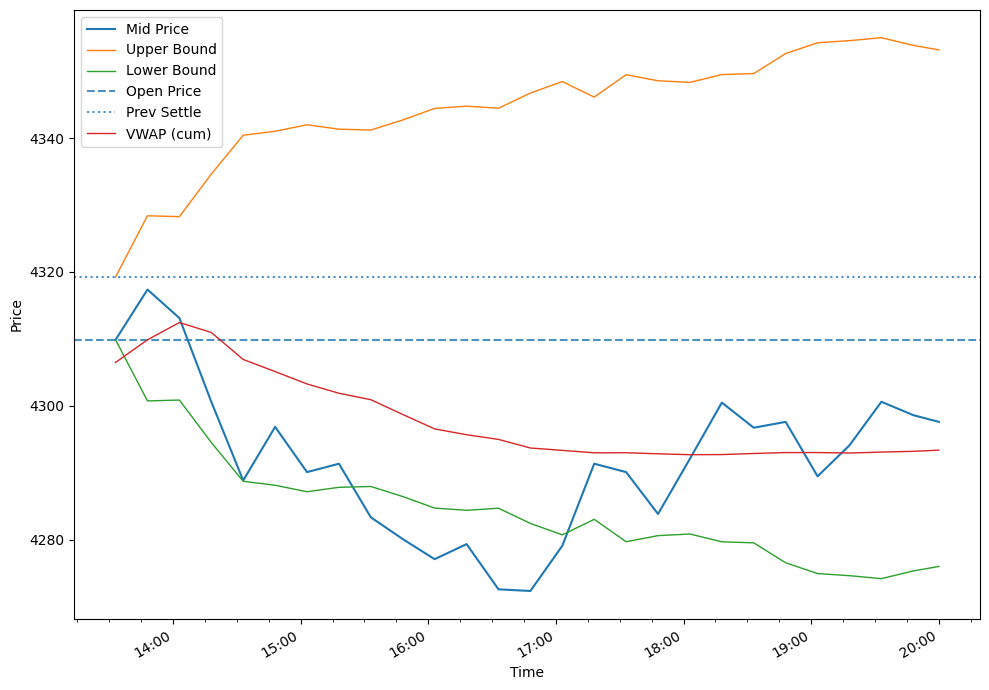

In [19]:
day_str = "2015-10-06"
day = pd.to_datetime(day_str).date()

print(backtest_one_day(df, day_str, 1, 100000))
one = df[(df['expiry_order'] == 1) & (df['day'] == day)].copy()
one = one.sort_values('Time')

fig, ax = plt.subplots(figsize=(10, 7))

x = one['Time']

ax.plot(x, one['price'], label='Mid Price')
if 'upper_bound' in one and one['upper_bound'].notna().any():
    ax.plot(x, one['upper_bound'], label='Upper Bound', linewidth=1)
if 'lower_bound' in one and one['lower_bound'].notna().any():
    ax.plot(x, one['lower_bound'], label='Lower Bound', linewidth=1)

# Horizontal lines for open and previous settlement
if 'open_price' in one and one['open_price'].notna().any():
    ax.axhline(one['open_price'].iloc[0], linestyle='--', alpha=0.8, label='Open Price')
if 'settl_price_previous' in one and one['settl_price_previous'].notna().any():
    ax.axhline(one['settl_price_previous'].iloc[0], linestyle=':', alpha=0.8, label='Prev Settle')

# Optional: VWAP
if 'vwap_cum' in one.columns and one['vwap_cum'].notna().any():
    ax.plot(x, one['vwap_cum'], label='VWAP (cum)', linewidth=1)

# Tidy x-axis: show one tick per hour, minor ticks at 15-min
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45]))
fig.autofmt_xdate()
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()

# Backtest on all day since 2011

In [20]:
def backtest(backtest_df, rank_to_expiry, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        print(day_ts)
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

In [21]:
results = backtest(df, 1)
results

2010-06-07 00:00:00-04:00
2010-06-08 00:00:00-04:00
2010-06-09 00:00:00-04:00
2010-06-10 00:00:00-04:00
2010-06-11 00:00:00-04:00
2010-06-14 00:00:00-04:00
2010-06-15 00:00:00-04:00
2010-06-16 00:00:00-04:00
2010-06-17 00:00:00-04:00
2010-06-18 00:00:00-04:00
2010-06-21 00:00:00-04:00
2010-06-22 00:00:00-04:00
2010-06-23 00:00:00-04:00
2010-06-24 00:00:00-04:00
Sold 53 shares at 1855.0 on 2010-06-24 00:00:00-04:00 at 10:03
Bought 53 shares at 1857.5 on 2010-06-24 00:00:00-04:00 at 10:33
Sold 53 shares at 1853.5 on 2010-06-24 00:00:00-04:00 at 10:48
Bought 53 shares at 1856.5 on 2010-06-24 00:00:00-04:00 at 12:03
Sold 53 shares at 1853.75 on 2010-06-24 00:00:00-04:00 at 12:18
Bought 53 shares at 1859.0 on 2010-06-24 00:00:00-04:00 at 13:18
Sold 53 shares at 1840.25 on 2010-06-24 00:00:00-04:00 at 15:18
Bought 53 shares at 1844.75 on 2010-06-24 00:00:00-04:00 at 15:48
2010-06-25 00:00:00-04:00
Sold 53 shares at 1834.5 on 2010-06-25 00:00:00-04:00 at 09:48
Bought 53 shares at 1844.0 on 20

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 0 
 2010-06-07 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 1 
 2010-06-08 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 2 
 2010-06-09 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 3 
 2010-06-10 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 4 
 2010-06-11 00:00:00-04:00 
 100000.00 
 100000.00 
 0.00 
 0.000000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3738 
 2024-12-24 00:00:00-05:00 
 210540.00 
 212072.25 
 1532.25 
 0.007278 
 True 
 
 
 3739 
 2024-12-26 00:00:00-05:00 
 212072.25 
 212072.25 
 0.00 
 0.000000 
 False 
 
 
 3740 
 2024-12-27 00:00:00-05:00 
 212072.25 
 212601.00 
 528.75 
 0.002493 
 True 
 
 
 3741 
 2024-12-30 00:00:00-05:00 
 212601.00 
 212875.50 
 274.50 
 0.001291 
 True 
 
 
 3742 
 2024-12-31 00:00:00-05:00 
 212875.50 
 211046.25 
 -1829.25 
 -0.008593 
 True 
 
 
 
 3743 rows × 6 columns

In [22]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [23]:
evaluate_strategy(results)

{'total_return': 1.1104625000000001,
 'irr_annual': 0.05157182978947472,
 'vol_annual': 0.07804053072698804,
 'sharpe': 0.6832862922827433,
 'hit_ratio': 0.38930348258706465,
 'mdd': -0.1900108014561963,
 'n_days': 3743,
 'n_traded_days': 2412}

In [25]:
results.sort_values('return')

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 344 
 2011-10-04 00:00:00-04:00 
 94374.00 
 90515.25 
 -3858.75 
 -0.040888 
 True 
 
 
 2506 
 2020-03-18 00:00:00-04:00 
 151446.50 
 146228.00 
 -5218.50 
 -0.034458 
 True 
 
 
 2499 
 2020-03-09 00:00:00-04:00 
 162862.25 
 157647.25 
 -5215.00 
 -0.032021 
 True 
 
 
 2507 
 2020-03-19 00:00:00-04:00 
 146228.00 
 141753.00 
 -4475.00 
 -0.030603 
 True 
 
 
 2984 
 2022-01-24 00:00:00-05:00 
 156325.00 
 151804.00 
 -4521.00 
 -0.028921 
 True 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2137 
 2018-10-10 00:00:00-04:00 
 137493.75 
 141593.25 
 4099.50 
 0.029816 
 True 
 
 
 2190 
 2018-12-26 00:00:00-05:00 
 156958.25 
 161742.25 
 4784.00 
 0.030479 
 True 
 
 
 3205 
 2022-11-30 00:00:00-05:00 
 173744.00 
 179500.25 
 5756.25 
 0.033131 
 True 
 
 
 1964 
 2018-02-08 00:00:00-05:00 
 124831.50 
 129030.00 
 4198.50 
 0.033633 
 True 
 
 
 2147 
 2018-10-24 00:00:00-04:00 
 138440.50 
 143632.25 
 5191.75 
 0.037502 
 True 
 
 
 
 3743 rows × 6 columns

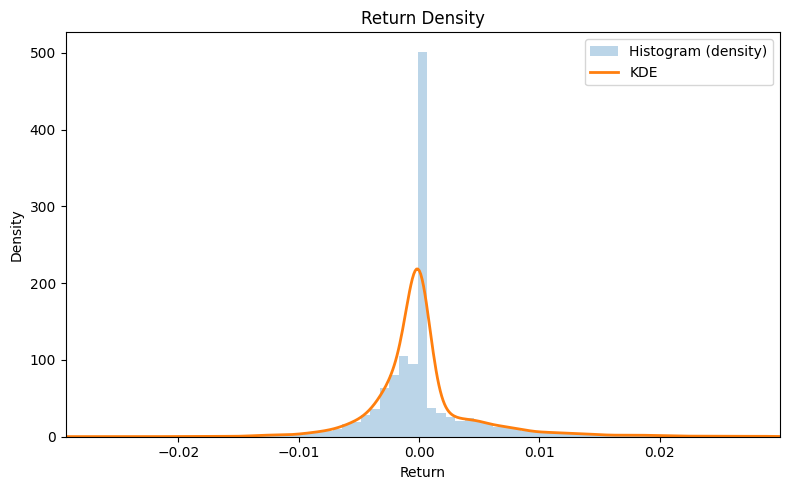

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clean the series
s = pd.Series(results['return'], dtype='float64')
s = s.replace([np.inf, -np.inf], np.nan).dropna()

fig, ax = plt.subplots(figsize=(8, 5))

# Density histogram
ax.hist(s, bins=100, density=True, alpha=0.3, label='Histogram (density)')

# KDE overlay (if scipy available)
try:
    from scipy.stats import gaussian_kde
    xs = np.linspace(s.quantile(0.001), s.quantile(0.999), 512)
    kde = gaussian_kde(s)
    ax.plot(xs, kde(xs), linewidth=2, label='KDE')
except Exception:
    # If scipy isn't installed, just skip the KDE
    pass

# Nice viewing window (doesn't affect density calc)
qlo, qhi = s.quantile([0.001, 0.999])
ax.set_xlim(qlo, qhi)

ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.set_title('Return Density')
ax.legend()
plt.tight_layout()
plt.show()

# Strat2_hyperparameters

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

import datetime as dt

import matplotlib.dates as mdates

In [64]:
### import the data
df = pd.read_csv('/data/workspace_files/nasdaq.csv')
df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

# (Optional) drop bad rows
df = df.dropna(subset=['Time'])

# Convert UTC -> New York (handles DST)
df['Time'] = df['Time'].dt.tz_convert('America/New_York')

# Build hour/day AFTER conversion
df['hour'] = df['Time'].dt.strftime('%H:%M')
df['day']  = df['Time'].dt.date

# Keep only US RTH 09:30–16:00 ET
market_open, market_close = dt.time(9, 30), dt.time(16, 0)
df = df[df['Time'].dt.time.between(market_open, market_close)]

# Sanity check (optional)
tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()


### order by symbol, hour and day
df = df.sort_values(['symbol', 'hour', 'day'])

### price
df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


### opening price
df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


# settling price and previous day settling price
daily_settle = (
    df.sort_values(['symbol','day','Time'])
      .groupby(['symbol','day'])['price']
      .last()
      .rename('settl_price')
)

prev_settle = (
    daily_settle.groupby(level='symbol')
                .shift(1)
                .rename('settl_price_previous')
)

df = df.join(daily_settle, on=['symbol','day'])
df = df.join(prev_settle,   on=['symbol','day'])


### move since opening
df["move"] = np.where(
    df["open_price"] > 0,
    np.abs(df["price"] / df["open_price"] - 1),
    np.nan
)


### compute mean of move over the last period
n = 14
df['sigma_observed'] = (
    df.groupby(['symbol', 'hour'])['move']
      .transform(lambda x: x.rolling(n, min_periods=n).mean())
)


### compute upper bound
df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + df['sigma_observed'])


### compute lower bound
df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - df['sigma_observed'])


### get return
df['return'] = df['settl_price']/df['open_price'] - 1


### get variance onf returns among the last 14 days
daily = (df.sort_values(['symbol','day'])
           .groupby(['symbol','day'], as_index=False)['return'].last())

daily['ret_std_14d'] = (
    daily.groupby('symbol')['return']
         .transform(lambda s: s.rolling(14, min_periods=14).std())
)

df = df.merge(daily[['symbol','day','ret_std_14d']], on=['symbol','day'], how='left')


df = df.sort_values(['symbol', 'day', 'hour'])
# df[df['expiry_order']==1]
df

Time 
 symbol 
 expiry_order 
 bid_px_00 
 ask_px_00 
 vwap_cum 
 hour 
 day 
 price 
 open_price 
 settl_price 
 settl_price_previous 
 move 
 sigma_observed 
 upper_bound 
 lower_bound 
 return 
 ret_std_14d 
 
 
 
 
 0 
 2019-03-15 09:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 NaN 
 09:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 188 
 2019-03-15 09:48:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7303.251423 
 09:48 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 376 
 2019-03-15 10:03:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:03 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 564 
 2019-03-15 10:18:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:18 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 752 
 2019-03-15 10:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7314.065510 
 10:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 266952 
 2019-12-19 15:03:00-05:00 
 NQZ9 
 3 
 8632.25 
 8632.50 
 8613.137849 
 15:03 
 2019-12-19 
 8632.375 
 8604.125 
 8640.625 
 8581.75 
 0.003283 
 0.003430 
 8633.640469 
 8552.311286 
 0.004242 
 0.004776 
 
 
 267140 
 2019-12-19 15:18:00-05:00 
 NQZ9 
 3 
 8628.75 
 8629.25 
 8613.525157 
 15:18 
 2019-12-19 
 8629.000 
 8604.125 
 8640.625 
 8581.75 
 0.002891 
 0.003126 
 8631.021031 
 8554.923912 
 0.004242 
 0.004776 
 
 
 267328 
 2019-12-19 15:33:00-05:00 
 NQZ9 
 3 
 8628.75 
 8629.00 
 8613.953049 
 15:33 
 2019-12-19 
 8628.875 
 8604.125 
 8640.625 
 8581.75 
 0.002877 
 0.003475 
 8634.025434 
 8551.927322 
 0.004242 
 0.004776 
 
 
 267516 
 2019-12-19 15:48:00-05:00 
 NQZ9 
 3 
 8631.75 
 8632.00 
 8614.566532 
 15:48 
 2019-12-19 
 8631.875 
 8604.125 
 8640.625 
 8581.75 
 0.003225 
 0.003479 
 8634.062597 
 8551.890255 
 0.004242 
 0.004776 
 
 
 267704 
 2019-12-19 16:00:00-05:00 
 NQZ9 
 3 
 8640.50 
 8640.75 
 8617.831876 
 16:00 
 2019-12-19 
 8640.625 
 8604.125 
 8640.625 
 8581.75 
 0.004242 
 0.003756 
 8636.446077 
 8549.512973 
 0.004242 
 0.004776 
 
 
 
 267705 rows × 18 columns

In [65]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash, sigma_target):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
                               .sort_values('Time')
                               .copy())
    backtest_df = backtest_df.sort_values('hour')

    # --- basic guards ---
    if backtest_df.empty:
        return initial_cash

    # Pull scalars safely
    ret_std = backtest_df['ret_std_14d'].iloc[0]
    open_price = backtest_df['open_price'].iloc[0]

    # Validate inputs used in floor(); avoid NaN / inf / nonpositive std or price
    if (not np.isfinite(ret_std)) or (ret_std <= 0) or (not np.isfinite(open_price)) or (open_price <= 0):
        total_shares_to_hold = 0
    else:
        lev = 1  # cap leverage at 4x
        sizing = initial_cash * lev / open_price
        total_shares_to_hold = int(np.floor(sizing)) if np.isfinite(sizing) and sizing > 0 else 0

    # Extract arrays
    bid_list     = backtest_df['bid_px_00'].to_numpy()
    ask_list     = backtest_df['ask_px_00'].to_numpy()
    upper_bound  = backtest_df['upper_bound'].to_numpy()
    lower_bound  = backtest_df['lower_bound'].to_numpy()
    vwap_list    = backtest_df['vwap_cum'].to_numpy()
    hour         = backtest_df['hour'].to_numpy()

    # Length / NaN checks
    n = len(bid_list)
    if not (len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound) == n) or n == 0:
        return initial_cash

    # IMPORTANT: your previous NaN check added arrays together (elementwise sum).
    # Do proper per-array NaN checks:
    if (np.isnan(bid_list).any() or np.isnan(ask_list).any() or
        np.isnan(vwap_list).any() or np.isnan(upper_bound).any() or
        np.isnan(lower_bound).any()):
        return initial_cash

    position = 0
    cash = float(initial_cash)


    for i in range(1, len(bid_list) - 1):
        if ask_list[i] > max(upper_bound[i], vwap_list[i]):
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * ask_list[i]
                # print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        elif bid_list[i] < min(vwap_list[i], lower_bound[i]):
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * bid_list[i]
                # print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        elif bid_list[i] >= min(vwap_list[i], lower_bound[i]) and max(upper_bound[i], vwap_list[i]) >= ask_list[i]:
            # we must close our position
            if position > 0: # we are long so we need to sell
                initial_cash += position * bid_list[i]
                # print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
                position = 0
            elif position < 0: # we are short so we need to buy
                initial_cash -= abs(position) * ask_list[i]
                # print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
                position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * bid_list[-1]
        position = 0

    elif position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * ask_list[-1]
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

In [66]:
def backtest(backtest_df, rank_to_expiry, sigma_target, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash, sigma_target)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

# backtest(df, rank_to_expiry = 1, sigma_target=0.02, initial_cash=100_000)

In [67]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [68]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization, sigma_leverage_period, sigma_leverage_bound, sigma_target):

    df = pd.read_csv('/data/workspace_files/nasdaq.csv')
    df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # (Optional) drop bad rows
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST)
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')

    # Build hour/day AFTER conversion
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date

    # Keep only US RTH 09:30–16:00 ET
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Sanity check (optional)
    tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()

    ### order by symbol, hour and day
    df = df.sort_values(['symbol', 'hour', 'day'])

    ### price
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


    ### opening price
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


    # settling price and previous day settling price
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
        .groupby(['symbol','day'])['price']
        .last()
        .rename('settl_price')
    )

    prev_settle = (
        daily_settle.groupby(level='symbol')
                    .shift(1)
                    .rename('settl_price_previous')
    )

    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])


    ### move since opening
    df["move"] = np.where(
        df["open_price"] > 0,
        np.abs(df["price"] / df["open_price"] - 1),
        np.nan
    )


    ### compute mean of move over the last period
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
        .transform(lambda x: x.rolling(sigma_leverage_bound, min_periods=sigma_leverage_bound).mean())
    )


    ### compute upper bound
    df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + coef_sigma * df['sigma_observed']) + percentage_penalization * df['open_price']


    ### compute lower bound
    df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - coef_sigma * df['sigma_observed']) - percentage_penalization * df['open_price']


    ### get return
    df['return'] = df['settl_price']/df['open_price'] - 1


    ### get variance onf returns among the last 14 days
    daily = (df.sort_values(['symbol','day'])
            .groupby(['symbol','day'], as_index=False)['return'].last())

    daily[f'ret_std_14d'] = (
        daily.groupby('symbol')['return']
            .transform(lambda s: s.rolling(sigma_leverage_period, min_periods=sigma_leverage_period).std())
    )

    df = df.merge(daily[['symbol','day', f'ret_std_14d']], on=['symbol','day'], how='left')


    df = df.sort_values(['symbol', 'day', 'hour'])

    results = backtest(df, 1, sigma_target)

    return evaluate_strategy(results, risk_free_rate=0.00)


In [69]:
results = backtest_with_hyperparameters(1, 0, 14, 14, 0.02)
results

{'total_return': 1.1104625000000001,
 'irr_annual': 0.05157182978947472,
 'vol_annual': 0.07804053072698804,
 'sharpe': 0.6832862922827433,
 'hit_ratio': 0.38930348258706465,
 'mdd': -0.1900108014561963,
 'n_days': 3743,
 'n_traded_days': 2412}

In [70]:
import itertools
import math
import numpy as np
import pandas as pd

def run_grid_search(
    backtest_fn,
    p1_values,
    p2_values,
    p3_values,
    p4_values,
    p5_values,
    verbose=True,
):
    """
    backtest_fn: callable like backtest_with_hyperparameters(p1, p2) -> dict
    p1_values, p2_values: iterables of parameter candidates
    """
    rows = []
    for p1, p2, p3, p4, p5 in itertools.product(p1_values, p2_values, p3_values, p4_values, p5_values):
        try:
            res = backtest_fn(p1, p2, p3, p4, p5)  # expected to return a dict with keys shown below
            # Ensure required keys exist (coerce missing to NaN)
            record = {
                "param1": p1,
                "param2": p2,                
                "param3": p3,
                "param4": p4,
                "param5": p5,
                "total_return": res.get("total_return", np.nan),
                "irr_annual": res.get("irr_annual", np.nan),
                "vol_annual": res.get("vol_annual", np.nan),
                "sharpe": res.get("sharpe", np.nan),
                "hit_ratio": res.get("hit_ratio", np.nan),
                "mdd": res.get("mdd", np.nan),
                "n_days": res.get("n_days", np.nan),
                "n_traded_days": res.get("n_traded_days", np.nan),
                "error": None,
            }
        except Exception as e:
            record = {
                "param1": p1,
                "param2": p2,                
                "param3": p3,
                "param4": p4,
                "param5": p5,
                "total_return": np.nan,
                "irr_annual": np.nan,
                "vol_annual": np.nan,
                "sharpe": np.nan,
                "hit_ratio": np.nan,
                "mdd": np.nan,
                "n_days": np.nan,
                "n_traded_days": np.nan,
                "error": str(e),
            }
        rows.append(record)
        print(record)

    df = pd.DataFrame(rows)

    # Keep only successful runs with finite metrics
    ok = df[df["error"].isna()].copy()
    for c in ["total_return", "sharpe"]:
        ok = ok[np.isfinite(ok[c])]

    if ok.empty:
        if verbose:
            print("No successful runs with finite metrics.")
        # Still return the full df for debugging
        return {
            "all_results": df.sort_values(["param1", "param2", "param3", "param4", "param5"]).reset_index(drop=True),
            "best_total_return": None,
            "best_sharpe": None,
        }

    # Best by total return
    idx_ret = ok["total_return"].idxmax()
    best_ret = ok.loc[idx_ret].to_dict()

    # Best by Sharpe
    idx_sharpe = ok["sharpe"].idxmax()
    best_sharpe = ok.loc[idx_sharpe].to_dict()

    if verbose:
        print("=== Best by total_return ===")
        print(
            f"param1={best_ret['param1']}, param2={best_ret['param2']}, param3={best_ret['param3']}, param4={best_ret['param4']}, param5={best_ret['param5']}"
            f"total_return={best_ret['total_return']:.6f}, "
            f"sharpe={best_ret['sharpe']:.6f}, vol_annual={best_ret['vol_annual']:.6f}, "
            f"hit_ratio={best_ret['hit_ratio']:.4f}, mdd={best_ret['mdd']:.4f}, "
            f"n_days={int(best_ret['n_days']) if not math.isnan(best_ret['n_days']) else 'NA'}, "
            f"n_traded_days={int(best_ret['n_traded_days']) if not math.isnan(best_ret['n_traded_days']) else 'NA'}"
        )
        print("\n=== Best by sharpe ===")
        print(
            f"param1={best_sharpe['param1']}, param2={best_sharpe['param2']}, param3={best_sharpe['param3']}, param4={best_sharpe['param4']}, param5={best_sharpe['param5']}"
            f"sharpe={best_sharpe['sharpe']:.6f}, "
            f"total_return={best_sharpe['total_return']:.6f}, vol_annual={best_sharpe['vol_annual']:.6f}, "
            f"hit_ratio={best_sharpe['hit_ratio']:.4f}, mdd={best_sharpe['mdd']:.4f}, "
            f"n_days={int(best_sharpe['n_days']) if not math.isnan(best_sharpe['n_days']) else 'NA'}, "
            f"n_traded_days={int(best_sharpe['n_traded_days']) if not math.isnan(best_sharpe['n_traded_days']) else 'NA'}"
        )

    return {
        "all_results": df.sort_values(["param1", "param2", 'param3', 'param4', 'param5']).reset_index(drop=True),
        "best_total_return": best_ret,
        "best_sharpe": best_sharpe,
    }

In [71]:
p1_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
p2_grid = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012]
p3_grid = [14]
p4_grid = [14]
p5_grid = [0.02]

results = run_grid_search(backtest_with_hyperparameters, p1_grid, p2_grid, p3_grid, p4_grid, p5_grid,  verbose=True)

# Access the DataFrame of all runs:
all_runs_df = results["all_results"]
# Top 10 by total_return:
top10_return = all_runs_df.sort_values("total_return", ascending=False).head(10)
# Top 10 by Sharpe:
top10_sharpe = all_runs_df.sort_values("sharpe", ascending=False).head(10)

all_runs_df

{'param1': 0.1, 'param2': 0.001, 'param3': 14, 'param4': 14, 'param5': 0.02, 'total_return': 0.6778200000000001, 'irr_annual': 0.03545477081770576, 'vol_annual': 0.10648864666309339, 'sharpe': 0.3804087614848829, 'hit_ratio': 0.4277071990320629, 'mdd': -0.17499812748108756, 'n_days': 3743, 'n_traded_days': 3306, 'error': None}
{'param1': 0.1, 'param2': 0.002, 'param3': 14, 'param4': 14, 'param5': 0.02, 'total_return': 1.0923349999999998, 'irr_annual': 0.050961273533599805, 'vol_annual': 0.09835594892008893, 'sharpe': 0.5545016150767915, 'hit_ratio': 0.4285234899328859, 'mdd': -0.17786929560340725, 'n_days': 3743, 'n_traded_days': 2980, 'error': None}
{'param1': 0.1, 'param2': 0.003, 'param3': 14, 'param4': 14, 'param5': 0.02, 'total_return': 1.380985, 'irr_annual': 0.06014530963025111, 'vol_annual': 0.09078714622146368, 'sharpe': 0.6886922220065195, 'hit_ratio': 0.43060361399461744, 'mdd': -0.15793789610967413, 'n_days': 3743, 'n_traded_days': 2601, 'error': None}
{'param1': 0.1, 'para

param1 
 param2 
 param3 
 param4 
 param5 
 total_return 
 irr_annual 
 vol_annual 
 sharpe 
 hit_ratio 
 mdd 
 n_days 
 n_traded_days 
 error 
 
 
 
 
 0 
 0.1 
 0.001 
 14 
 14 
 0.02 
 0.677820 
 0.035455 
 0.106489 
 0.380409 
 0.427707 
 -0.174998 
 3743 
 3306 
 None 
 
 
 1 
 0.1 
 0.002 
 14 
 14 
 0.02 
 1.092335 
 0.050961 
 0.098356 
 0.554502 
 0.428523 
 -0.177869 
 3743 
 2980 
 None 
 
 
 2 
 0.1 
 0.003 
 14 
 14 
 0.02 
 1.380985 
 0.060145 
 0.090787 
 0.688692 
 0.430604 
 -0.157938 
 3743 
 2601 
 None 
 
 
 3 
 0.1 
 0.004 
 14 
 14 
 0.02 
 1.556550 
 0.065235 
 0.084498 
 0.790137 
 0.436911 
 -0.150478 
 3743 
 2227 
 None 
 
 
 4 
 0.1 
 0.005 
 14 
 14 
 0.02 
 1.720127 
 0.069693 
 0.077791 
 0.904955 
 0.448549 
 -0.147763 
 3743 
 1895 
 None 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 175 
 1.5 
 0.008 
 14 
 14 
 0.02 
 -0.148142 
 -0.010737 
 0.022295 
 -0.473022 
 0.365979 
 -0.173375 
 3743 
 194 
 None 
 
 
 176 
 1.5 
 0.009 
 14 
 14 
 0.02 
 -0.131012 
 -0.009410 
 0.020119 
 -0.459858 
 0.353333 
 -0.157837 
 3743 
 150 
 None 
 
 
 177 
 1.5 
 0.010 
 14 
 14 
 0.02 
 -0.150578 
 -0.010927 
 0.019565 
 -0.551771 
 0.344262 
 -0.182324 
 3743 
 122 
 None 
 
 
 178 
 1.5 
 0.011 
 14 
 14 
 0.02 
 -0.140315 
 -0.010127 
 0.018707 
 -0.534741 
 0.348315 
 -0.163018 
 3743 
 89 
 None 
 
 
 179 
 1.5 
 0.012 
 14 
 14 
 0.02 
 -0.063477 
 -0.004406 
 0.015793 
 -0.271663 
 0.352113 
 -0.100068 
 3743 
 71 
 None 
 
 
 
 180 rows × 14 columns

In [72]:
top10_return

param1 
 param2 
 param3 
 param4 
 param5 
 total_return 
 irr_annual 
 vol_annual 
 sharpe 
 hit_ratio 
 mdd 
 n_days 
 n_traded_days 
 error 
 
 
 
 
 49 
 0.5 
 0.002 
 14 
 14 
 0.02 
 2.196662 
 0.081382 
 0.081464 
 1.001114 
 0.421370 
 -0.152302 
 3743 
 2321 
 None 
 
 
 38 
 0.4 
 0.003 
 14 
 14 
 0.02 
 1.953700 
 0.075642 
 0.078209 
 0.971418 
 0.429259 
 -0.147253 
 3743 
 2078 
 None 
 
 
 61 
 0.6 
 0.002 
 14 
 14 
 0.02 
 1.785347 
 0.071400 
 0.078078 
 0.922330 
 0.419701 
 -0.184928 
 3743 
 2142 
 None 
 
 
 27 
 0.3 
 0.004 
 14 
 14 
 0.02 
 1.778217 
 0.071216 
 0.075636 
 0.947313 
 0.433993 
 -0.144990 
 3743 
 1871 
 None 
 
 
 26 
 0.3 
 0.003 
 14 
 14 
 0.02 
 1.778083 
 0.071212 
 0.083614 
 0.864511 
 0.429960 
 -0.149389 
 3743 
 2263 
 None 
 
 
 15 
 0.2 
 0.004 
 14 
 14 
 0.02 
 1.769293 
 0.070983 
 0.080457 
 0.892572 
 0.432511 
 -0.145430 
 3743 
 2067 
 None 
 
 
 4 
 0.1 
 0.005 
 14 
 14 
 0.02 
 1.720127 
 0.069693 
 0.077791 
 0.904955 
 0.448549 
 -0.147763 
 3743 
 1895 
 None 
 
 
 37 
 0.4 
 0.002 
 14 
 14 
 0.02 
 1.598135 
 0.066393 
 0.086484 
 0.786490 
 0.413972 
 -0.155472 
 3743 
 2505 
 None 
 
 
 50 
 0.5 
 0.003 
 14 
 14 
 0.02 
 1.584977 
 0.066029 
 0.074483 
 0.895667 
 0.427973 
 -0.159796 
 3743 
 1909 
 None 
 
 
 3 
 0.1 
 0.004 
 14 
 14 
 0.02 
 1.556550 
 0.065235 
 0.084498 
 0.790137 
 0.436911 
 -0.150478 
 3743 
 2227 
 None

In [73]:
top10_sharpe

param1 
 param2 
 param3 
 param4 
 param5 
 total_return 
 irr_annual 
 vol_annual 
 sharpe 
 hit_ratio 
 mdd 
 n_days 
 n_traded_days 
 error 
 
 
 
 
 49 
 0.5 
 0.002 
 14 
 14 
 0.02 
 2.196662 
 0.081382 
 0.081464 
 1.001114 
 0.421370 
 -0.152302 
 3743 
 2321 
 None 
 
 
 38 
 0.4 
 0.003 
 14 
 14 
 0.02 
 1.953700 
 0.075642 
 0.078209 
 0.971418 
 0.429259 
 -0.147253 
 3743 
 2078 
 None 
 
 
 27 
 0.3 
 0.004 
 14 
 14 
 0.02 
 1.778217 
 0.071216 
 0.075636 
 0.947313 
 0.433993 
 -0.144990 
 3743 
 1871 
 None 
 
 
 61 
 0.6 
 0.002 
 14 
 14 
 0.02 
 1.785347 
 0.071400 
 0.078078 
 0.922330 
 0.419701 
 -0.184928 
 3743 
 2142 
 None 
 
 
 4 
 0.1 
 0.005 
 14 
 14 
 0.02 
 1.720127 
 0.069693 
 0.077791 
 0.904955 
 0.448549 
 -0.147763 
 3743 
 1895 
 None 
 
 
 50 
 0.5 
 0.003 
 14 
 14 
 0.02 
 1.584977 
 0.066029 
 0.074483 
 0.895667 
 0.427973 
 -0.159796 
 3743 
 1909 
 None 
 
 
 15 
 0.2 
 0.004 
 14 
 14 
 0.02 
 1.769293 
 0.070983 
 0.080457 
 0.892572 
 0.432511 
 -0.145430 
 3743 
 2067 
 None 
 
 
 26 
 0.3 
 0.003 
 14 
 14 
 0.02 
 1.778083 
 0.071212 
 0.083614 
 0.864511 
 0.429960 
 -0.149389 
 3743 
 2263 
 None 
 
 
 16 
 0.2 
 0.005 
 14 
 14 
 0.02 
 1.409218 
 0.060987 
 0.073593 
 0.841174 
 0.453116 
 -0.142285 
 3743 
 1717 
 None 
 
 
 39 
 0.4 
 0.004 
 14 
 14 
 0.02 
 1.259818 
 0.056424 
 0.071597 
 0.802423 
 0.438799 
 -0.169479 
 3743 
 1732 
 None

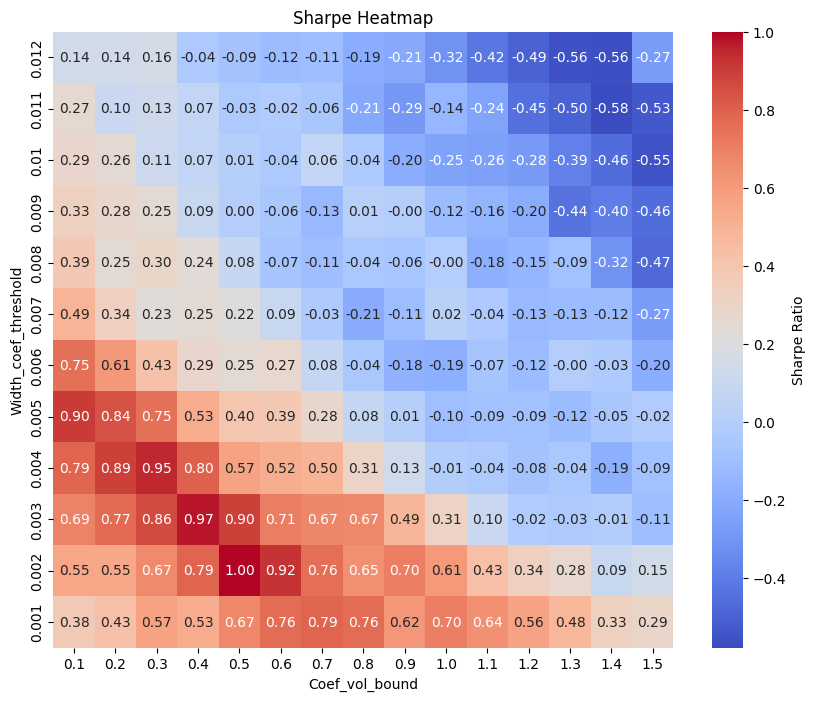

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="sharpe")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".2f", 
    cbar_kws={"label": "Sharpe Ratio"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Sharpe Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

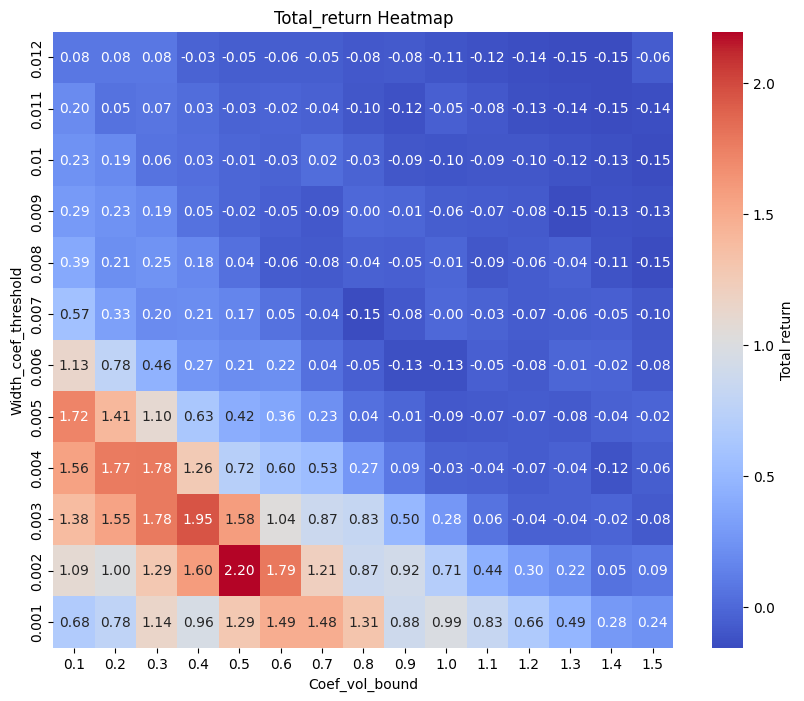

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="total_return")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".2f", 
    cbar_kws={"label": "Total return"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Total_return Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

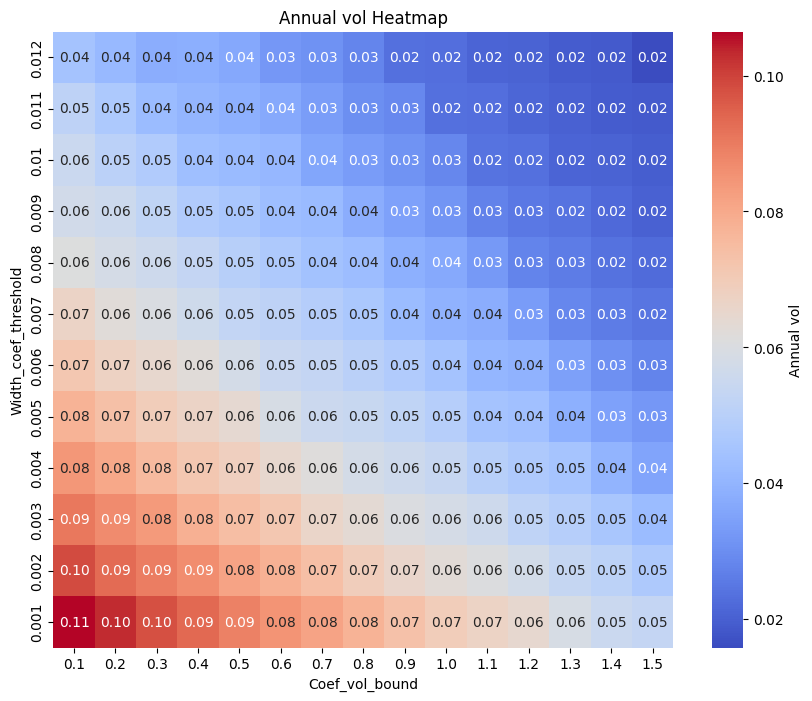

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="vol_annual")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".2f", 
    cbar_kws={"label": "Annual vol"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Annual vol Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

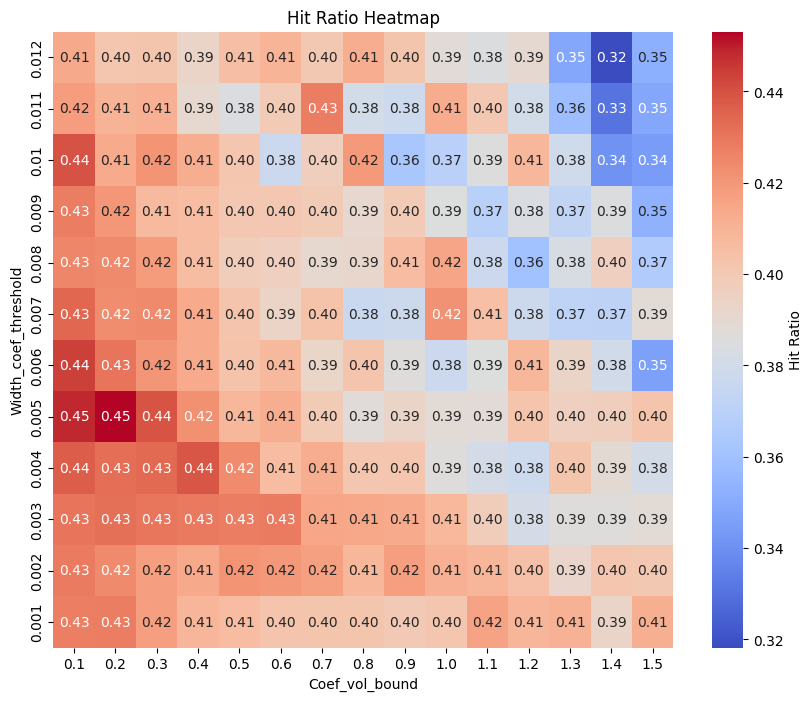

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="hit_ratio")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".2f", 
    cbar_kws={"label": "Hit Ratio"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Hit Ratio Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

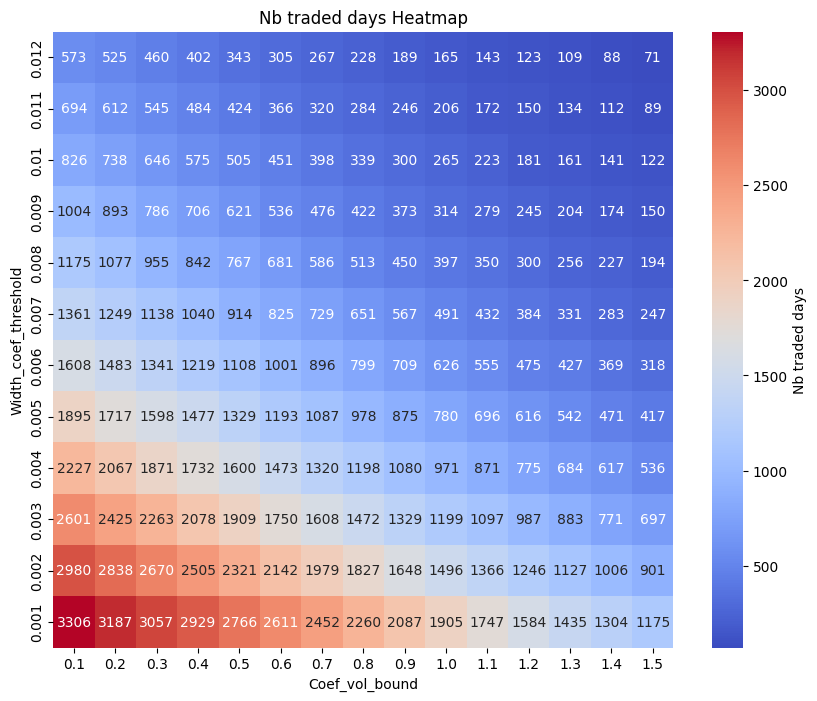

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = all_runs_df.pivot_table(index="param2", columns="param1", values="n_traded_days")

# Ensure axes are sorted ascending so (0,0) is bottom-left
pivot = pivot.sort_index(ascending=False).sort_index(axis=1, ascending=True)

plt.figure(figsize=(10,8))
ax = sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    annot=True, fmt=".0f", 
    cbar_kws={"label": "Nb traded days"},
    xticklabels=pivot.columns,
    yticklabels=pivot.index
)


ax.set_title("Nb traded days Heatmap")
ax.set_xlabel("Coef_vol_bound")
ax.set_ylabel("Width_coef_threshold")
plt.show()

In [79]:
results = backtest_with_hyperparameters(1, 0, 14, 14, 0.02)
results

{'total_return': 1.1104625000000001,
 'irr_annual': 0.05157182978947472,
 'vol_annual': 0.07804053072698804,
 'sharpe': 0.6832862922827433,
 'hit_ratio': 0.38930348258706465,
 'mdd': -0.1900108014561963,
 'n_days': 3743,
 'n_traded_days': 2412}

# Strat4

In [80]:
### stop same band + vwap + dynamic size bet

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
import datetime as dt
import matplotlib.dates as mdates

In [82]:
### import the data
df = pd.read_csv('/data/workspace_files/nasdaq.csv')
df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

# (Optional) drop bad rows
df = df.dropna(subset=['Time'])

# Convert UTC -> New York (handles DST)
df['Time'] = df['Time'].dt.tz_convert('America/New_York')

# Build hour/day AFTER conversion
df['hour'] = df['Time'].dt.strftime('%H:%M')
df['day']  = df['Time'].dt.date

# Keep only US RTH 09:30–16:00 ET
market_open, market_close = dt.time(9, 30), dt.time(16, 0)
df = df[df['Time'].dt.time.between(market_open, market_close)]

# Sanity check (optional)
tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()
print("Min/Max ET times in df:", tmin, tmax)  # expect between 09:30 and 16:00


### order by symbol, hour and day
df = df.sort_values(['symbol', 'hour', 'day'])

### price
df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


### opening price
df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


# settling price and previous day settling price
daily_settle = (
    df.sort_values(['symbol','day','Time'])
      .groupby(['symbol','day'])['price']
      .last()
      .rename('settl_price')
)

prev_settle = (
    daily_settle.groupby(level='symbol')
                .shift(1)
                .rename('settl_price_previous')
)

df = df.join(daily_settle, on=['symbol','day'])
df = df.join(prev_settle,   on=['symbol','day'])


### move since opening
df["move"] = np.where(
    df["open_price"] > 0,
    np.abs(df["price"] / df["open_price"] - 1),
    np.nan
)


### compute mean of move over the last period
n = 14
df['sigma_observed'] = (
    df.groupby(['symbol', 'hour'])['move']
      .transform(lambda x: x.rolling(n, min_periods=n).mean())
)


### compute upper bound
df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + df['sigma_observed'])


### compute lower bound
df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - df['sigma_observed'])


### get return
df['return'] = df['settl_price']/df['open_price'] - 1


### get variance onf returns among the last 14 days
daily = (df.sort_values(['symbol','day'])
           .groupby(['symbol','day'], as_index=False)['return'].last())

daily['ret_std_14d'] = (
    daily.groupby('symbol')['return']
         .transform(lambda s: s.rolling(14, min_periods=14).std())
)

df = df.merge(daily[['symbol','day','ret_std_14d']], on=['symbol','day'], how='left')


df = df.sort_values(['symbol', 'day', 'hour'])
# df[df['expiry_order']==1]
df

Min/Max ET times in df: 09:33:00 16:00:00


Time 
 symbol 
 expiry_order 
 bid_px_00 
 ask_px_00 
 vwap_cum 
 hour 
 day 
 price 
 open_price 
 settl_price 
 settl_price_previous 
 move 
 sigma_observed 
 upper_bound 
 lower_bound 
 return 
 ret_std_14d 
 
 
 
 
 0 
 2019-03-15 09:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 NaN 
 09:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 188 
 2019-03-15 09:48:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7303.251423 
 09:48 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 376 
 2019-03-15 10:03:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:03 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 564 
 2019-03-15 10:18:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7370.000000 
 10:18 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 752 
 2019-03-15 10:33:00-04:00 
 NQH0 
 1 
 NaN 
 NaN 
 7314.065510 
 10:33 
 2019-03-15 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 266952 
 2019-12-19 15:03:00-05:00 
 NQZ9 
 3 
 8632.25 
 8632.50 
 8613.137849 
 15:03 
 2019-12-19 
 8632.375 
 8604.125 
 8640.625 
 8581.75 
 0.003283 
 0.003430 
 8633.640469 
 8552.311286 
 0.004242 
 0.004776 
 
 
 267140 
 2019-12-19 15:18:00-05:00 
 NQZ9 
 3 
 8628.75 
 8629.25 
 8613.525157 
 15:18 
 2019-12-19 
 8629.000 
 8604.125 
 8640.625 
 8581.75 
 0.002891 
 0.003126 
 8631.021031 
 8554.923912 
 0.004242 
 0.004776 
 
 
 267328 
 2019-12-19 15:33:00-05:00 
 NQZ9 
 3 
 8628.75 
 8629.00 
 8613.953049 
 15:33 
 2019-12-19 
 8628.875 
 8604.125 
 8640.625 
 8581.75 
 0.002877 
 0.003475 
 8634.025434 
 8551.927322 
 0.004242 
 0.004776 
 
 
 267516 
 2019-12-19 15:48:00-05:00 
 NQZ9 
 3 
 8631.75 
 8632.00 
 8614.566532 
 15:48 
 2019-12-19 
 8631.875 
 8604.125 
 8640.625 
 8581.75 
 0.003225 
 0.003479 
 8634.062597 
 8551.890255 
 0.004242 
 0.004776 
 
 
 267704 
 2019-12-19 16:00:00-05:00 
 NQZ9 
 3 
 8640.50 
 8640.75 
 8617.831876 
 16:00 
 2019-12-19 
 8640.625 
 8604.125 
 8640.625 
 8581.75 
 0.004242 
 0.003756 
 8636.446077 
 8549.512973 
 0.004242 
 0.004776 
 
 
 
 267705 rows × 18 columns

In [83]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash):

    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
            .sort_values('Time')
            .copy())
    backtest_df = backtest_df.sort_values('hour')

    bid_list = backtest_df['bid_px_00'].values
    ask_list = backtest_df['ask_px_00'].values
    upper_bound = backtest_df['upper_bound'].values
    lower_bound = backtest_df['lower_bound'].values
    vwap_list = backtest_df['vwap_cum'].values
    hour = backtest_df['hour'].values

    if not (len(bid_list) == len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound)):
        return initial_cash
    elif any(pd.isna(x) for x in bid_list + ask_list + vwap_list + upper_bound + lower_bound):
        return initial_cash
    

        
    position = 0
    sigma_target = 0.02

    total_shares_to_hold = math.floor(initial_cash * min(4, sigma_target/backtest_df['ret_std_14d'].values[0]) / backtest_df['open_price'].values[0])


    count = 0
    for i in range(1, len(bid_list) - 1):
        if ask_list[i] > max(upper_bound[i], vwap_list[i]) and count==0:
            count == 1
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * ask_list[i]
                print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        elif bid_list[i] < min(vwap_list[i], lower_bound[i]) and count == 0:
            count == 1
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * bid_list[i]
                print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        elif bid_list[i] >= min(vwap_list[i], lower_bound[i]) and max(upper_bound[i], vwap_list[i]) >= ask_list[i]:
            # we must close our position
            if position > 0: # we are long so we need to sell
                initial_cash += position * bid_list[i]
                print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
                position = 0
            elif position < 0: # we are short so we need to buy
                initial_cash -= abs(position) * ask_list[i]
                print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
                position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * bid_list[-1]
        position = 0

    elif position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * ask_list[-1]
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

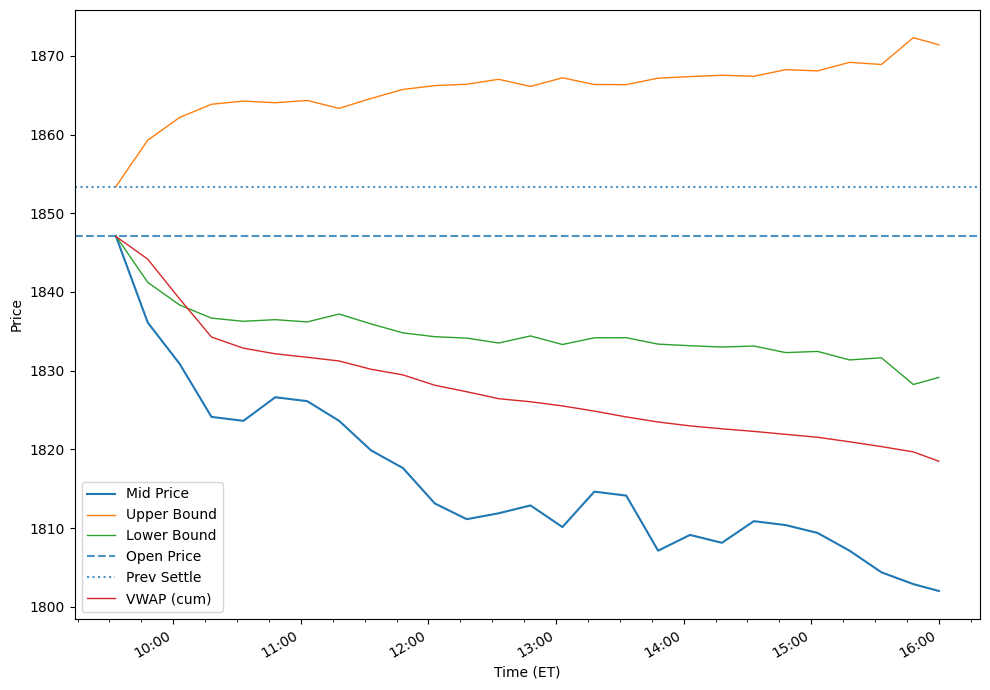

In [84]:
# Ensure Time is tz-aware ET
df["Time"] = pd.to_datetime(df["Time"], utc=True).dt.tz_convert("America/New_York")

# Define day as plain date (no tz needed)
day_str = "2010-07-16"
day = pd.to_datetime(day_str).date()

# Recompute day column in ET if not already done
df["day"] = df["Time"].dt.date

# Filter front-month contract for that day
one = df[(df['expiry_order'] == 1) & (df['day'] == day)].copy()
one = one.sort_values('Time')

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
x = one['Time']

ax.plot(x, one['price'], label='Mid Price')
if 'upper_bound' in one and one['upper_bound'].notna().any():
    ax.plot(x, one['upper_bound'], label='Upper Bound', linewidth=1)
if 'lower_bound' in one and one['lower_bound'].notna().any():
    ax.plot(x, one['lower_bound'], label='Lower Bound', linewidth=1)

if 'open_price' in one and one['open_price'].notna().any():
    ax.axhline(one['open_price'].iloc[0], linestyle='--', alpha=0.8, label='Open Price')
if 'settl_price_previous' in one and one['settl_price_previous'].notna().any():
    ax.axhline(one['settl_price_previous'].iloc[0], linestyle=':', alpha=0.8, label='Prev Settle')

if 'vwap_cum' in one.columns and one['vwap_cum'].notna().any():
    ax.plot(x, one['vwap_cum'], label='VWAP (cum)', linewidth=1)

# Tidy x-axis
import matplotlib.dates as mdates
from zoneinfo import ZoneInfo


tz = ZoneInfo("America/New_York")

ax.xaxis.set_major_locator(mdates.HourLocator(tz=tz))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45], tz=tz))

fig.autofmt_xdate()

ax.set_xlabel("Time (ET)")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()

In [85]:
backtest_one_day(df, "2010-07-16", 1, 100000)

Sold 82 shares at 1836.0 on 2010-07-16 at 09:48


102767.5

Bought 38 shares at 4213.75 on 2015-10-02 at 13:18
Sold 38 shares at 4205.75 on 2015-10-02 at 13:48
Bought 38 shares at 4217.75 on 2015-10-02 at 14:33
Sold 38 shares at 4213.0 on 2015-10-02 at 15:03
Bought 38 shares at 4237.0 on 2015-10-02 at 15:18
100256.5


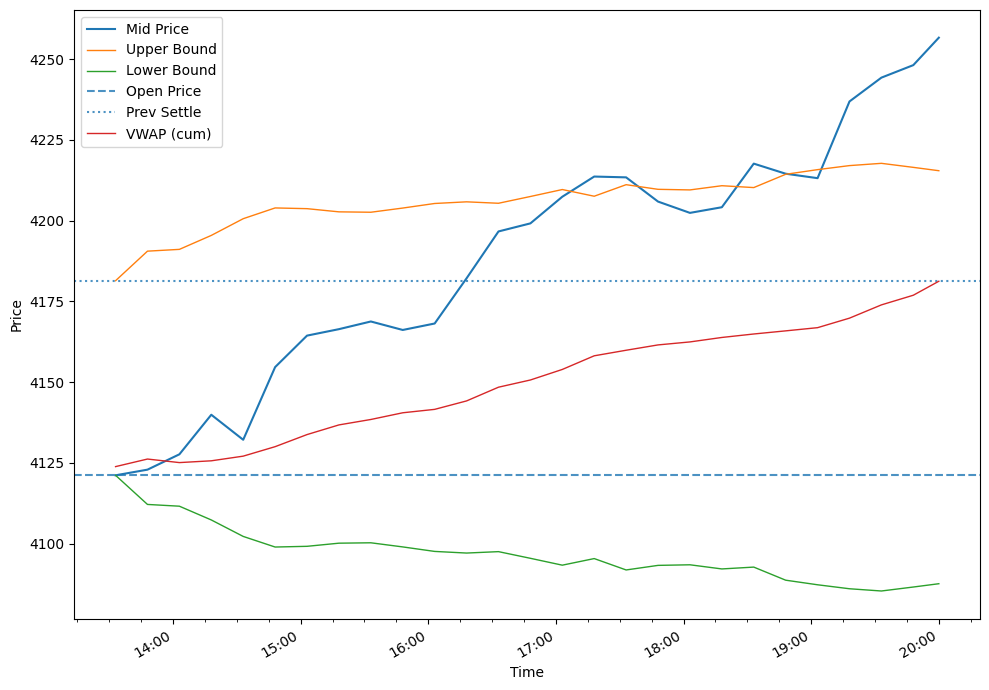

In [86]:
day_str = "2015-10-02"
day = pd.to_datetime(day_str).date()

print(backtest_one_day(df, day_str, 1, 100000))
one = df[(df['expiry_order'] == 1) & (df['day'] == day)].copy()
one = one.sort_values('Time')

fig, ax = plt.subplots(figsize=(10, 7))

x = one['Time']

ax.plot(x, one['price'], label='Mid Price')
if 'upper_bound' in one and one['upper_bound'].notna().any():
    ax.plot(x, one['upper_bound'], label='Upper Bound', linewidth=1)
if 'lower_bound' in one and one['lower_bound'].notna().any():
    ax.plot(x, one['lower_bound'], label='Lower Bound', linewidth=1)

# Horizontal lines for open and previous settlement
if 'open_price' in one and one['open_price'].notna().any():
    ax.axhline(one['open_price'].iloc[0], linestyle='--', alpha=0.8, label='Open Price')
if 'settl_price_previous' in one and one['settl_price_previous'].notna().any():
    ax.axhline(one['settl_price_previous'].iloc[0], linestyle=':', alpha=0.8, label='Prev Settle')

# Optional: VWAP
if 'vwap_cum' in one.columns and one['vwap_cum'].notna().any():
    ax.plot(x, one['vwap_cum'], label='VWAP (cum)', linewidth=1)

# Tidy x-axis: show one tick per hour, minor ticks at 15-min
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45]))
fig.autofmt_xdate()
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()

In [87]:
def backtest(backtest_df, rank_to_expiry, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        print(day_ts)
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

In [88]:
results = backtest(df, 1)
results

2010-06-07 00:00:00-04:00
2010-06-08 00:00:00-04:00
2010-06-09 00:00:00-04:00
2010-06-10 00:00:00-04:00
2010-06-11 00:00:00-04:00
2010-06-14 00:00:00-04:00
2010-06-15 00:00:00-04:00
2010-06-16 00:00:00-04:00
2010-06-17 00:00:00-04:00
2010-06-18 00:00:00-04:00
2010-06-21 00:00:00-04:00
2010-06-22 00:00:00-04:00
2010-06-23 00:00:00-04:00
2010-06-24 00:00:00-04:00
Sold 79 shares at 1855.0 on 2010-06-24 00:00:00-04:00 at 10:03
Bought 79 shares at 1857.5 on 2010-06-24 00:00:00-04:00 at 10:33
Sold 79 shares at 1853.5 on 2010-06-24 00:00:00-04:00 at 10:48
Bought 79 shares at 1856.5 on 2010-06-24 00:00:00-04:00 at 12:03
Sold 79 shares at 1853.75 on 2010-06-24 00:00:00-04:00 at 12:18
Bought 79 shares at 1859.0 on 2010-06-24 00:00:00-04:00 at 13:18
Sold 79 shares at 1840.25 on 2010-06-24 00:00:00-04:00 at 15:18
Bought 79 shares at 1844.75 on 2010-06-24 00:00:00-04:00 at 15:48
2010-06-25 00:00:00-04:00
Sold 88 shares at 1834.5 on 2010-06-25 00:00:00-04:00 at 09:48
Bought 88 shares at 1844.0 on 20

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 0 
 2010-06-07 00:00:00-04:00 
 100000.00 
 100000.00 
 0.0 
 0.000000 
 False 
 
 
 1 
 2010-06-08 00:00:00-04:00 
 100000.00 
 100000.00 
 0.0 
 0.000000 
 False 
 
 
 2 
 2010-06-09 00:00:00-04:00 
 100000.00 
 100000.00 
 0.0 
 0.000000 
 False 
 
 
 3 
 2010-06-10 00:00:00-04:00 
 100000.00 
 100000.00 
 0.0 
 0.000000 
 False 
 
 
 4 
 2010-06-11 00:00:00-04:00 
 100000.00 
 100000.00 
 0.0 
 0.000000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3738 
 2024-12-24 00:00:00-05:00 
 219293.25 
 222017.25 
 2724.0 
 0.012422 
 True 
 
 
 3739 
 2024-12-26 00:00:00-05:00 
 222017.25 
 222017.25 
 0.0 
 0.000000 
 False 
 
 
 3740 
 2024-12-27 00:00:00-05:00 
 222017.25 
 222957.25 
 940.0 
 0.004234 
 True 
 
 
 3741 
 2024-12-30 00:00:00-05:00 
 222957.25 
 223475.75 
 518.5 
 0.002326 
 True 
 
 
 3742 
 2024-12-31 00:00:00-05:00 
 223475.75 
 220223.75 
 -3252.0 
 -0.014552 
 True 
 
 
 
 3743 rows × 6 columns

In [89]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [90]:
evaluate_strategy(results)

{'total_return': 1.2022374999999998,
 'irr_annual': 0.0545897852302224,
 'vol_annual': 0.15833871376768047,
 'sharpe': 0.41429261020156816,
 'hit_ratio': 0.38930348258706465,
 'mdd': -0.39369256680225745,
 'n_days': 3743,
 'n_traded_days': 2412}

In [91]:
results.sort_values('return')

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 344 
 2011-10-04 00:00:00-04:00 
 74483.50 
 70882.00 
 -3601.50 
 -0.048353 
 True 
 
 
 2972 
 2022-01-06 00:00:00-05:00 
 140500.00 
 134569.00 
 -5931.00 
 -0.042214 
 True 
 
 
 187 
 2011-02-24 00:00:00-05:00 
 83842.25 
 80391.25 
 -3451.00 
 -0.041161 
 True 
 
 
 1590 
 2016-08-26 00:00:00-04:00 
 106571.75 
 102210.75 
 -4361.00 
 -0.040921 
 True 
 
 
 2890 
 2021-09-13 00:00:00-04:00 
 143066.25 
 137642.25 
 -5424.00 
 -0.037913 
 True 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1775 
 2017-05-17 00:00:00-04:00 
 95465.25 
 100285.75 
 4820.50 
 0.050495 
 True 
 
 
 2137 
 2018-10-10 00:00:00-04:00 
 127501.00 
 134105.75 
 6604.75 
 0.051802 
 True 
 
 
 1600 
 2016-09-09 00:00:00-04:00 
 99722.25 
 105173.25 
 5451.00 
 0.054662 
 True 
 
 
 877 
 2013-11-07 00:00:00-05:00 
 81504.75 
 85988.50 
 4483.75 
 0.055012 
 True 
 
 
 1792 
 2017-06-09 00:00:00-04:00 
 101777.00 
 107560.50 
 5783.50 
 0.056825 
 True 
 
 
 
 3743 rows × 6 columns

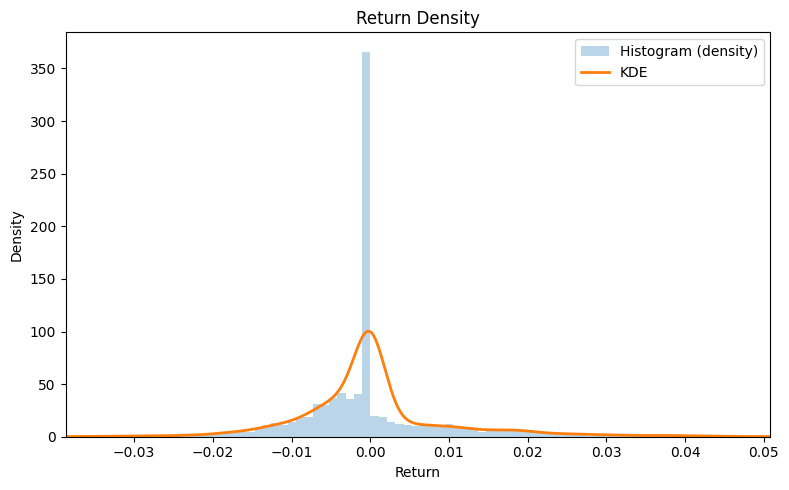

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clean the series
s = pd.Series(results['return'], dtype='float64')
s = s.replace([np.inf, -np.inf], np.nan).dropna()

fig, ax = plt.subplots(figsize=(8, 5))

# Density histogram
ax.hist(s, bins=100, density=True, alpha=0.3, label='Histogram (density)')

# KDE overlay (if scipy available)
try:
    from scipy.stats import gaussian_kde
    xs = np.linspace(s.quantile(0.001), s.quantile(0.999), 512)
    kde = gaussian_kde(s)
    ax.plot(xs, kde(xs), linewidth=2, label='KDE')
except Exception:
    # If scipy isn't installed, just skip the KDE
    pass

# Nice viewing window (doesn't affect density calc)
qlo, qhi = s.quantile([0.001, 0.999])
ax.set_xlim(qlo, qhi)

ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.set_title('Return Density')
ax.legend()
plt.tight_layout()
plt.show()

# Final strat

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

import datetime as dt

import matplotlib.dates as mdates

In [23]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash, sigma_target):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
                               .sort_values('Time')
                               .copy())
    backtest_df = backtest_df.sort_values('hour')

    # --- basic guards ---
    if backtest_df.empty:
        return initial_cash

    # Pull scalars safely
    ret_std = backtest_df['ret_std_14d'].iloc[0]
    open_price = backtest_df['open_price'].iloc[0]

    # Validate inputs used in floor(); avoid NaN / inf / nonpositive std or price
    if (not np.isfinite(ret_std)) or (ret_std <= 0) or (not np.isfinite(open_price)) or (open_price <= 0):
        total_shares_to_hold = 0
    else:
        lev = 1  # cap leverage at 4x
        sizing = initial_cash * lev / open_price
        total_shares_to_hold = int(np.floor(sizing)) if np.isfinite(sizing) and sizing > 0 else 0

    # Extract arrays
    bid_list     = backtest_df['bid_px_00'].to_numpy()
    ask_list     = backtest_df['ask_px_00'].to_numpy()
    upper_bound  = backtest_df['upper_bound'].to_numpy()
    lower_bound  = backtest_df['lower_bound'].to_numpy()
    vwap_list    = backtest_df['vwap_cum'].to_numpy()
    hour         = backtest_df['hour'].to_numpy()
    price_list   = backtest_df['price'].to_numpy()

    # Length / NaN checks
    n = len(bid_list)
    if not (len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound) == len(price_list) == n) or n == 0:
        return initial_cash

    # IMPORTANT: your previous NaN check added arrays together (elementwise sum).
    # Do proper per-array NaN checks:
    if (np.isnan(bid_list).any() or np.isnan(ask_list).any() or
        np.isnan(vwap_list).any() or np.isnan(upper_bound).any() or
        np.isnan(lower_bound).any() or np.isnan(price_list).any()):
        return initial_cash

    position = 0
    cash = float(initial_cash)

    for i in range(1, len(price_list) - 1):
        if price_list[i] > max(upper_bound[i], vwap_list[i]):
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * price_list[i] * 1.00001
                # print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] < min(vwap_list[i], lower_bound[i]):
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * price_list[i] * 0.99999
                # print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] >= min(vwap_list[i], lower_bound[i]) and max(upper_bound[i], vwap_list[i]) >= ask_list[i]:
            # we must close our position
            if position > 0: # we are long so we need to sell
                initial_cash += position * price_list[i] * 0.99999
                # print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
                position = 0
            elif position < 0: # we are short so we need to buy
                initial_cash -= abs(position) * price_list[i] * 1.00001
                # print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
                position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * price_list[-1] * 0.99999
        position = 0

    elif position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * price_list[-1] * 1.00001
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

In [24]:
def backtest(backtest_df, rank_to_expiry, sigma_target, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash, sigma_target)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

# backtest(df, rank_to_expiry = 1, sigma_target=0.02, initial_cash=100_000)

In [25]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization, sigma_leverage_period, sigma_leverage_bound, sigma_target):

    df = pd.read_csv('/data/workspace_files/nasdaq.csv')
    df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # (Optional) drop bad rows
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST)
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')

    # Build hour/day AFTER conversion
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date

    # Keep only US RTH 09:30–16:00 ET
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Sanity check (optional)
    tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()

    ### order by symbol, hour and day
    df = df.sort_values(['symbol', 'hour', 'day'])

    ### price
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


    ### opening price
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


    # settling price and previous day settling price
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
        .groupby(['symbol','day'])['price']
        .last()
        .rename('settl_price')
    )

    prev_settle = (
        daily_settle.groupby(level='symbol')
                    .shift(1)
                    .rename('settl_price_previous')
    )

    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])


    ### move since opening
    df["move"] = np.where(
        df["open_price"] > 0,
        np.abs(df["price"] / df["open_price"] - 1),
        np.nan
    )


    ### compute mean of move over the last period
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
        .transform(lambda x: x.rolling(sigma_leverage_bound, min_periods=sigma_leverage_bound).mean())
    )


    ### compute upper bound
    df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + coef_sigma * df['sigma_observed']) + percentage_penalization * df['open_price']


    ### compute lower bound
    df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - coef_sigma * df['sigma_observed']) - percentage_penalization * df['open_price']


    ### get return
    df['return'] = df['settl_price']/df['open_price'] - 1


    ### get variance onf returns among the last 14 days
    daily = (df.sort_values(['symbol','day'])
            .groupby(['symbol','day'], as_index=False)['return'].last())

    daily[f'ret_std_14d'] = (
        daily.groupby('symbol')['return']
            .transform(lambda s: s.rolling(sigma_leverage_period, min_periods=sigma_leverage_period).std())
    )

    df = df.merge(daily[['symbol','day', f'ret_std_14d']], on=['symbol','day'], how='left')


    df = df.sort_values(['symbol', 'day', 'hour'])

    results = backtest(df, 1, sigma_target)

    return results


In [26]:
results = backtest_with_hyperparameters(0.5, 0.002, 14, 14, 0.2)
results

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 0 
 2010-06-07 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 1 
 2010-06-08 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 2 
 2010-06-09 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 3 
 2010-06-10 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 4 
 2010-06-11 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3738 
 2024-12-24 00:00:00-05:00 
 375872.516755 
 378089.918236 
 2217.401481 
 0.005899 
 True 
 
 
 3739 
 2024-12-26 00:00:00-05:00 
 378089.918236 
 378089.918236 
 0.000000 
 0.000000 
 False 
 
 
 3740 
 2024-12-27 00:00:00-05:00 
 378089.918236 
 379093.073425 
 1003.155189 
 0.002653 
 True 
 
 
 3741 
 2024-12-30 00:00:00-05:00 
 379093.073425 
 378720.321267 
 -372.752158 
 -0.000983 
 True 
 
 
 3742 
 2024-12-31 00:00:00-05:00 
 378720.321267 
 377592.755574 
 -1127.565694 
 -0.002977 
 True 
 
 
 
 3743 rows × 6 columns

In [27]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [28]:
evaluate_strategy(results)

{'total_return': 2.77592755573733,
 'irr_annual': 0.09357483221743235,
 'vol_annual': 0.08155040941442078,
 'sharpe': 1.1376730719827486,
 'hit_ratio': 0.4264705882352941,
 'mdd': -0.1516056300345067,
 'n_days': 3743,
 'n_traded_days': 2312}

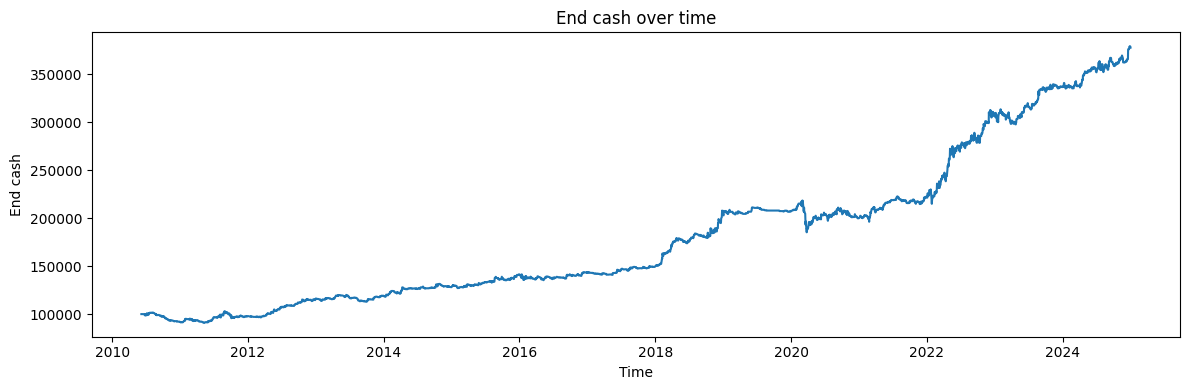

In [29]:
s = results.copy()

# sp_df = pd.read_csv("/data/workspace_files/SP500.csv")
# sp_df['SP500'] = 189095.59434874536 * sp_df['SP500'] / 1938.76
# sp_df

# If you have a Time column, make it the datetime index
if "Time" in s.columns:
    s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
    s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

# if "observation_date" in sp_df.columns:
#     sp_df["observation_date"] = pd.to_datetime(sp_df["observation_date"], errors="coerce")
#     sp_df = sp_df.dropna(subset=["observation_date"]).sort_values("observation_date").set_index("observation_date")

# Plot end_cash over time
plt.figure(figsize=(12,4))
plt.plot(s.date, s["end_cash"].astype(float))
# plt.plot(sp_df['SP500'].astype(float))
plt.title("End cash over time")
plt.xlabel("Time")
plt.ylabel("End cash")
plt.tight_layout()
plt.show()

# Positive momentum

# only positive momentum

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

import datetime as dt

import matplotlib.dates as mdates

In [121]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization, sigma_leverage_period, sigma_leverage_bound, sigma_target):

    df = pd.read_csv('/data/workspace_files/nasdaq.csv')
    df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # (Optional) drop bad rows
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST)
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')

    # Build hour/day AFTER conversion
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date

    # Keep only US RTH 09:30–16:00 ET
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Sanity check (optional)
    tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()

    ### order by symbol, hour and day
    df = df.sort_values(['symbol', 'hour', 'day'])

    ### price
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


    ### opening price
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


    # settling price and previous day settling price
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
        .groupby(['symbol','day'])['price']
        .last()
        .rename('settl_price')
    )

    prev_settle = (
        daily_settle.groupby(level='symbol')
                    .shift(1)
                    .rename('settl_price_previous')
    )

    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])


    ### move since opening
    df["move"] = np.where(
        df["open_price"] > 0,
        np.abs(df["price"] / df["open_price"] - 1),
        np.nan
    )


    ### compute mean of move over the last period
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
        .transform(lambda x: x.rolling(sigma_leverage_bound, min_periods=sigma_leverage_bound).mean())
    )


    ### compute upper bound
    df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + coef_sigma * df['sigma_observed']) + percentage_penalization * df['open_price']


    ### compute lower bound
    df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - coef_sigma * df['sigma_observed']) - percentage_penalization * df['open_price']


    ### get return
    df['return'] = df['settl_price']/df['open_price'] - 1


    ### get variance onf returns among the last 14 days
    daily = (df.sort_values(['symbol','day'])
            .groupby(['symbol','day'], as_index=False)['return'].last())

    daily[f'ret_std_14d'] = (
        daily.groupby('symbol')['return']
            .transform(lambda s: s.rolling(sigma_leverage_period, min_periods=sigma_leverage_period).std())
    )

    df = df.merge(daily[['symbol','day', f'ret_std_14d']], on=['symbol','day'], how='left')


    df = df.sort_values(['symbol', 'day', 'hour'])

    results = backtest(df, 1, sigma_target)

    return results


In [122]:
def backtest(backtest_df, rank_to_expiry, sigma_target, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash, sigma_target)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

# backtest(df, rank_to_expiry = 1, sigma_target=0.02, initial_cash=100_000)

In [123]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash, sigma_target):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
                               .sort_values('Time')
                               .copy())
    backtest_df = backtest_df.sort_values('hour')

    # --- basic guards ---
    if backtest_df.empty:
        return initial_cash

    # Pull scalars safely
    ret_std = backtest_df['ret_std_14d'].iloc[0]
    open_price = backtest_df['open_price'].iloc[0]

    # Validate inputs used in floor(); avoid NaN / inf / nonpositive std or price
    if (not np.isfinite(ret_std)) or (ret_std <= 0) or (not np.isfinite(open_price)) or (open_price <= 0):
        total_shares_to_hold = 0
    else:
        lev = 1  # cap leverage at 4x
        sizing = initial_cash * lev / open_price
        total_shares_to_hold = int(np.floor(sizing)) if np.isfinite(sizing) and sizing > 0 else 0

    # Extract arrays
    bid_list     = backtest_df['bid_px_00'].to_numpy()
    ask_list     = backtest_df['ask_px_00'].to_numpy()
    upper_bound  = backtest_df['upper_bound'].to_numpy()
    lower_bound  = backtest_df['lower_bound'].to_numpy()
    vwap_list    = backtest_df['vwap_cum'].to_numpy()
    hour         = backtest_df['hour'].to_numpy()
    price_list   = backtest_df['price'].to_numpy()

    # Length / NaN checks
    n = len(bid_list)
    if not (len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound) == len(price_list) == n) or n == 0:
        return initial_cash

    # IMPORTANT: your previous NaN check added arrays together (elementwise sum).
    # Do proper per-array NaN checks:
    if (np.isnan(bid_list).any() or np.isnan(ask_list).any() or
        np.isnan(vwap_list).any() or np.isnan(upper_bound).any() or
        np.isnan(lower_bound).any() or np.isnan(price_list).any()):
        return initial_cash

    position = 0
    cash = float(initial_cash)

    for i in range(1, len(price_list) - 1):
        if price_list[i] > max(upper_bound[i], vwap_list[i]):
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * price_list[i] * 1.00001
                # print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        # elif price_list[i] < min(vwap_list[i], lower_bound[i]):
        #     # we must be short and sell more than what we already have
        #     if -total_shares_to_hold < position:
        #         shares_to_sell = position + total_shares_to_hold
        #         position -= shares_to_sell
        #         initial_cash += shares_to_sell * price_list[i] * 0.99999
        #         # print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        else:
            # we must close our position
            if position > 0: # we are long so we need to sell
                initial_cash += position * price_list[i] * 0.99999
                # print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
                position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * price_list[-1] * 0.99999
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

In [124]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization, sigma_leverage_period, sigma_leverage_bound, sigma_target):

    df = pd.read_csv('/data/workspace_files/nasdaq.csv')
    df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # (Optional) drop bad rows
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST)
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')

    # Build hour/day AFTER conversion
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date

    # Keep only US RTH 09:30–16:00 ET
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Sanity check (optional)
    tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()

    ### order by symbol, hour and day
    df = df.sort_values(['symbol', 'hour', 'day'])

    ### price
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


    ### opening price
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


    # settling price and previous day settling price
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
        .groupby(['symbol','day'])['price']
        .last()
        .rename('settl_price')
    )

    prev_settle = (
        daily_settle.groupby(level='symbol')
                    .shift(1)
                    .rename('settl_price_previous')
    )

    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])


    ### move since opening
    df["move"] = np.where(
        df["open_price"] > 0,
        np.abs(df["price"] / df["open_price"] - 1),
        np.nan
    )


    ### compute mean of move over the last period
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
        .transform(lambda x: x.rolling(sigma_leverage_bound, min_periods=sigma_leverage_bound).mean())
    )


    ### compute upper bound
    df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + coef_sigma * df['sigma_observed']) + percentage_penalization * df['open_price']


    ### compute lower bound
    df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - coef_sigma * df['sigma_observed']) - percentage_penalization * df['open_price']


    ### get return
    df['return'] = df['settl_price']/df['open_price'] - 1


    ### get variance onf returns among the last 14 days
    daily = (df.sort_values(['symbol','day'])
            .groupby(['symbol','day'], as_index=False)['return'].last())

    daily[f'ret_std_14d'] = (
        daily.groupby('symbol')['return']
            .transform(lambda s: s.rolling(sigma_leverage_period, min_periods=sigma_leverage_period).std())
    )

    df = df.merge(daily[['symbol','day', f'ret_std_14d']], on=['symbol','day'], how='left')


    df = df.sort_values(['symbol', 'day', 'hour'])

    results = backtest(df, 1, sigma_target)

    return results


In [125]:
results = backtest_with_hyperparameters(0.5, 0.002, 14, 14, 0.2)
results

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 0 
 2010-06-07 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 1 
 2010-06-08 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 2 
 2010-06-09 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 3 
 2010-06-10 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 4 
 2010-06-11 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3738 
 2024-12-24 00:00:00-05:00 
 246798.848844 
 248233.638037 
 1434.789194 
 0.005814 
 True 
 
 
 3739 
 2024-12-26 00:00:00-05:00 
 248233.638037 
 248233.638037 
 0.000000 
 0.000000 
 False 
 
 
 3740 
 2024-12-27 00:00:00-05:00 
 248233.638037 
 248233.638037 
 0.000000 
 0.000000 
 False 
 
 
 3741 
 2024-12-30 00:00:00-05:00 
 248233.638037 
 248233.638037 
 0.000000 
 0.000000 
 False 
 
 
 3742 
 2024-12-31 00:00:00-05:00 
 248233.638037 
 248233.638037 
 0.000000 
 0.000000 
 False 
 
 
 
 3743 rows × 6 columns

In [126]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [127]:
evaluate_strategy(results)

{'total_return': 1.482336380374937,
 'irr_annual': 0.06312482246920781,
 'vol_annual': 0.051355188095698494,
 'sharpe': 1.2176129210070048,
 'hit_ratio': 0.4423380726698262,
 'mdd': -0.06261665510758299,
 'n_days': 3743,
 'n_traded_days': 1266}

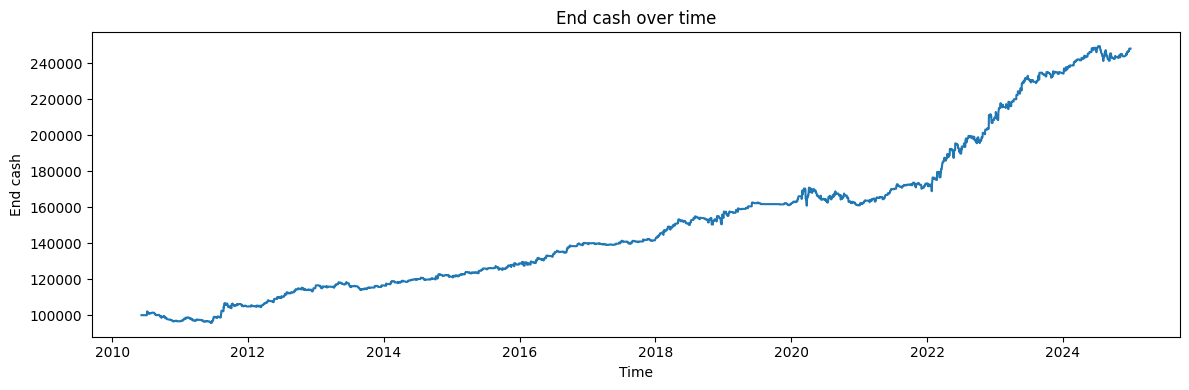

In [128]:
s = results.copy()

sp_df = pd.read_csv("/data/workspace_files/SP500.csv")
sp_df['SP500'] = 0
sp_df

# If you have a Time column, make it the datetime index
if "Time" in s.columns:
    s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
    s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

if "observation_date" in sp_df.columns:
    sp_df["observation_date"] = pd.to_datetime(sp_df["observation_date"], errors="coerce")
    sp_df = sp_df.dropna(subset=["observation_date"]).sort_values("observation_date").set_index("observation_date")

# Plot end_cash over time
plt.figure(figsize=(12,4))
plt.plot(s.date, s["end_cash"].astype(float))
plt.title("End cash over time")
plt.xlabel("Time")
plt.ylabel("End cash")
plt.tight_layout()
plt.show()

# Negative momentum

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

import datetime as dt

import matplotlib.dates as mdates

In [130]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization, sigma_leverage_period, sigma_leverage_bound, sigma_target):

    df = pd.read_csv('/data/workspace_files/nasdaq.csv')
    df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # (Optional) drop bad rows
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST)
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')

    # Build hour/day AFTER conversion
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date

    # Keep only US RTH 09:30–16:00 ET
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Sanity check (optional)
    tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()

    ### order by symbol, hour and day
    df = df.sort_values(['symbol', 'hour', 'day'])

    ### price
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


    ### opening price
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


    # settling price and previous day settling price
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
        .groupby(['symbol','day'])['price']
        .last()
        .rename('settl_price')
    )

    prev_settle = (
        daily_settle.groupby(level='symbol')
                    .shift(1)
                    .rename('settl_price_previous')
    )

    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])


    ### move since opening
    df["move"] = np.where(
        df["open_price"] > 0,
        np.abs(df["price"] / df["open_price"] - 1),
        np.nan
    )


    ### compute mean of move over the last period
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
        .transform(lambda x: x.rolling(sigma_leverage_bound, min_periods=sigma_leverage_bound).mean())
    )


    ### compute upper bound
    df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + coef_sigma * df['sigma_observed']) + percentage_penalization * df['open_price']


    ### compute lower bound
    df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - coef_sigma * df['sigma_observed']) - percentage_penalization * df['open_price']


    ### get return
    df['return'] = df['settl_price']/df['open_price'] - 1


    ### get variance onf returns among the last 14 days
    daily = (df.sort_values(['symbol','day'])
            .groupby(['symbol','day'], as_index=False)['return'].last())

    daily[f'ret_std_14d'] = (
        daily.groupby('symbol')['return']
            .transform(lambda s: s.rolling(sigma_leverage_period, min_periods=sigma_leverage_period).std())
    )

    df = df.merge(daily[['symbol','day', f'ret_std_14d']], on=['symbol','day'], how='left')


    df = df.sort_values(['symbol', 'day', 'hour'])

    results = backtest(df, 1, sigma_target)

    return results


In [131]:
def backtest(backtest_df, rank_to_expiry, sigma_target, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash, sigma_target)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

# backtest(df, rank_to_expiry = 1, sigma_target=0.02, initial_cash=100_000)

In [132]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash, sigma_target):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
                               .sort_values('Time')
                               .copy())
    backtest_df = backtest_df.sort_values('hour')

    # --- basic guards ---
    if backtest_df.empty:
        return initial_cash

    # Pull scalars safely
    ret_std = backtest_df['ret_std_14d'].iloc[0]
    open_price = backtest_df['open_price'].iloc[0]

    # Validate inputs used in floor(); avoid NaN / inf / nonpositive std or price
    if (not np.isfinite(ret_std)) or (ret_std <= 0) or (not np.isfinite(open_price)) or (open_price <= 0):
        total_shares_to_hold = 0
    else:
        lev = 1  # cap leverage at 4x
        sizing = initial_cash * lev / open_price
        total_shares_to_hold = int(np.floor(sizing)) if np.isfinite(sizing) and sizing > 0 else 0

    # Extract arrays
    bid_list     = backtest_df['bid_px_00'].to_numpy()
    ask_list     = backtest_df['ask_px_00'].to_numpy()
    upper_bound  = backtest_df['upper_bound'].to_numpy()
    lower_bound  = backtest_df['lower_bound'].to_numpy()
    vwap_list    = backtest_df['vwap_cum'].to_numpy()
    hour         = backtest_df['hour'].to_numpy()
    price_list   = backtest_df['price'].to_numpy()

    # Length / NaN checks
    n = len(bid_list)
    if not (len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound) == len(price_list) == n) or n == 0:
        return initial_cash

    # IMPORTANT: your previous NaN check added arrays together (elementwise sum).
    # Do proper per-array NaN checks:
    if (np.isnan(bid_list).any() or np.isnan(ask_list).any() or
        np.isnan(vwap_list).any() or np.isnan(upper_bound).any() or
        np.isnan(lower_bound).any() or np.isnan(price_list).any()):
        return initial_cash

    position = 0
    cash = float(initial_cash)

    for i in range(1, len(price_list) - 1):
        if price_list[i] < min(vwap_list[i], lower_bound[i]):
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * price_list[i] * 0.99999
                # print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        else:
            if position < 0: # we are short so we need to buy
                initial_cash -= abs(position) * price_list[i] * 1.00001
                # print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
                position = 0

    if position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * price_list[-1] * 1.00001
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

In [133]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization, sigma_leverage_period, sigma_leverage_bound, sigma_target):

    df = pd.read_csv('/data/workspace_files/nasdaq.csv')
    df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # (Optional) drop bad rows
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST)
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')

    # Build hour/day AFTER conversion
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date

    # Keep only US RTH 09:30–16:00 ET
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Sanity check (optional)
    tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()

    ### order by symbol, hour and day
    df = df.sort_values(['symbol', 'hour', 'day'])

    ### price
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


    ### opening price
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


    # settling price and previous day settling price
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
        .groupby(['symbol','day'])['price']
        .last()
        .rename('settl_price')
    )

    prev_settle = (
        daily_settle.groupby(level='symbol')
                    .shift(1)
                    .rename('settl_price_previous')
    )

    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])


    ### move since opening
    df["move"] = np.where(
        df["open_price"] > 0,
        np.abs(df["price"] / df["open_price"] - 1),
        np.nan
    )


    ### compute mean of move over the last period
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
        .transform(lambda x: x.rolling(sigma_leverage_bound, min_periods=sigma_leverage_bound).mean())
    )


    ### compute upper bound
    df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + coef_sigma * df['sigma_observed']) + percentage_penalization * df['open_price']


    ### compute lower bound
    df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - coef_sigma * df['sigma_observed']) - percentage_penalization * df['open_price']


    ### get return
    df['return'] = df['settl_price']/df['open_price'] - 1


    ### get variance onf returns among the last 14 days
    daily = (df.sort_values(['symbol','day'])
            .groupby(['symbol','day'], as_index=False)['return'].last())

    daily[f'ret_std_14d'] = (
        daily.groupby('symbol')['return']
            .transform(lambda s: s.rolling(sigma_leverage_period, min_periods=sigma_leverage_period).std())
    )

    df = df.merge(daily[['symbol','day', f'ret_std_14d']], on=['symbol','day'], how='left')


    df = df.sort_values(['symbol', 'day', 'hour'])

    results = backtest(df, 1, sigma_target)

    return results


In [134]:
results = backtest_with_hyperparameters(0.5, 0.002, 14, 14, 0.2)
results

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 0 
 2010-06-07 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 1 
 2010-06-08 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 2 
 2010-06-09 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 3 
 2010-06-10 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 4 
 2010-06-11 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3738 
 2024-12-24 00:00:00-05:00 
 151938.417164 
 151938.417164 
 0.000000 
 0.000000 
 False 
 
 
 3739 
 2024-12-26 00:00:00-05:00 
 151938.417164 
 151938.417164 
 0.000000 
 0.000000 
 False 
 
 
 3740 
 2024-12-27 00:00:00-05:00 
 151938.417164 
 152292.471936 
 354.054773 
 0.002330 
 True 
 
 
 3741 
 2024-12-30 00:00:00-05:00 
 152292.471936 
 152138.985754 
 -153.486182 
 -0.001008 
 True 
 
 
 3742 
 2024-12-31 00:00:00-05:00 
 152138.985754 
 151674.693997 
 -464.291756 
 -0.003052 
 True 
 
 
 
 3743 rows × 6 columns

In [135]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [136]:
evaluate_strategy(results)

{'total_return': 0.5167469399749711,
 'irr_annual': 0.028442696429518577,
 'vol_annual': 0.0624866449879369,
 'sharpe': 0.4799261828451119,
 'hit_ratio': 0.38054607508532423,
 'mdd': -0.14388989690194934,
 'n_days': 3743,
 'n_traded_days': 1172}

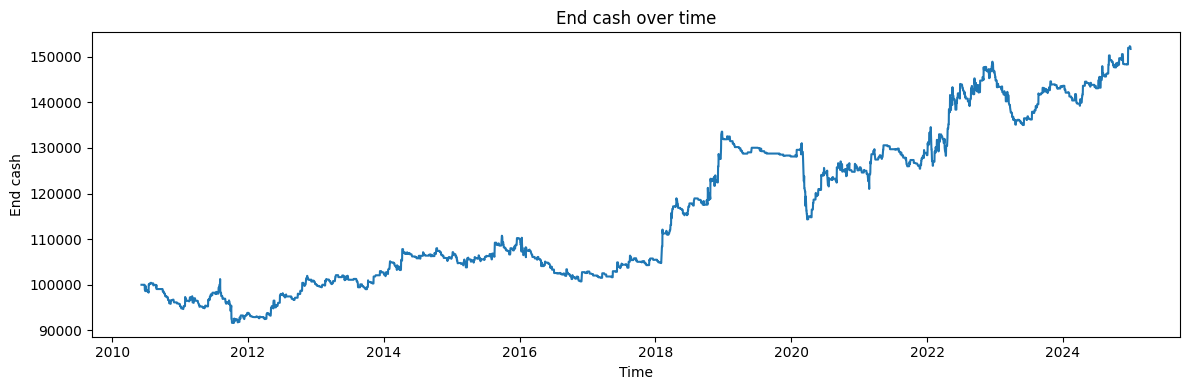

In [137]:
s = results.copy()

sp_df = pd.read_csv("/data/workspace_files/SP500.csv")
sp_df['SP500'] = 0
sp_df

# If you have a Time column, make it the datetime index
if "Time" in s.columns:
    s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
    s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

if "observation_date" in sp_df.columns:
    sp_df["observation_date"] = pd.to_datetime(sp_df["observation_date"], errors="coerce")
    sp_df = sp_df.dropna(subset=["observation_date"]).sort_values("observation_date").set_index("observation_date")

# Plot end_cash over time
plt.figure(figsize=(12,4))
plt.plot(s.date, s["end_cash"].astype(float))
plt.title("End cash over time")
plt.xlabel("Time")
plt.ylabel("End cash")
plt.tight_layout()
plt.show()

# VIX conditioning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

import datetime as dt

import matplotlib.dates as mdates

# volatility lower threshold

In [30]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization,
                                  sigma_leverage_period, sigma_leverage_bound, sigma_target, VIX_treshold):

    # ---------- Load & prepare intraday data ----------
    df = pd.read_csv('/data/workspace_files/nasdaq.csv',
                     usecols=['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum'])

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST) and build hour/day on NY time
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date        # <-- keep as datetime.date (DO NOT stringify)

    # US RTH 09:30–16:00 ET
    import datetime as dt
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Order & mid price
    df = df.sort_values(['symbol', 'hour', 'day'])
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])

    # Opening price per symbol-day
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')

    # Settle and previous settle (per symbol/day)
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
          .groupby(['symbol','day'])['price'].last()
          .rename('settl_price')
    )
    prev_settle = (
        daily_settle.groupby(level='symbol').shift(1).rename('settl_price_previous')
    )
    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])

    # Intraday move vs open
    df['move'] = np.where(
        df['open_price'] > 0,
        np.abs(df['price'] / df['open_price'] - 1),
        np.nan
    )

    # Rolling mean of move by (symbol, hour)
    win = int(sigma_leverage_bound) if sigma_leverage_bound is not None else 1
    if win < 1:
        win = 1
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
          .transform(lambda x: x.rolling(win, min_periods=win).mean())
    )

    # Bands
    df['upper_bound'] = df[['open_price','settl_price_previous']].max(axis=1) * (1 + coef_sigma * df['sigma_observed']) \
                        + percentage_penalization * df['open_price']
    df['lower_bound'] = df[['open_price','settl_price_previous']].min(axis=1) * (1 - coef_sigma * df['sigma_observed']) \
                        - percentage_penalization * df['open_price']

    # End-of-day return
    df['return'] = df['settl_price'] / df['open_price'] - 1

    # 14D rolling std of returns per symbol
    daily = (df.sort_values(['symbol','day'])
               .groupby(['symbol','day'], as_index=False)['return'].last())
    daily['ret_std_14d'] = (
        daily.groupby('symbol')['return']
             .transform(lambda s: s.rolling(int(sigma_leverage_period), min_periods=int(sigma_leverage_period)).std())
    )
    df = df.merge(daily[['symbol','day','ret_std_14d']], on=['symbol','day'], how='left')

    df = df.sort_values(['symbol', 'day', 'hour'])

    # ---------- Load & merge VIX (daily) ----------
    vol_df = pd.read_csv('/data/workspace_files/VIX_History.csv', usecols=['DATE', 'CLOSE'])
    vol_df = vol_df.rename(columns={'DATE':'day', 'CLOSE':'VIX'})

    # Parse to timezone-naive dates and shift by one day (use yesterday's VIX)
    vol_df['day'] = pd.to_datetime(vol_df['day'], format='%m/%d/%Y', errors='coerce').dt.date
    vol_df = vol_df.dropna(subset=['day'])
    vol_df = vol_df.sort_values('day')
    vol_df['VIX'] = pd.to_numeric(vol_df['VIX'], errors='coerce').shift(1)

    # Ensure unique per-day (take last if duplicates)
    vol_df = vol_df.groupby('day', as_index=False).last()

    # Some trading days may not have VIX (holidays). Build a calendar from df['day'] and ffill VIX.
    all_days = pd.DataFrame({'day': sorted(df['day'].unique())})
    vol_df = all_days.merge(vol_df, on='day', how='left').sort_values('day')
    vol_df['VIX'] = vol_df['VIX'].ffill()

    # Merge back (left join; broadcasts daily VIX to intraday rows)
    df = df.merge(vol_df, on='day', how='left')

    # ---------- Run backtest ----------
    results = backtest(df, 1, sigma_target, VIX_treshold)
    return results

In [32]:
def backtest(backtest_df, rank_to_expiry, sigma_target, VIX_treshold, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash, sigma_target, VIX_treshold)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

# backtest(df, rank_to_expiry = 1, sigma_target=0.02, initial_cash=100_000)

In [33]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash, sigma_target, VIX_treshold):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
                               .sort_values('Time')
                               .copy())
    backtest_df = backtest_df.sort_values('hour')

    if backtest_df['VIX'].iloc[0] < VIX_treshold:
        return initial_cash

    # --- basic guards ---
    if backtest_df.empty:
        return initial_cash

    # Pull scalars safely
    ret_std = backtest_df['ret_std_14d'].iloc[0]
    open_price = backtest_df['open_price'].iloc[0]

    # Validate inputs used in floor(); avoid NaN / inf / nonpositive std or price
    if (not np.isfinite(ret_std)) or (ret_std <= 0) or (not np.isfinite(open_price)) or (open_price <= 0):
        total_shares_to_hold = 0
    else:
        lev = 1  # cap leverage at 4x
        sizing = initial_cash * lev / open_price
        total_shares_to_hold = int(np.floor(sizing)) if np.isfinite(sizing) and sizing > 0 else 0

    # Extract arrays
    bid_list     = backtest_df['bid_px_00'].to_numpy()
    ask_list     = backtest_df['ask_px_00'].to_numpy()
    upper_bound  = backtest_df['upper_bound'].to_numpy()
    lower_bound  = backtest_df['lower_bound'].to_numpy()
    vwap_list    = backtest_df['vwap_cum'].to_numpy()
    hour         = backtest_df['hour'].to_numpy()
    price_list   = backtest_df['price'].to_numpy()

    # Length / NaN checks
    n = len(bid_list)
    if not (len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound) == len(price_list) == n) or n == 0:
        return initial_cash

    # IMPORTANT: your previous NaN check added arrays together (elementwise sum).
    # Do proper per-array NaN checks:
    if (np.isnan(bid_list).any() or np.isnan(ask_list).any() or
        np.isnan(vwap_list).any() or np.isnan(upper_bound).any() or
        np.isnan(lower_bound).any() or np.isnan(price_list).any()):
        return initial_cash

    position = 0
    cash = float(initial_cash)



    for i in range(1, len(price_list) - 1):
        if price_list[i] > max(upper_bound[i], vwap_list[i]):
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * price_list[i] * 1.00001
                # print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] < min(vwap_list[i], lower_bound[i]):
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * price_list[i] * 0.99999
                # print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] >= min(vwap_list[i], lower_bound[i]) and max(upper_bound[i], vwap_list[i]) >= ask_list[i]:
            # we must close our position
            if position > 0: # we are long so we need to sell
                initial_cash += position * price_list[i] * 0.99999
                # print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
                position = 0
            elif position < 0: # we are short so we need to buy
                initial_cash -= abs(position) * price_list[i] * 1.00001
                # print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
                position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * price_list[-1] * 0.99999
        position = 0

    elif position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * price_list[-1] * 1.00001
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

In [34]:
results = backtest_with_hyperparameters(0.5, 0.002, 14, 14, 0.2, 0)
results

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 0 
 2010-06-07 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 1 
 2010-06-08 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 2 
 2010-06-09 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 3 
 2010-06-10 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 4 
 2010-06-11 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3738 
 2024-12-24 00:00:00-05:00 
 375872.516755 
 378089.918236 
 2217.401481 
 0.005899 
 True 
 
 
 3739 
 2024-12-26 00:00:00-05:00 
 378089.918236 
 378089.918236 
 0.000000 
 0.000000 
 False 
 
 
 3740 
 2024-12-27 00:00:00-05:00 
 378089.918236 
 379093.073425 
 1003.155189 
 0.002653 
 True 
 
 
 3741 
 2024-12-30 00:00:00-05:00 
 379093.073425 
 378720.321267 
 -372.752158 
 -0.000983 
 True 
 
 
 3742 
 2024-12-31 00:00:00-05:00 
 378720.321267 
 377592.755574 
 -1127.565694 
 -0.002977 
 True 
 
 
 
 3743 rows × 6 columns

In [35]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [36]:
evaluate_strategy(results)

{'total_return': 2.77592755573733,
 'irr_annual': 0.09357483221743235,
 'vol_annual': 0.08155040941442078,
 'sharpe': 1.1376730719827486,
 'hit_ratio': 0.4264705882352941,
 'mdd': -0.1516056300345067,
 'n_days': 3743,
 'n_traded_days': 2312}

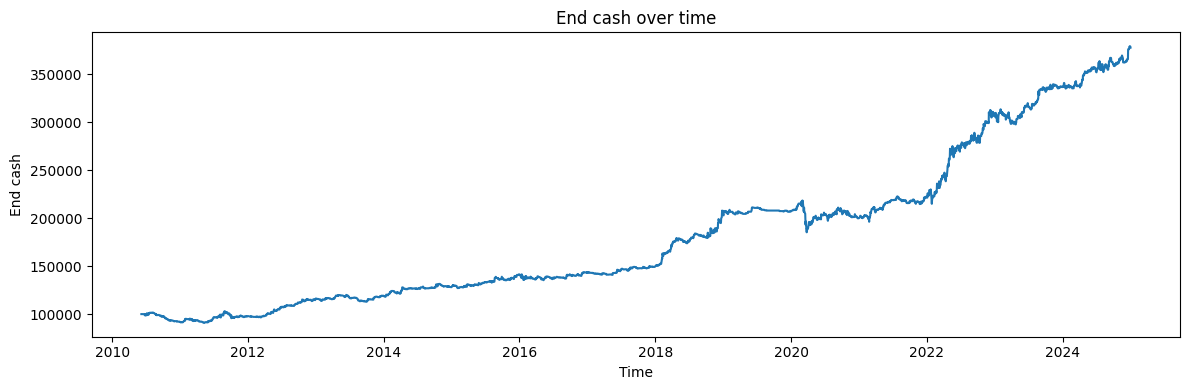

In [37]:
s = results.copy()

sp_df = pd.read_csv("/data/workspace_files/SP500.csv")
sp_df['SP500'] = 189095.59434874536 * sp_df['SP500'] / 1938.76
sp_df

# If you have a Time column, make it the datetime index
if "Time" in s.columns:
    s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
    s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

if "observation_date" in sp_df.columns:
    sp_df["observation_date"] = pd.to_datetime(sp_df["observation_date"], errors="coerce")
    sp_df = sp_df.dropna(subset=["observation_date"]).sort_values("observation_date").set_index("observation_date")

# Plot end_cash over time
plt.figure(figsize=(12,4))
plt.plot(s.date, s["end_cash"].astype(float))
# plt.plot(sp_df['SP500'].astype(float))
plt.plot
plt.title("End cash over time")
plt.xlabel("Time")
plt.ylabel("End cash")
plt.tight_layout()
plt.show()

Results for VIX treshold: 0
{'total_return': 2.77592755573733, 'irr_annual': 0.09357483221743235, 'vol_annual': 0.08155040941442078, 'sharpe': 1.1376730719827486, 'hit_ratio': 0.4264705882352941, 'mdd': -0.1516056300345067, 'n_days': 3743, 'n_traded_days': 2312}
Results for VIX treshold: 10
{'total_return': 2.751834151449839, 'irr_annual': 0.09310363857277038, 'vol_annual': 0.08155774898607082, 'sharpe': 1.1322882603749735, 'hit_ratio': 0.4248908296943231, 'mdd': -0.15030447836500585, 'n_days': 3743, 'n_traded_days': 2290}
Results for VIX treshold: 12
{'total_return': 2.489806535499853, 'irr_annual': 0.08778850998450594, 'vol_annual': 0.08055417358603208, 'sharpe': 1.0848623234185482, 'hit_ratio': 0.42705447830101567, 'mdd': -0.15003877124541873, 'n_days': 3743, 'n_traded_days': 2166}
Results for VIX treshold: 14
{'total_return': 1.9949789835623912, 'irr_annual': 0.07664749073291088, 'vol_annual': 0.07748759511937, 'sharpe': 0.991783507217941, 'hit_ratio': 0.43304843304843305, 'mdd': -

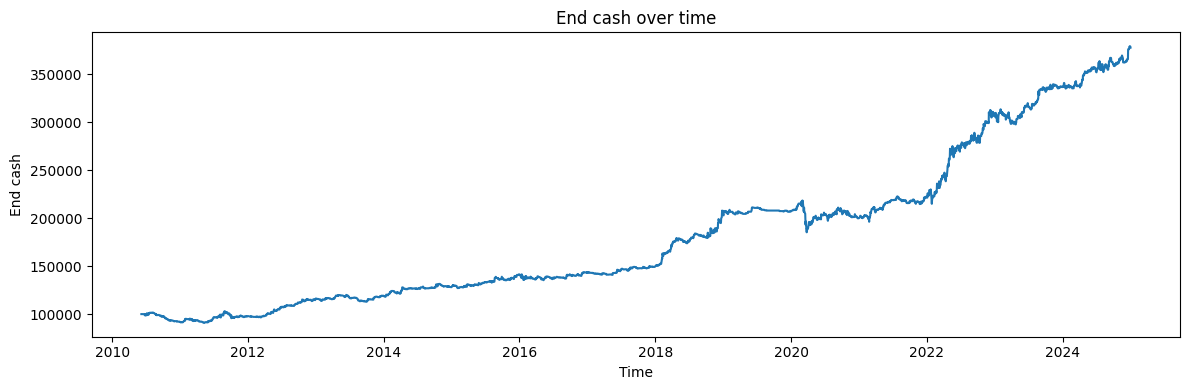

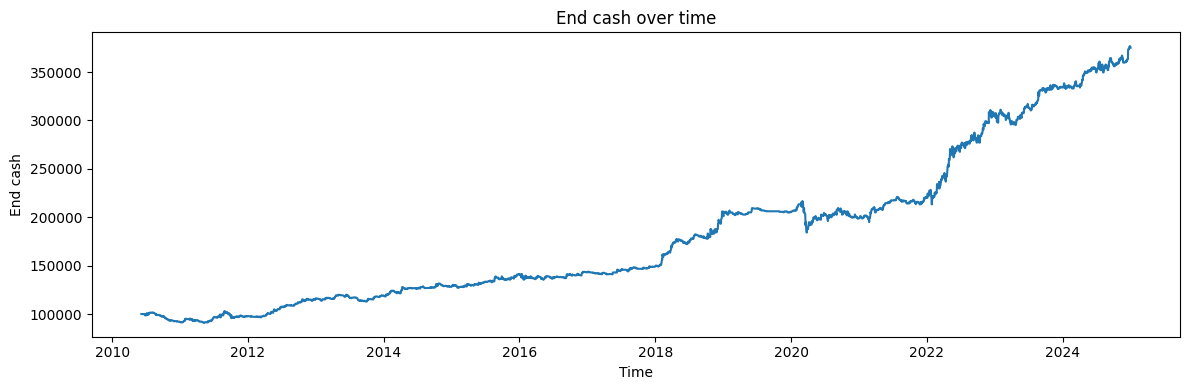

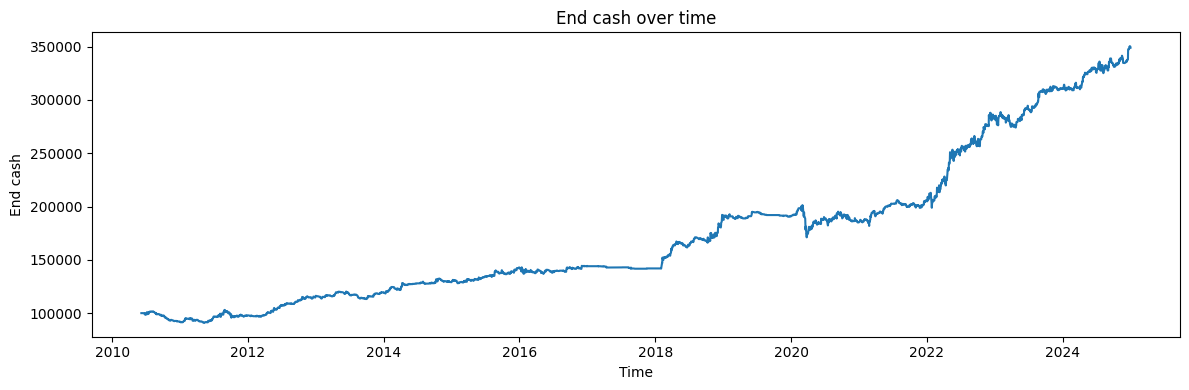

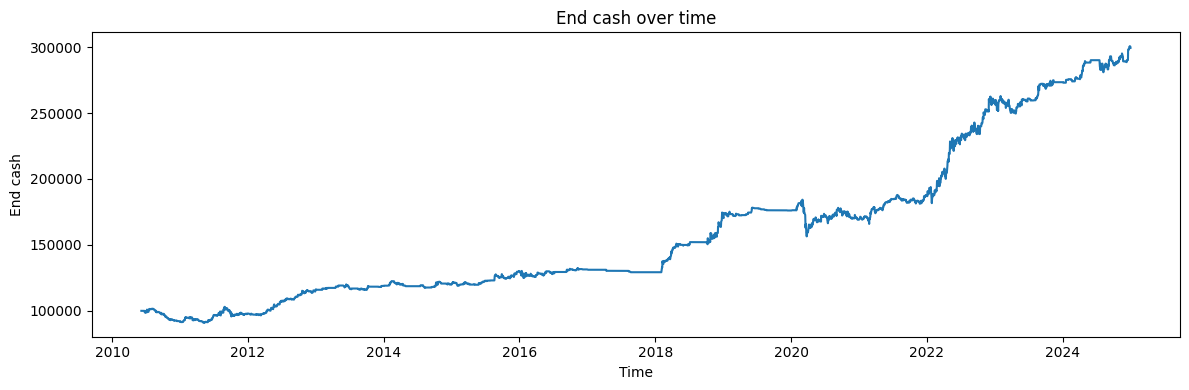

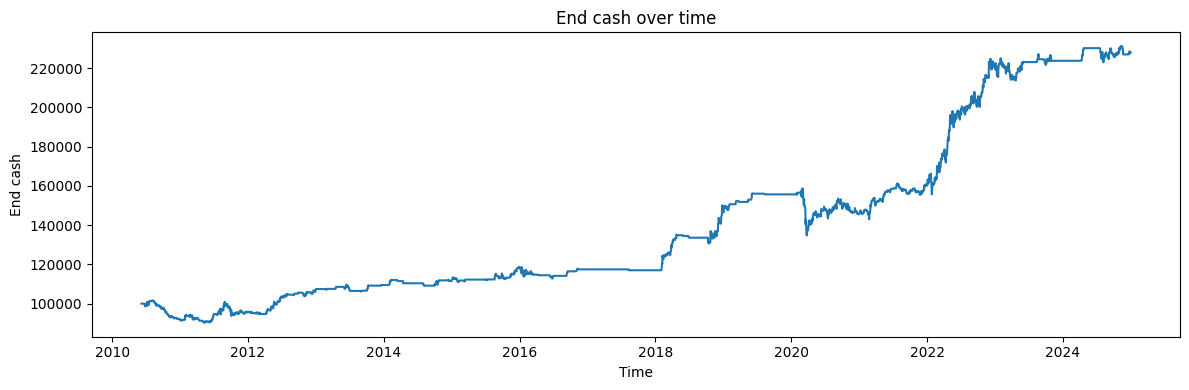

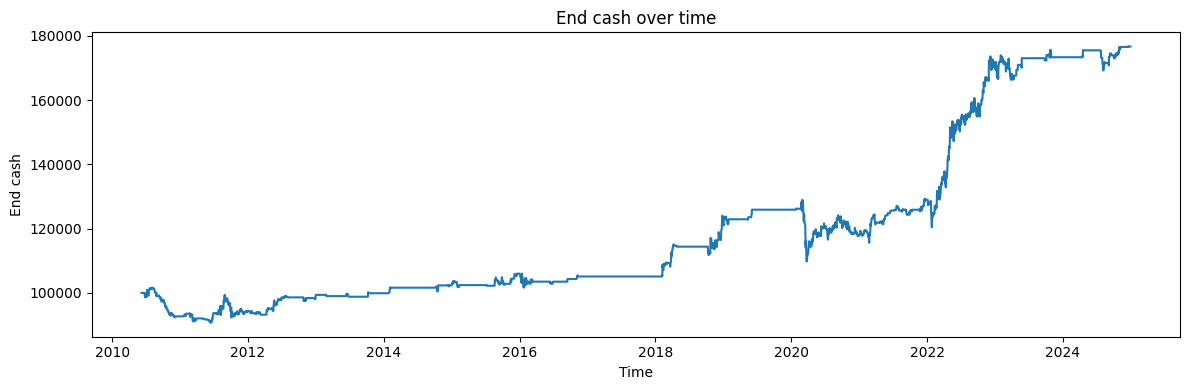

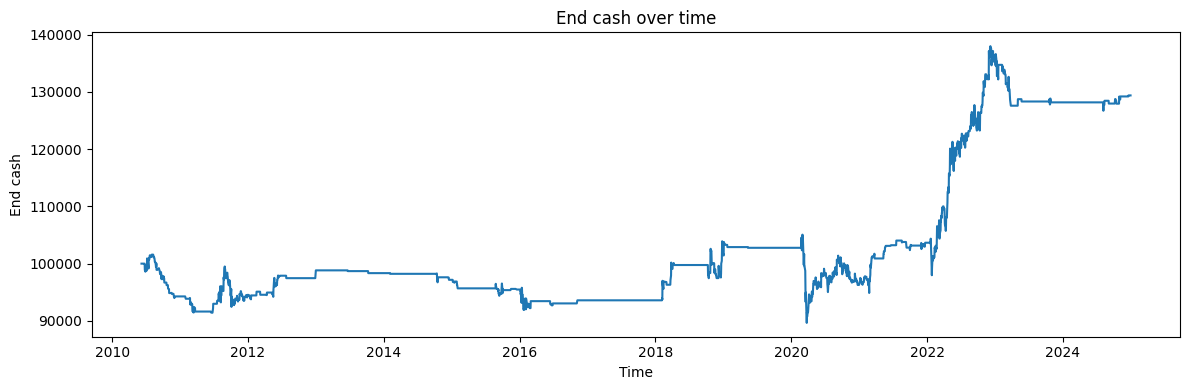

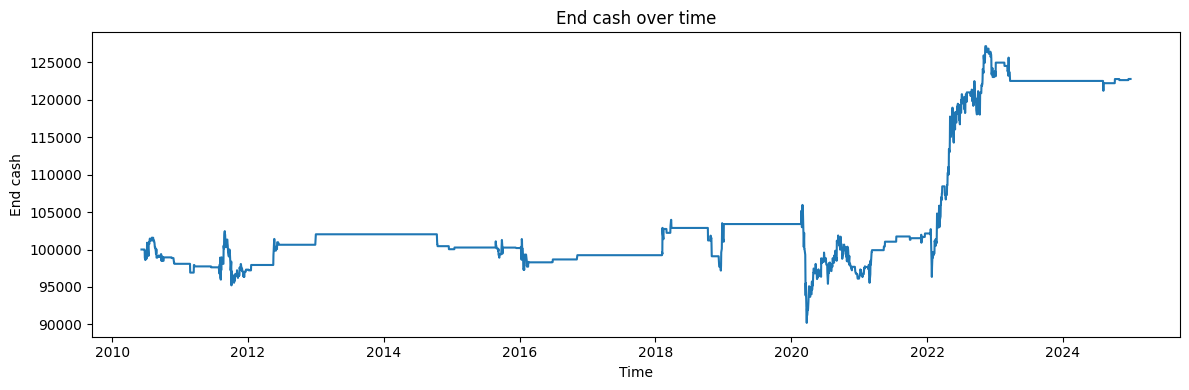

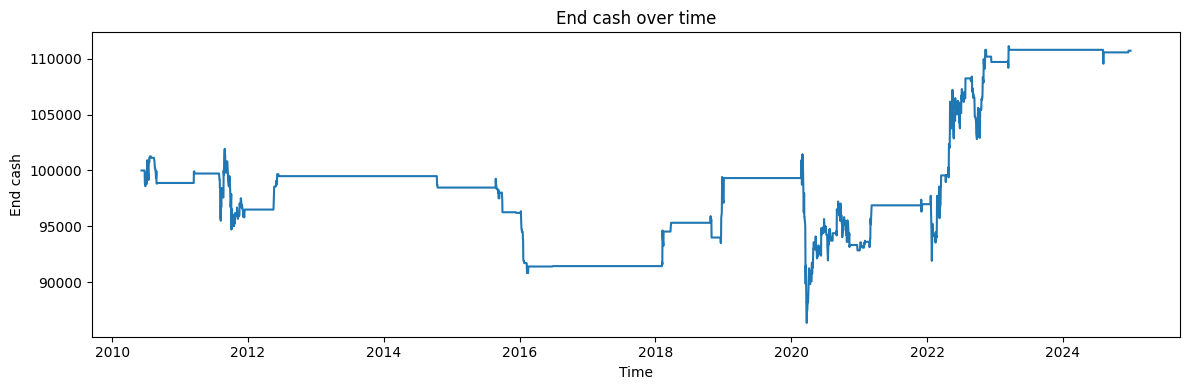

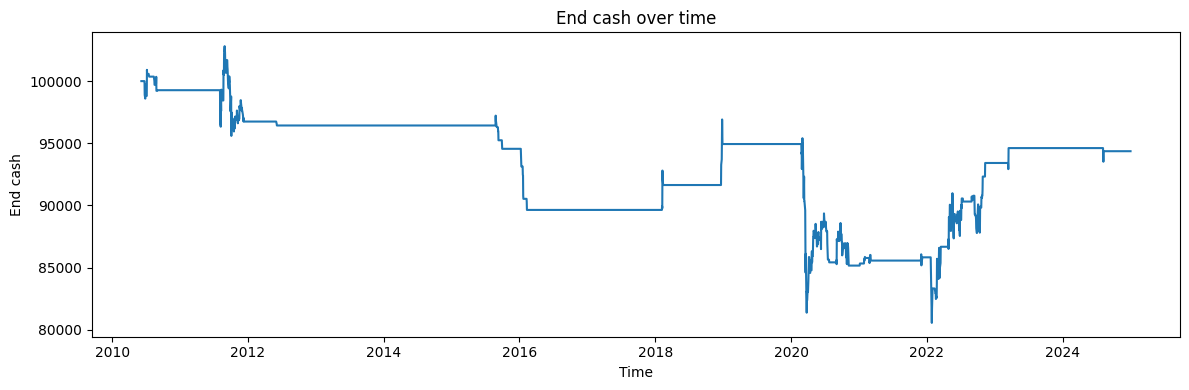

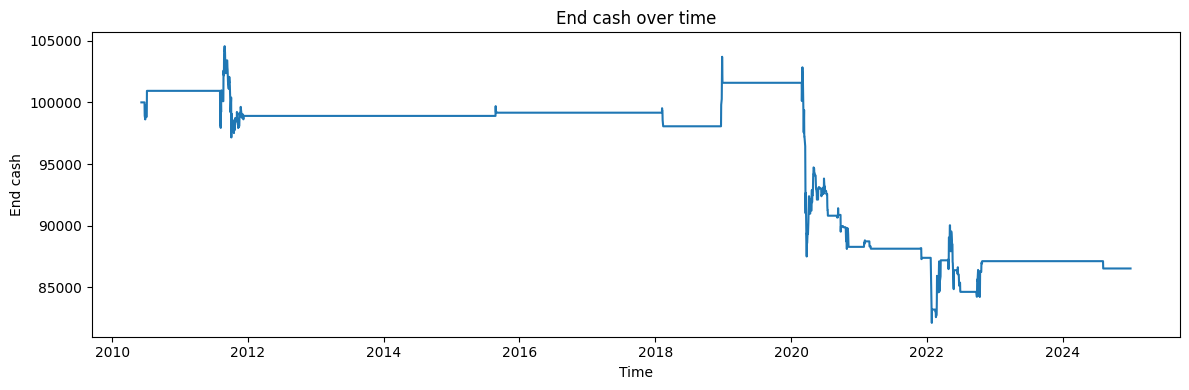

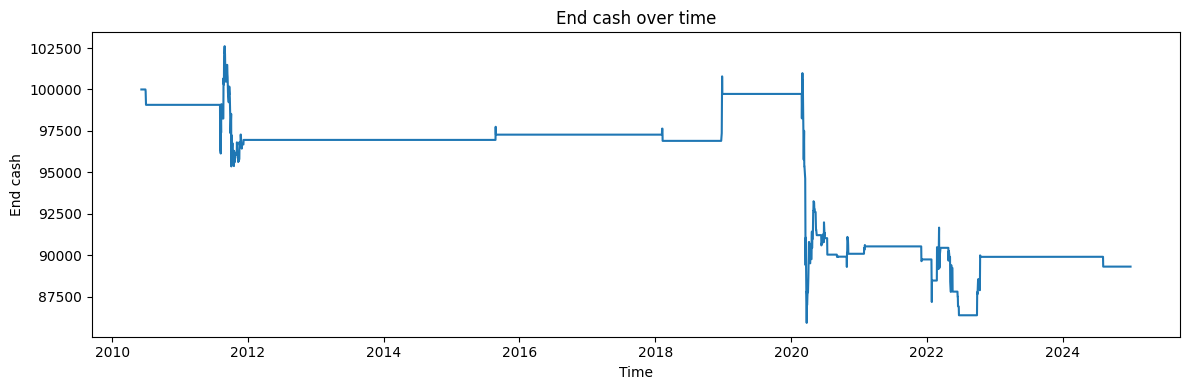

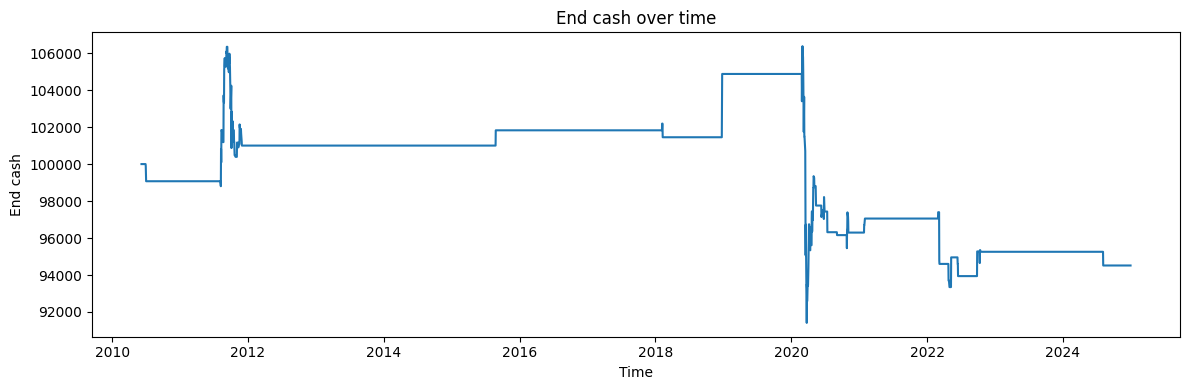

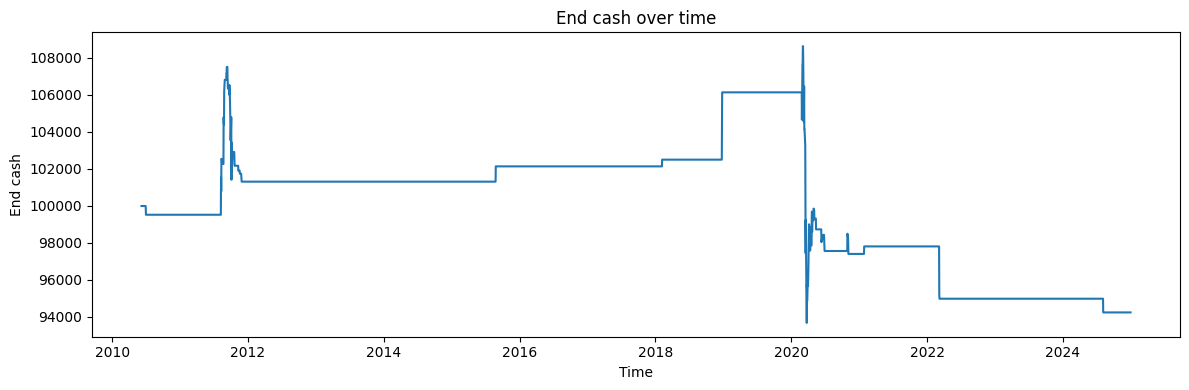

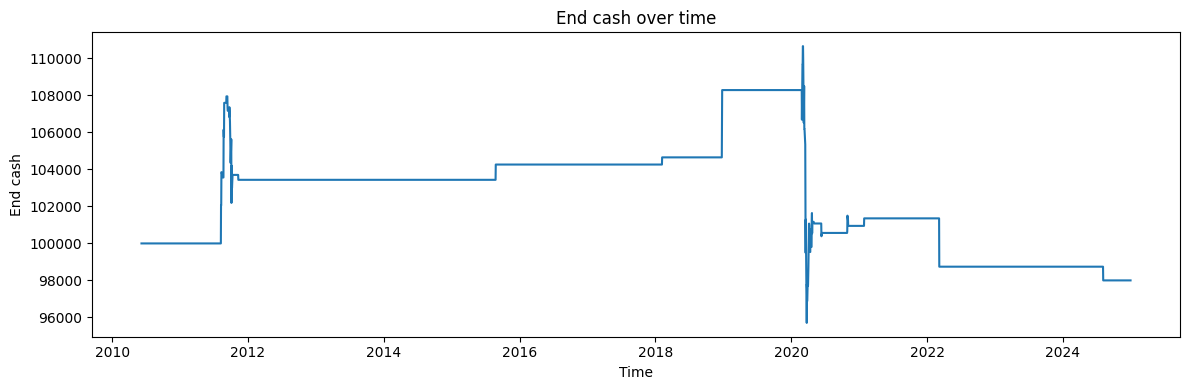

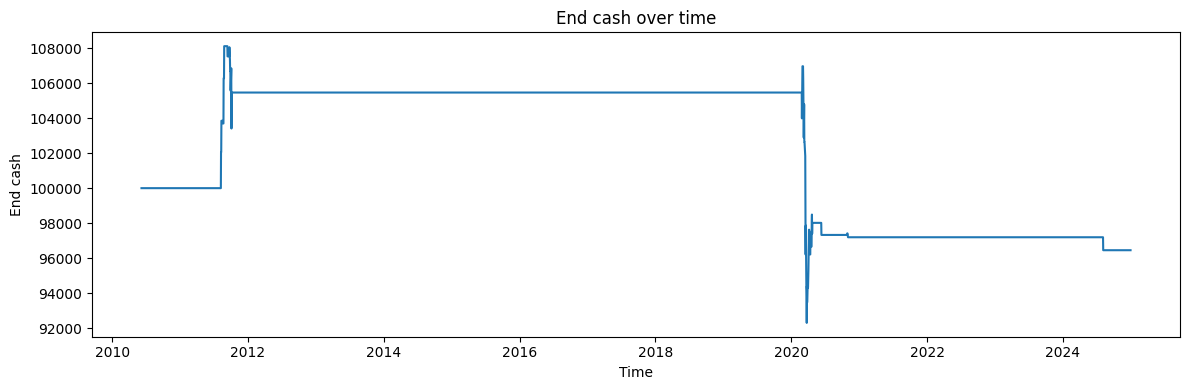

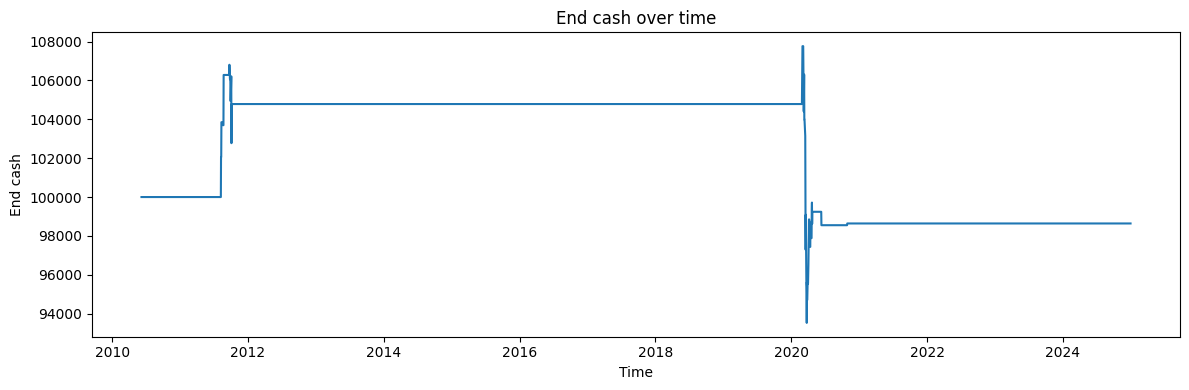

In [38]:
for i in [0, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]:
    results = backtest_with_hyperparameters(0.5, 0.002, 14, 14, 0.2, i)
    print(f"Results for VIX treshold: {i}")
    print(evaluate_strategy(results))
    s = results.copy()
    
    # If you have a Time column, make it the datetime index
    if "Time" in s.columns:
        s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
        s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

    # Plot end_cash over time
    plt.figure(figsize=(12,4))
    plt.plot(s.date, s["end_cash"].astype(float))
    # plt.plot(sp_df['SP500'].astype(float))
    plt.plot
    plt.title("End cash over time")
    plt.xlabel("Time")
    plt.ylabel("End cash")
    plt.tight_layout()
    plt.show()

# Volatility upper threshold

In [16]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization,
                                  sigma_leverage_period, sigma_leverage_bound, sigma_target, VIX_treshold):

    # ---------- Load & prepare intraday data ----------
    df = pd.read_csv('/data/workspace_files/nasdaq.csv',
                     usecols=['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum'])

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST) and build hour/day on NY time
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date        # <-- keep as datetime.date (DO NOT stringify)

    # US RTH 09:30–16:00 ET
    import datetime as dt
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Order & mid price
    df = df.sort_values(['symbol', 'hour', 'day'])
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])

    # Opening price per symbol-day
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')

    # Settle and previous settle (per symbol/day)
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
          .groupby(['symbol','day'])['price'].last()
          .rename('settl_price')
    )
    prev_settle = (
        daily_settle.groupby(level='symbol').shift(1).rename('settl_price_previous')
    )
    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])

    # Intraday move vs open
    df['move'] = np.where(
        df['open_price'] > 0,
        np.abs(df['price'] / df['open_price'] - 1),
        np.nan
    )

    # Rolling mean of move by (symbol, hour)
    win = int(sigma_leverage_bound) if sigma_leverage_bound is not None else 1
    if win < 1:
        win = 1
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
          .transform(lambda x: x.rolling(win, min_periods=win).mean())
    )

    # Bands
    df['upper_bound'] = df[['open_price','settl_price_previous']].max(axis=1) * (1 + coef_sigma * df['sigma_observed']) \
                        + percentage_penalization * df['open_price']
    df['lower_bound'] = df[['open_price','settl_price_previous']].min(axis=1) * (1 - coef_sigma * df['sigma_observed']) \
                        - percentage_penalization * df['open_price']

    # End-of-day return
    df['return'] = df['settl_price'] / df['open_price'] - 1

    # 14D rolling std of returns per symbol
    daily = (df.sort_values(['symbol','day'])
               .groupby(['symbol','day'], as_index=False)['return'].last())
    daily['ret_std_14d'] = (
        daily.groupby('symbol')['return']
             .transform(lambda s: s.rolling(int(sigma_leverage_period), min_periods=int(sigma_leverage_period)).std())
    )
    df = df.merge(daily[['symbol','day','ret_std_14d']], on=['symbol','day'], how='left')

    df = df.sort_values(['symbol', 'day', 'hour'])

    # ---------- Load & merge VIX (daily) ----------
    vol_df = pd.read_csv('/data/workspace_files/VIX_History.csv', usecols=['DATE', 'CLOSE'])
    vol_df = vol_df.rename(columns={'DATE':'day', 'CLOSE':'VIX'})

    # Parse to timezone-naive dates and shift by one day (use yesterday's VIX)
    vol_df['day'] = pd.to_datetime(vol_df['day'], format='%m/%d/%Y', errors='coerce').dt.date
    vol_df = vol_df.dropna(subset=['day'])
    vol_df = vol_df.sort_values('day')
    vol_df['VIX'] = pd.to_numeric(vol_df['VIX'], errors='coerce').shift(1)

    # Ensure unique per-day (take last if duplicates)
    vol_df = vol_df.groupby('day', as_index=False).last()

    # Some trading days may not have VIX (holidays). Build a calendar from df['day'] and ffill VIX.
    all_days = pd.DataFrame({'day': sorted(df['day'].unique())})
    vol_df = all_days.merge(vol_df, on='day', how='left').sort_values('day')
    vol_df['VIX'] = vol_df['VIX'].ffill()

    # Merge back (left join; broadcasts daily VIX to intraday rows)
    df = df.merge(vol_df, on='day', how='left')

    # ---------- Run backtest ----------
    results = backtest(df, 1, sigma_target, VIX_treshold)
    return results

In [17]:
def backtest(backtest_df, rank_to_expiry, sigma_target, VIX_treshold, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash, sigma_target, VIX_treshold)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

# backtest(df, rank_to_expiry = 1, sigma_target=0.02, initial_cash=100_000)

In [18]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash, sigma_target, VIX_treshold):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
                               .sort_values('Time')
                               .copy())
    backtest_df = backtest_df.sort_values('hour')

    # if backtest_df['VIX'].iloc[0] >= VIX_treshold:
    #     return initial_cash

    # --- basic guards ---
    if backtest_df.empty:
        return initial_cash

    # Pull scalars safely
    ret_std = backtest_df['ret_std_14d'].iloc[0]
    open_price = backtest_df['open_price'].iloc[0]

    # Validate inputs used in floor(); avoid NaN / inf / nonpositive std or price
    if (not np.isfinite(ret_std)) or (ret_std <= 0) or (not np.isfinite(open_price)) or (open_price <= 0):
        total_shares_to_hold = 0
    else:
        lev = 1  # cap leverage at 4x
        sizing = initial_cash * lev / open_price
        total_shares_to_hold = int(np.floor(sizing)) if np.isfinite(sizing) and sizing > 0 else 0

    # Extract arrays
    bid_list     = backtest_df['bid_px_00'].to_numpy()
    ask_list     = backtest_df['ask_px_00'].to_numpy()
    upper_bound  = backtest_df['upper_bound'].to_numpy()
    lower_bound  = backtest_df['lower_bound'].to_numpy()
    vwap_list    = backtest_df['vwap_cum'].to_numpy()
    hour         = backtest_df['hour'].to_numpy()
    price_list   = backtest_df['price'].to_numpy()

    # Length / NaN checks
    n = len(bid_list)
    if not (len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound) == len(price_list) == n) or n == 0:
        return initial_cash

    # IMPORTANT: your previous NaN check added arrays together (elementwise sum).
    # Do proper per-array NaN checks:
    if (np.isnan(bid_list).any() or np.isnan(ask_list).any() or
        np.isnan(vwap_list).any() or np.isnan(upper_bound).any() or
        np.isnan(lower_bound).any() or np.isnan(price_list).any()):
        return initial_cash

    position = 0
    cash = float(initial_cash)



    for i in range(1, len(price_list) - 1):
        if price_list[i] > max(upper_bound[i], vwap_list[i]):
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * price_list[i] * 1.00001
                # print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] < min(vwap_list[i], lower_bound[i]):
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * price_list[i] * 0.99999
                # print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] >= min(vwap_list[i], lower_bound[i]) and max(upper_bound[i], vwap_list[i]) >= ask_list[i]:
            # we must close our position
            if position > 0: # we are long so we need to sell
                initial_cash += position * price_list[i] * 0.99999
                # print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
                position = 0
            elif position < 0: # we are short so we need to buy
                initial_cash -= abs(position) * price_list[i] * 1.00001
                # print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
                position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * price_list[-1] * 0.99999
        position = 0

    elif position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * price_list[-1] * 1.00001
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

In [19]:
results = backtest_with_hyperparameters(0.5, 0.002, 14, 14, 0.2, np.inf)
results

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 0 
 2010-06-07 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 1 
 2010-06-08 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 2 
 2010-06-09 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 3 
 2010-06-10 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 4 
 2010-06-11 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3738 
 2024-12-24 00:00:00-05:00 
 375872.516755 
 378089.918236 
 2217.401481 
 0.005899 
 True 
 
 
 3739 
 2024-12-26 00:00:00-05:00 
 378089.918236 
 378089.918236 
 0.000000 
 0.000000 
 False 
 
 
 3740 
 2024-12-27 00:00:00-05:00 
 378089.918236 
 379093.073425 
 1003.155189 
 0.002653 
 True 
 
 
 3741 
 2024-12-30 00:00:00-05:00 
 379093.073425 
 378720.321267 
 -372.752158 
 -0.000983 
 True 
 
 
 3742 
 2024-12-31 00:00:00-05:00 
 378720.321267 
 377592.755574 
 -1127.565694 
 -0.002977 
 True 
 
 
 
 3743 rows × 6 columns

In [20]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [21]:
evaluate_strategy(results)

{'total_return': 2.77592755573733,
 'irr_annual': 0.09357483221743235,
 'vol_annual': 0.08155040941442078,
 'sharpe': 1.1376730719827486,
 'hit_ratio': 0.4264705882352941,
 'mdd': -0.1516056300345067,
 'n_days': 3743,
 'n_traded_days': 2312}

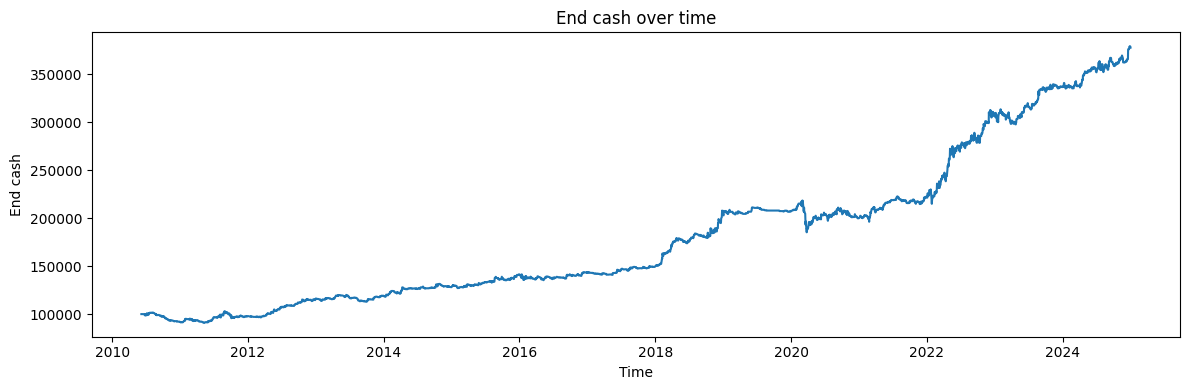

In [11]:
s = results.copy()

sp_df = pd.read_csv("/data/workspace_files/SP500.csv")
sp_df['SP500'] = 189095.59434874536 * sp_df['SP500'] / 1938.76
sp_df

# If you have a Time column, make it the datetime index
if "Time" in s.columns:
    s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
    s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

if "observation_date" in sp_df.columns:
    sp_df["observation_date"] = pd.to_datetime(sp_df["observation_date"], errors="coerce")
    sp_df = sp_df.dropna(subset=["observation_date"]).sort_values("observation_date").set_index("observation_date")

# Plot end_cash over time
plt.figure(figsize=(12,4))
plt.plot(s.date, s["end_cash"].astype(float))
# plt.plot(sp_df['SP500'].astype(float))
plt.plot
plt.title("End cash over time")
plt.xlabel("Time")
plt.ylabel("End cash")
plt.tight_layout()
plt.show()

Results for VIX treshold: 0
{'total_return': 0.0, 'irr_annual': 0.0, 'vol_annual': 0.0, 'sharpe': nan, 'hit_ratio': nan, 'mdd': 0.0, 'n_days': 3743, 'n_traded_days': 0}
Results for VIX treshold: 10
{'total_return': 0.009614274449999627, 'irr_annual': 0.0006444032529375754, 'vol_annual': 0.0026903869968499636, 'sharpe': 0.24078805463376787, 'hit_ratio': 0.5909090909090909, 'mdd': -0.006955782871886653, 'n_days': 3743, 'n_traded_days': 22}
Results for VIX treshold: 12
{'total_return': 0.08343621469999829, 'irr_annual': 0.005409903696991236, 'vol_annual': 0.012280840499237132, 'sharpe': 0.44543487680330096, 'hit_ratio': 0.41496598639455784, 'mdd': -0.016721545897637215, 'n_days': 3743, 'n_traded_days': 147}
Results for VIX treshold: 14
{'total_return': 0.24040276408747907, 'irr_annual': 0.014610082210945396, 'vol_annual': 0.024919798283708126, 'sharpe': 0.5944498791089837, 'hit_ratio': 0.40429338103756707, 'mdd': -0.03687664136904994, 'n_days': 3743, 'n_traded_days': 559}
Results for VIX 

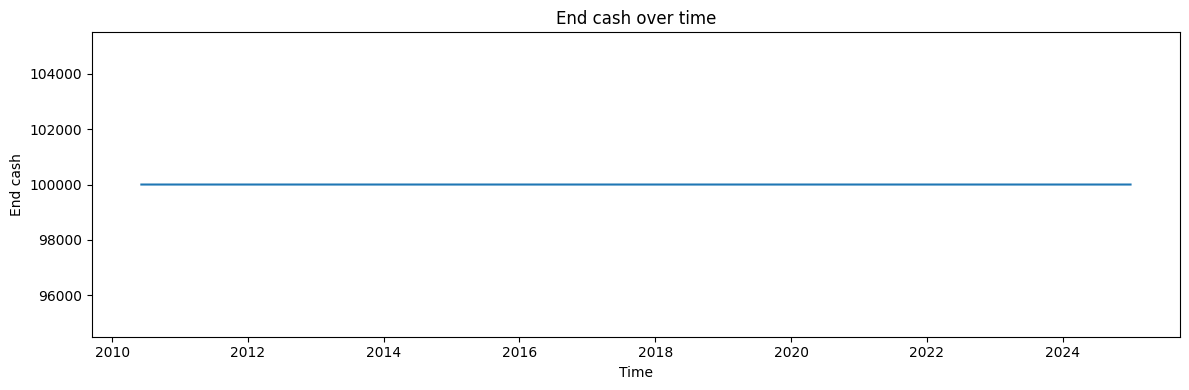

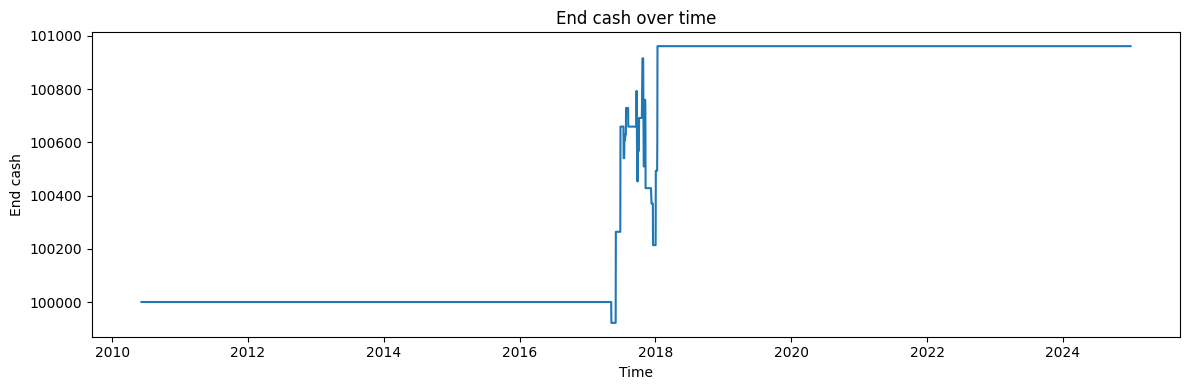

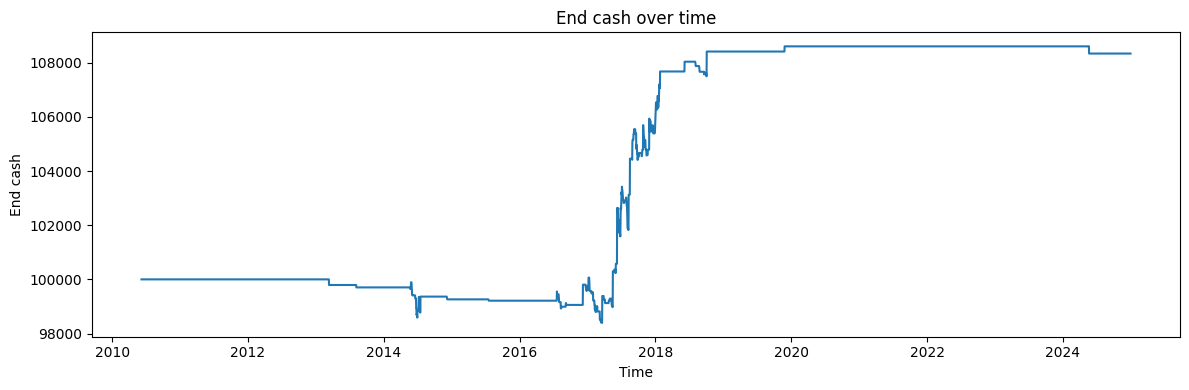

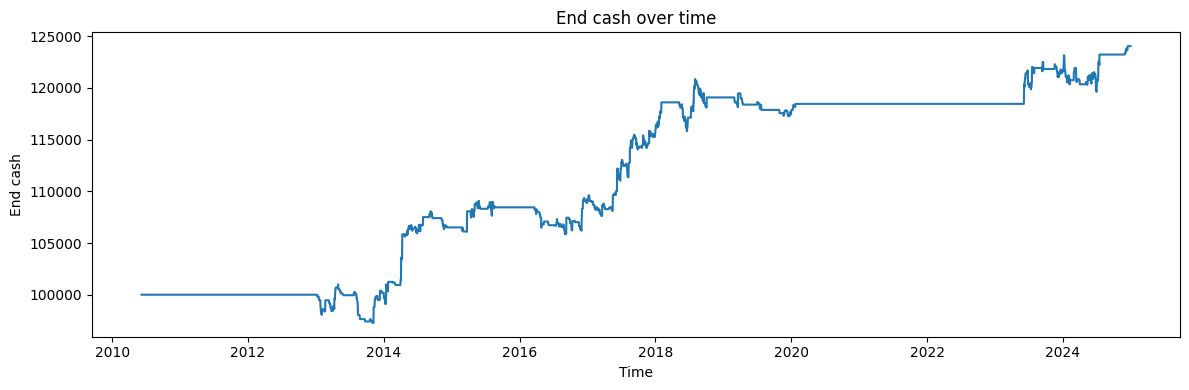

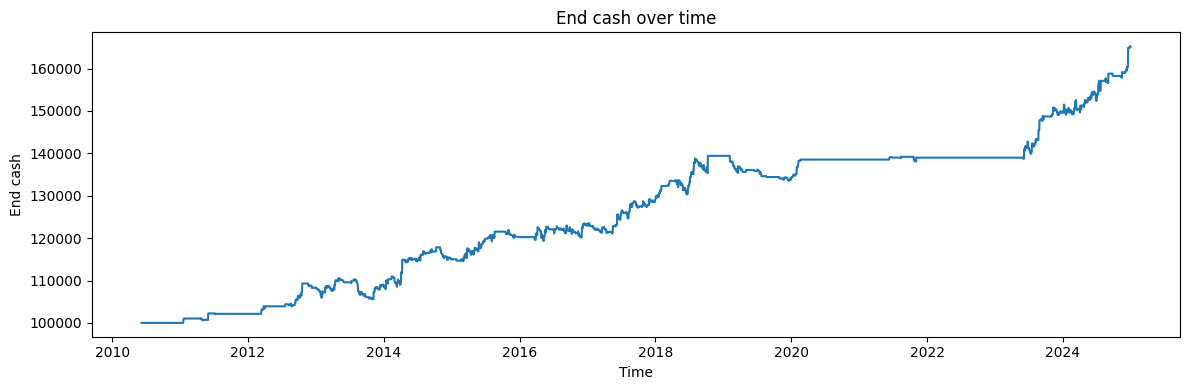

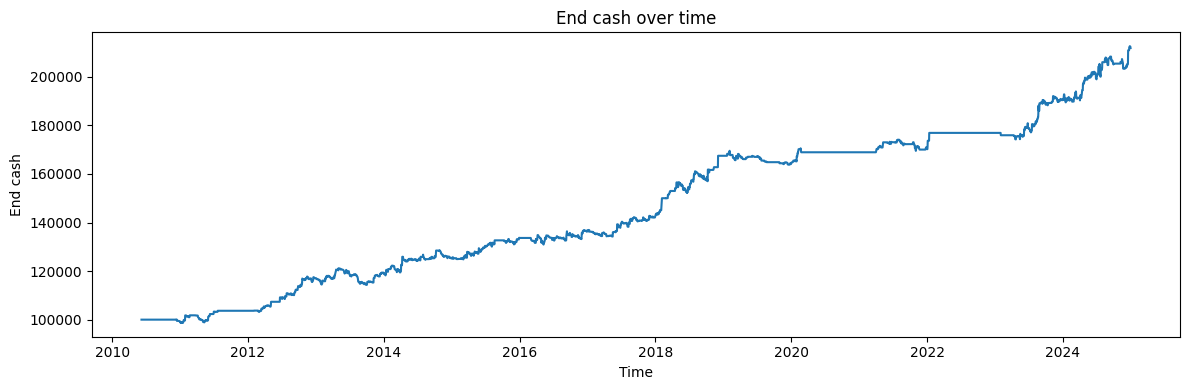

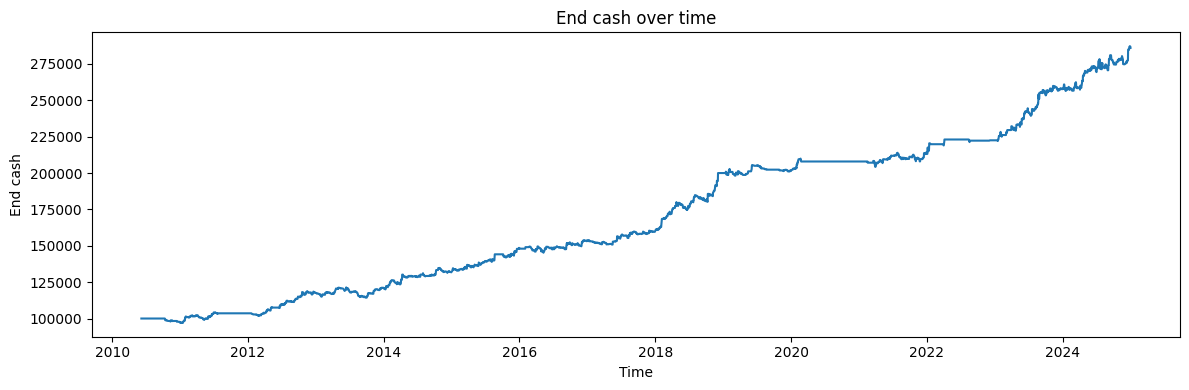

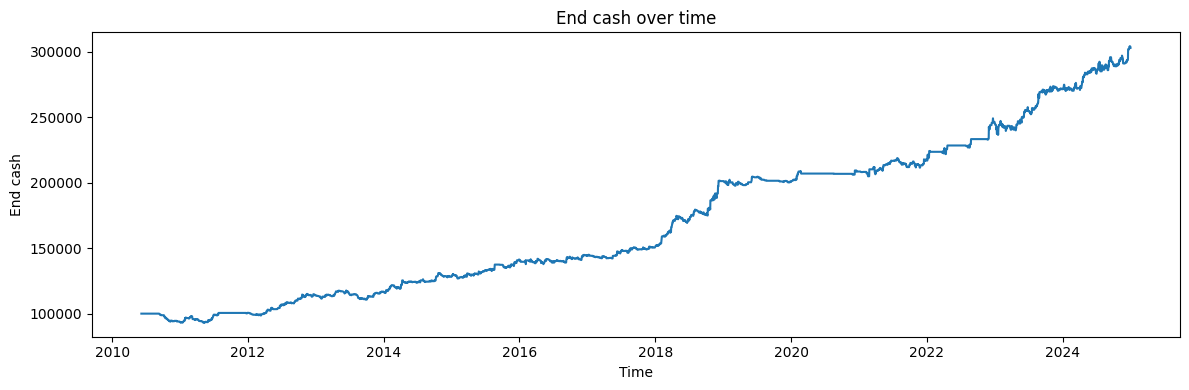

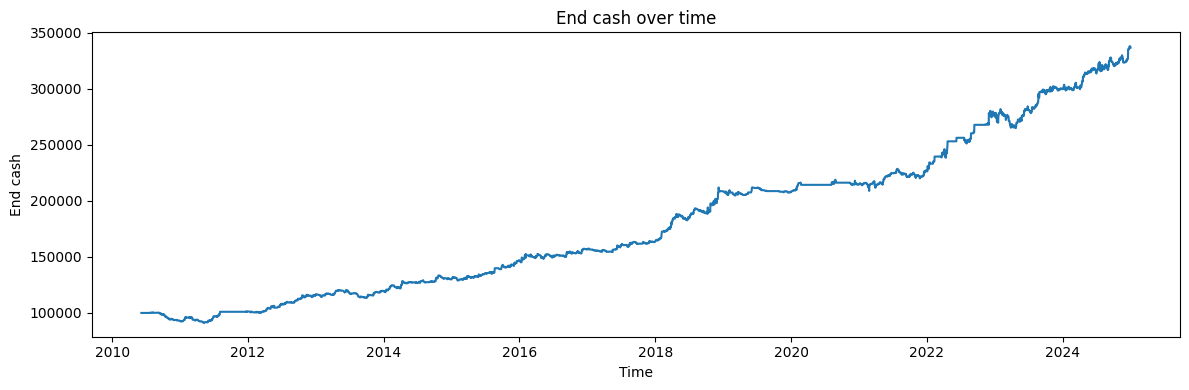

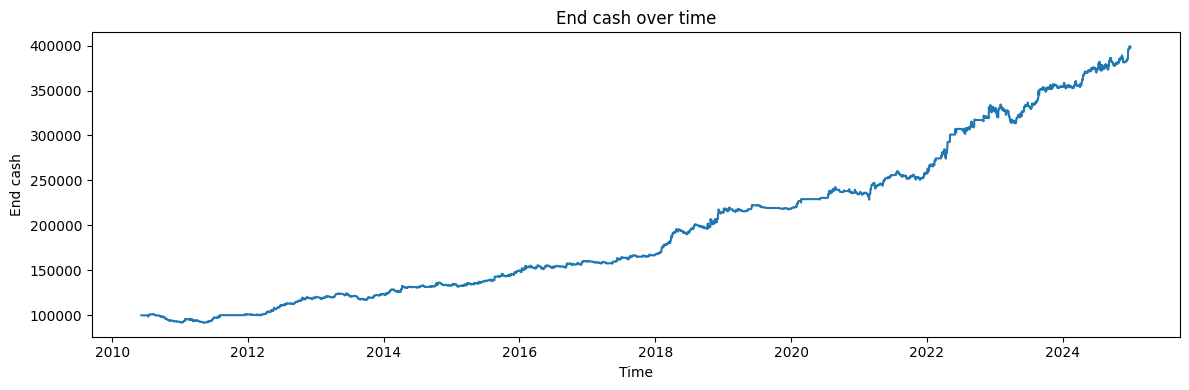

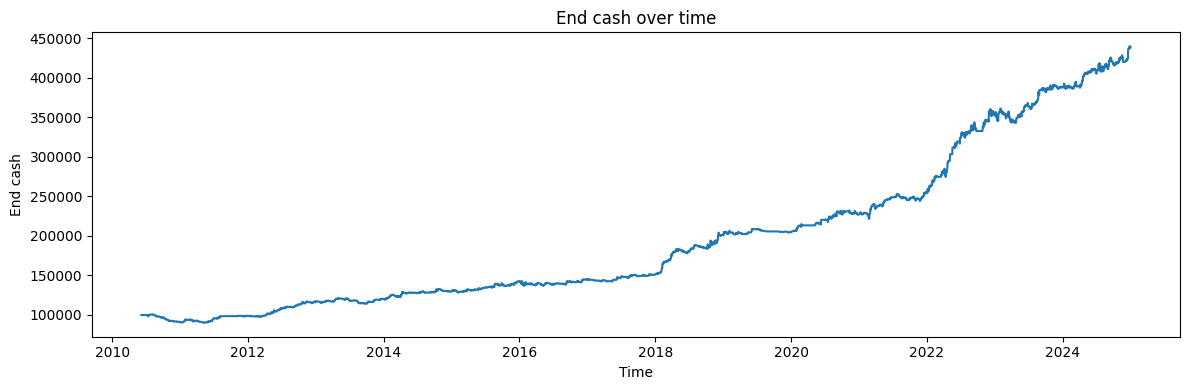

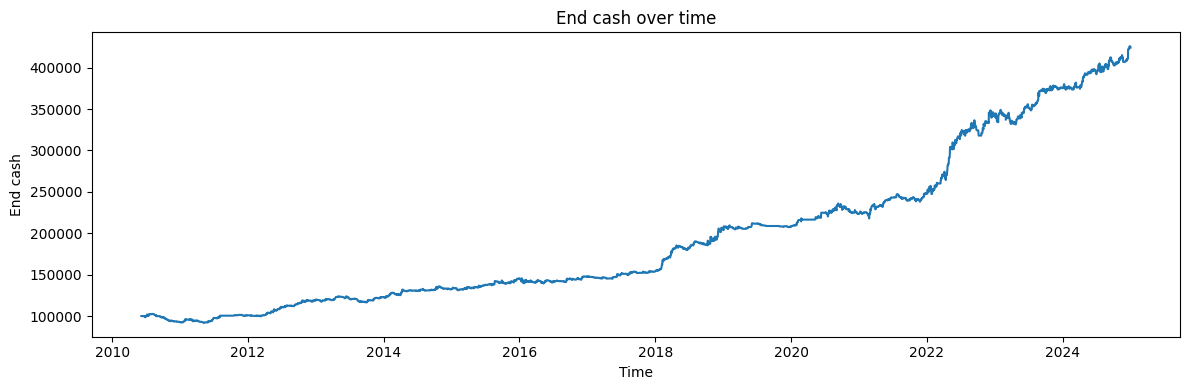

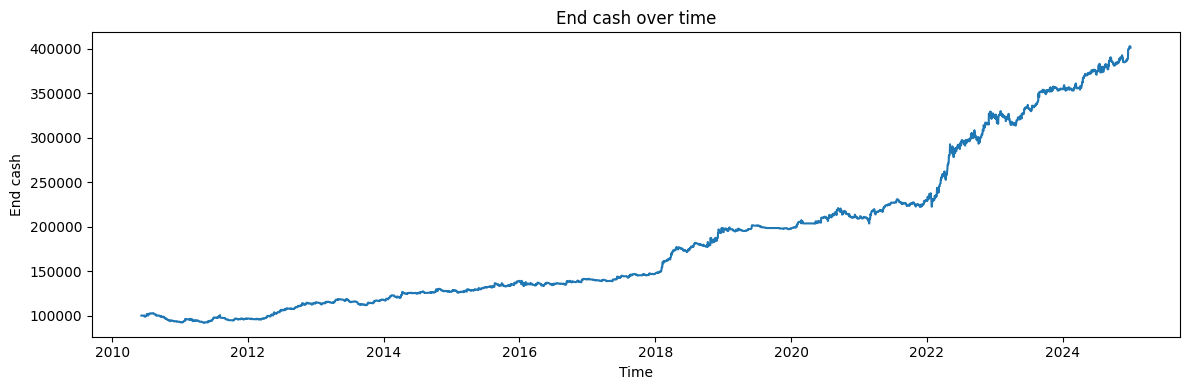

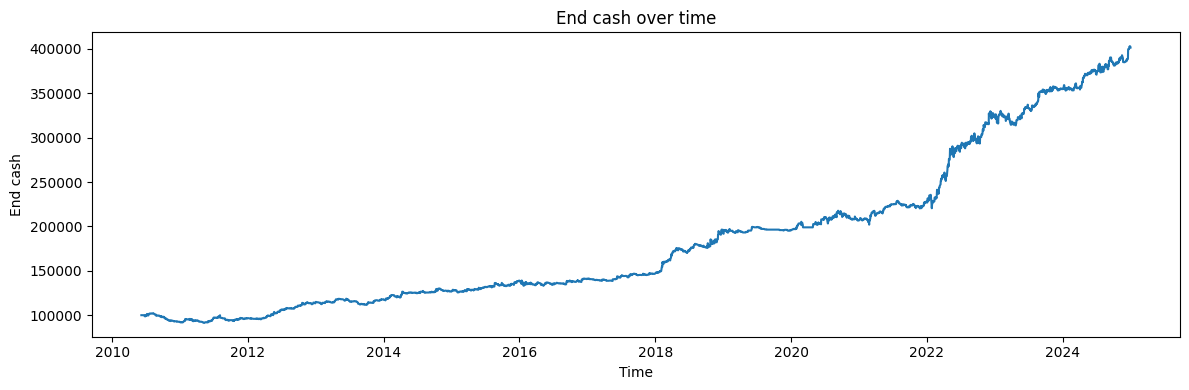

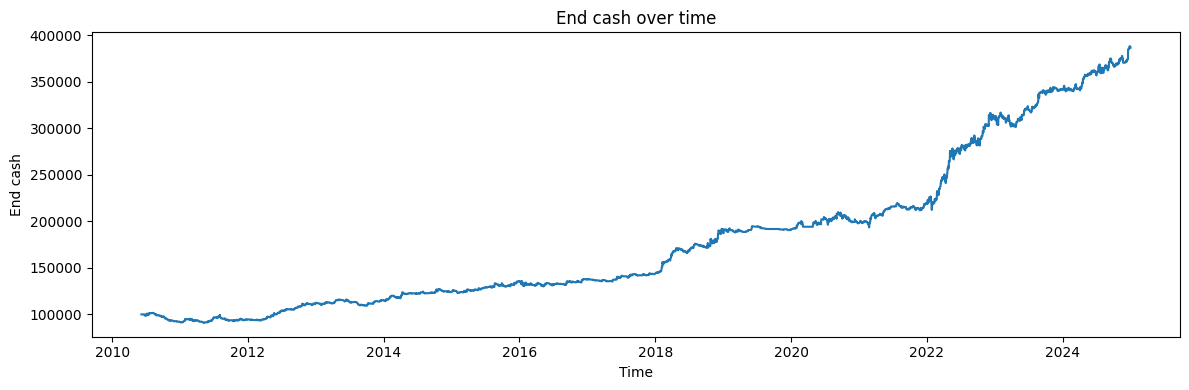

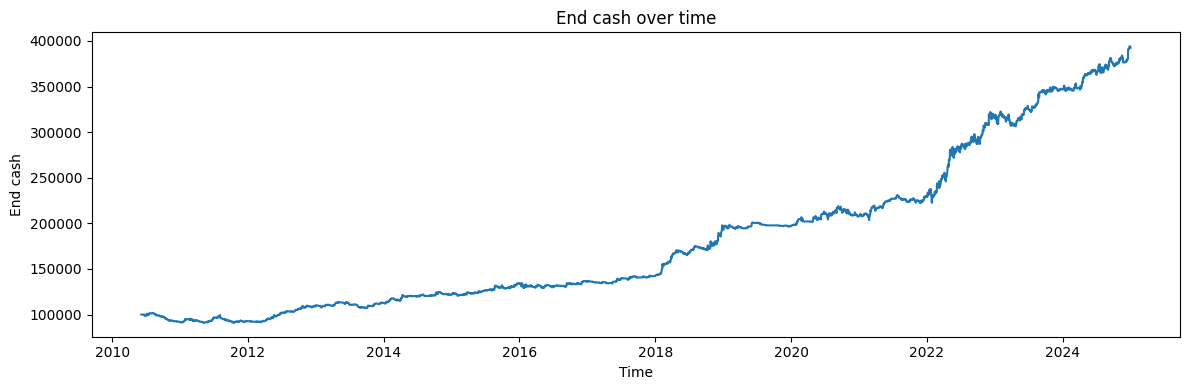

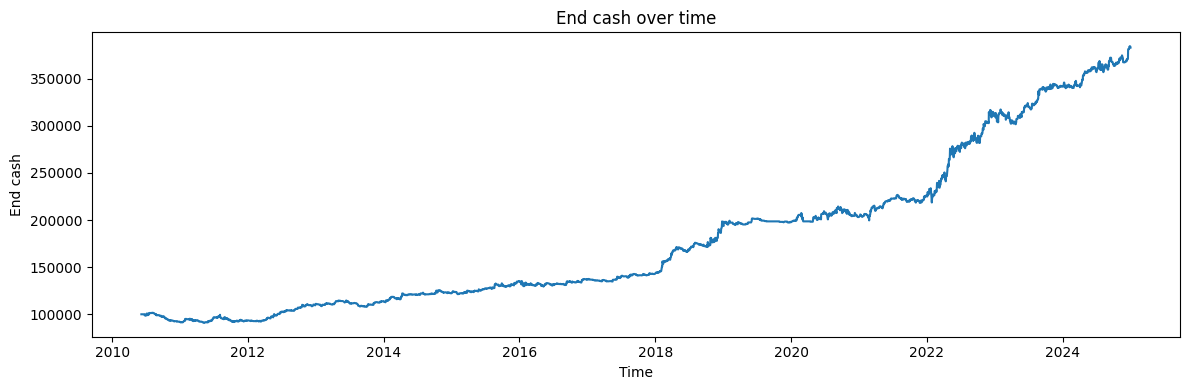

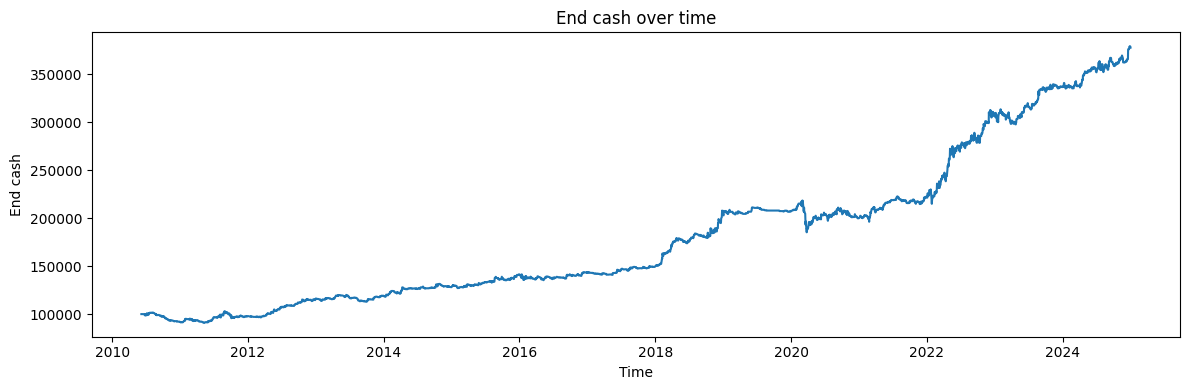

In [12]:
for i in [0, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 1000]:
    results = backtest_with_hyperparameters(0.5, 0.002, 14, 14, 0.2, i)
    print(f"Results for VIX treshold: {i}")
    print(evaluate_strategy(results))
    s = results.copy()
    
    # If you have a Time column, make it the datetime index
    if "Time" in s.columns:
        s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
        s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

    # Plot end_cash over time
    plt.figure(figsize=(12,4))
    plt.plot(s.date, s["end_cash"].astype(float))
    # plt.plot(sp_df['SP500'].astype(float))
    plt.plot
    plt.title("End cash over time")
    plt.xlabel("Time")
    plt.ylabel("End cash")
    plt.tight_layout()
    plt.show()

# Volatility window

In [151]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization,
                                  sigma_leverage_period, sigma_leverage_bound, sigma_target, VIX_treshold_upper, VIX_treshold_lower):

    # ---------- Load & prepare intraday data ----------
    df = pd.read_csv('/data/workspace_files/nasdaq.csv',
                     usecols=['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum'])

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST) and build hour/day on NY time
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date        # <-- keep as datetime.date (DO NOT stringify)

    # US RTH 09:30–16:00 ET
    import datetime as dt
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Order & mid price
    df = df.sort_values(['symbol', 'hour', 'day'])
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])

    # Opening price per symbol-day
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')

    # Settle and previous settle (per symbol/day)
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
          .groupby(['symbol','day'])['price'].last()
          .rename('settl_price')
    )
    prev_settle = (
        daily_settle.groupby(level='symbol').shift(1).rename('settl_price_previous')
    )
    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])

    # Intraday move vs open
    df['move'] = np.where(
        df['open_price'] > 0,
        np.abs(df['price'] / df['open_price'] - 1),
        np.nan
    )

    # Rolling mean of move by (symbol, hour)
    win = int(sigma_leverage_bound) if sigma_leverage_bound is not None else 1
    if win < 1:
        win = 1
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
          .transform(lambda x: x.rolling(win, min_periods=win).mean())
    )

    # Bands
    df['upper_bound'] = df[['open_price','settl_price_previous']].max(axis=1) * (1 + coef_sigma * df['sigma_observed']) \
                        + percentage_penalization * df['open_price']
    df['lower_bound'] = df[['open_price','settl_price_previous']].min(axis=1) * (1 - coef_sigma * df['sigma_observed']) \
                        - percentage_penalization * df['open_price']

    # End-of-day return
    df['return'] = df['settl_price'] / df['open_price'] - 1

    # 14D rolling std of returns per symbol
    daily = (df.sort_values(['symbol','day'])
               .groupby(['symbol','day'], as_index=False)['return'].last())
    daily['ret_std_14d'] = (
        daily.groupby('symbol')['return']
             .transform(lambda s: s.rolling(int(sigma_leverage_period), min_periods=int(sigma_leverage_period)).std())
    )
    df = df.merge(daily[['symbol','day','ret_std_14d']], on=['symbol','day'], how='left')

    df = df.sort_values(['symbol', 'day', 'hour'])

    # ---------- Load & merge VIX (daily) ----------
    vol_df = pd.read_csv('/data/workspace_files/VIX_History.csv', usecols=['DATE', 'CLOSE'])
    vol_df = vol_df.rename(columns={'DATE':'day', 'CLOSE':'VIX'})

    # Parse to timezone-naive dates and shift by one day (use yesterday's VIX)
    vol_df['day'] = pd.to_datetime(vol_df['day'], format='%m/%d/%Y', errors='coerce').dt.date
    vol_df = vol_df.dropna(subset=['day'])
    vol_df = vol_df.sort_values('day')
    vol_df['VIX'] = pd.to_numeric(vol_df['VIX'], errors='coerce').shift(1)

    # Ensure unique per-day (take last if duplicates)
    vol_df = vol_df.groupby('day', as_index=False).last()

    # Some trading days may not have VIX (holidays). Build a calendar from df['day'] and ffill VIX.
    all_days = pd.DataFrame({'day': sorted(df['day'].unique())})
    vol_df = all_days.merge(vol_df, on='day', how='left').sort_values('day')
    vol_df['VIX'] = vol_df['VIX'].ffill()

    # Merge back (left join; broadcasts daily VIX to intraday rows)
    df = df.merge(vol_df, on='day', how='left')

    # ---------- Run backtest ----------
    results = backtest(df, 1, sigma_target, VIX_treshold_upper, VIX_treshold_lower)
    return results

In [152]:
def backtest(backtest_df, rank_to_expiry, sigma_target, VIX_treshold_upper, VIX_treshold_lower, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash, sigma_target, VIX_treshold_upper, VIX_treshold_lower)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

# backtest(df, rank_to_expiry = 1, sigma_target=0.02, initial_cash=100_000)

In [153]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash, sigma_target, VIX_treshold_upper, VIX_treshold_lower):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
                               .sort_values('Time')
                               .copy())
    backtest_df = backtest_df.sort_values('hour')

    if backtest_df['VIX'].iloc[0] < VIX_treshold_upper:
        return initial_cash
    
    if backtest_df['VIX'].iloc[0] > VIX_treshold_lower:
        return initial_cash

    # --- basic guards ---
    if backtest_df.empty:
        return initial_cash

    # Pull scalars safely
    ret_std = backtest_df['ret_std_14d'].iloc[0]
    open_price = backtest_df['open_price'].iloc[0]

    # Validate inputs used in floor(); avoid NaN / inf / nonpositive std or price
    if (not np.isfinite(ret_std)) or (ret_std <= 0) or (not np.isfinite(open_price)) or (open_price <= 0):
        total_shares_to_hold = 0
    else:
        lev = 1  # cap leverage at 4x
        sizing = initial_cash * lev / open_price
        total_shares_to_hold = int(np.floor(sizing)) if np.isfinite(sizing) and sizing > 0 else 0

    # Extract arrays
    bid_list     = backtest_df['bid_px_00'].to_numpy()
    ask_list     = backtest_df['ask_px_00'].to_numpy()
    upper_bound  = backtest_df['upper_bound'].to_numpy()
    lower_bound  = backtest_df['lower_bound'].to_numpy()
    vwap_list    = backtest_df['vwap_cum'].to_numpy()
    hour         = backtest_df['hour'].to_numpy()
    price_list   = backtest_df['price'].to_numpy()

    # Length / NaN checks
    n = len(bid_list)
    if not (len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound) == len(price_list) == n) or n == 0:
        return initial_cash

    # IMPORTANT: your previous NaN check added arrays together (elementwise sum).
    # Do proper per-array NaN checks:
    if (np.isnan(bid_list).any() or np.isnan(ask_list).any() or
        np.isnan(vwap_list).any() or np.isnan(upper_bound).any() or
        np.isnan(lower_bound).any() or np.isnan(price_list).any()):
        return initial_cash

    position = 0
    cash = float(initial_cash)



    for i in range(1, len(price_list) - 1):
        if price_list[i] > max(upper_bound[i], vwap_list[i]):
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * price_list[i] * 1.00001
                # print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] < min(vwap_list[i], lower_bound[i]):
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * price_list[i] * 0.99999
                # print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] >= min(vwap_list[i], lower_bound[i]) and max(upper_bound[i], vwap_list[i]) >= ask_list[i]:
            # we must close our position
            if position > 0: # we are long so we need to sell
                initial_cash += position * price_list[i] * 0.99999
                # print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
                position = 0
            elif position < 0: # we are short so we need to buy
                initial_cash -= abs(position) * price_list[i] * 1.00001
                # print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
                position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * price_list[-1] * 0.99999
        position = 0

    elif position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * price_list[-1] * 1.00001
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

In [154]:
results = backtest_with_hyperparameters(0.5, 0.002, 14, 14, 0.2, 0, 100)
results

date 
 start_cash 
 end_cash 
 pnl 
 return 
 traded 
 
 
 
 
 0 
 2010-06-07 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 1 
 2010-06-08 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 2 
 2010-06-09 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 3 
 2010-06-10 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 4 
 2010-06-11 00:00:00-04:00 
 100000.000000 
 100000.000000 
 0.000000 
 0.000000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 3738 
 2024-12-24 00:00:00-05:00 
 375872.516755 
 378089.918236 
 2217.401481 
 0.005899 
 True 
 
 
 3739 
 2024-12-26 00:00:00-05:00 
 378089.918236 
 378089.918236 
 0.000000 
 0.000000 
 False 
 
 
 3740 
 2024-12-27 00:00:00-05:00 
 378089.918236 
 379093.073425 
 1003.155189 
 0.002653 
 True 
 
 
 3741 
 2024-12-30 00:00:00-05:00 
 379093.073425 
 378720.321267 
 -372.752158 
 -0.000983 
 True 
 
 
 3742 
 2024-12-31 00:00:00-05:00 
 378720.321267 
 377592.755574 
 -1127.565694 
 -0.002977 
 True 
 
 
 
 3743 rows × 6 columns

In [155]:
evaluate_strategy(results)

{'total_return': 2.77592755573733,
 'irr_annual': 0.09357483221743235,
 'vol_annual': 0.08155040941442078,
 'sharpe': 1.1376730719827486,
 'hit_ratio': 0.4264705882352941,
 'mdd': -0.1516056300345067,
 'n_days': 3743,
 'n_traded_days': 2312}

Results for VIX treshold: (0, 5)
{'total_return': 0.0, 'irr_annual': 0.0, 'vol_annual': 0.0, 'sharpe': nan, 'hit_ratio': nan, 'mdd': 0.0, 'n_days': 3743, 'n_traded_days': 0}
Results for VIX treshold: (5, 10)
{'total_return': 0.0012502379874994585, 'irr_annual': 8.412407976909897e-05, 'vol_annual': 0.0016342753245190166, 'sharpe': 0.05228919834199787, 'hit_ratio': 0.42857142857142855, 'mdd': -0.006999198467319301, 'n_days': 3743, 'n_traded_days': 14}
Results for VIX treshold: (10, 15)
{'total_return': 0.20735934481248353, 'irr_annual': 0.012767370639904962, 'vol_annual': 0.0227086125374846, 'sharpe': 0.5699853590138734, 'hit_ratio': 0.42857142857142855, 'mdd': -0.06500823397629683, 'n_days': 3743, 'n_traded_days': 476}
Results for VIX treshold: (15, 20)
{'total_return': 0.8131469220749734, 'irr_annual': 0.04087643370479754, 'vol_annual': 0.034142229144363226, 'sharpe': 1.1904736308433908, 'hit_ratio': 0.4813614262560778, 'mdd': -0.03698543456793342, 'n_days': 3743, 'n_traded_days': 617}

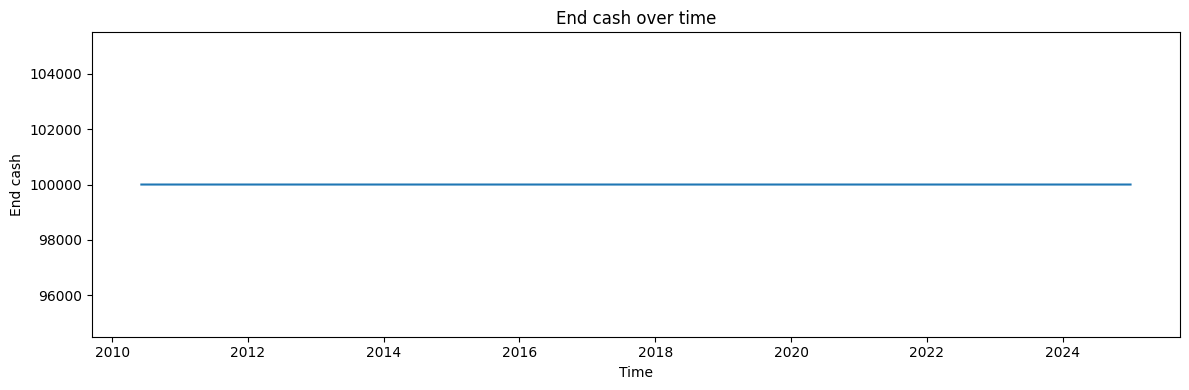

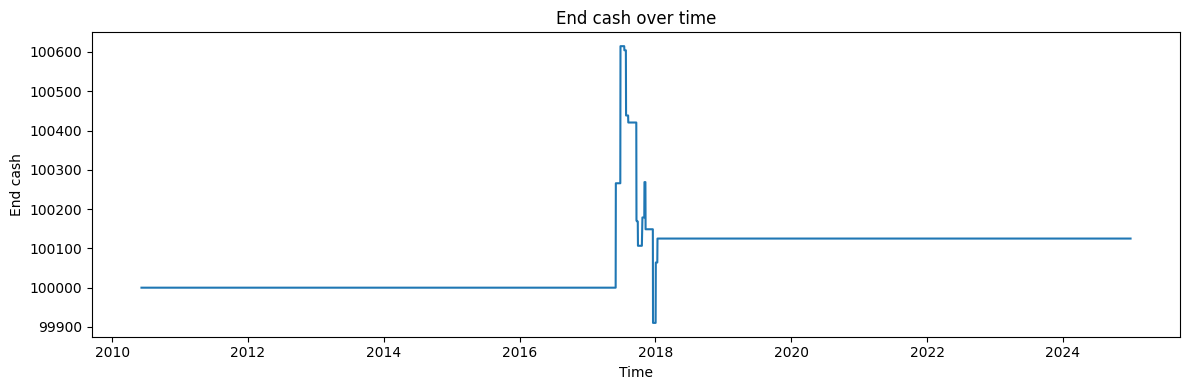

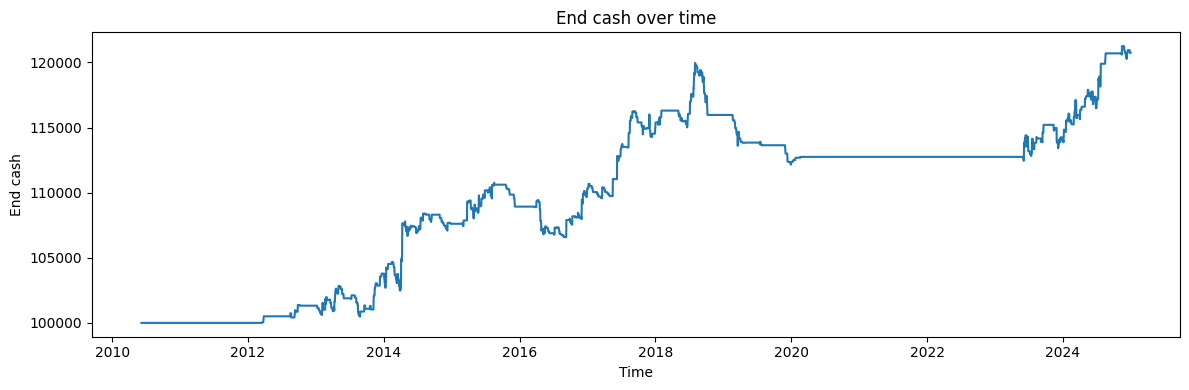

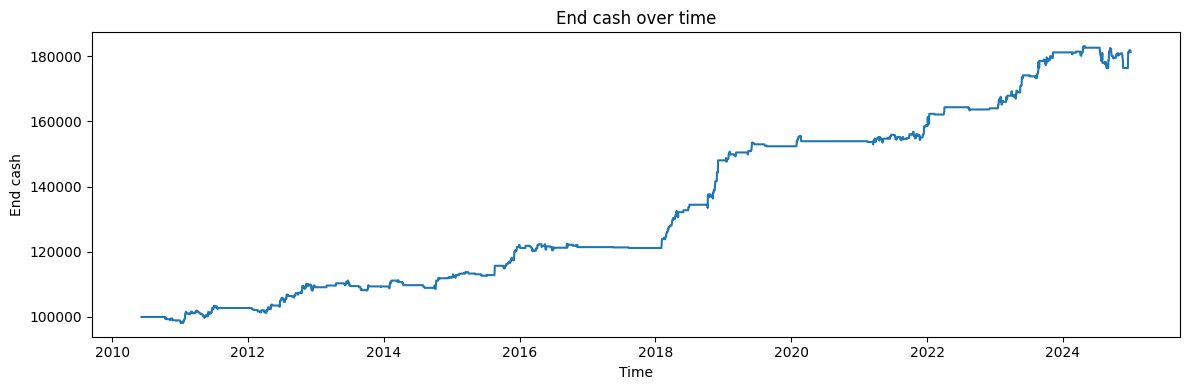

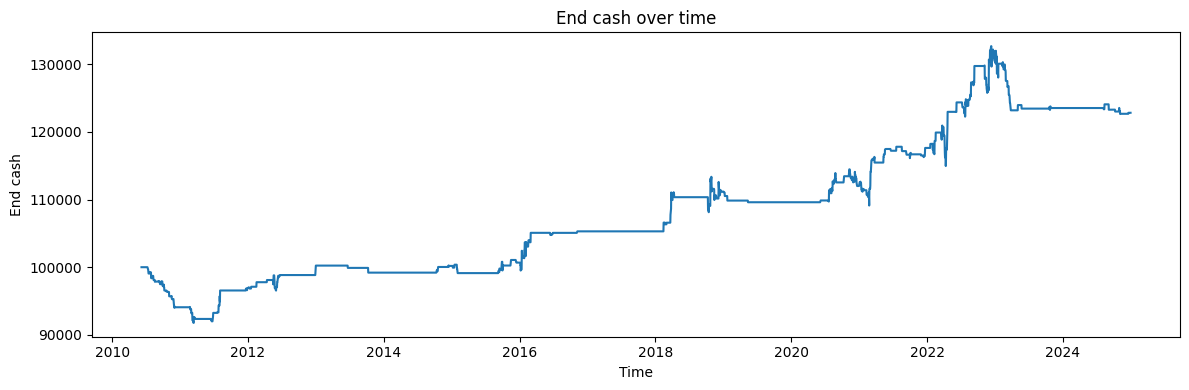

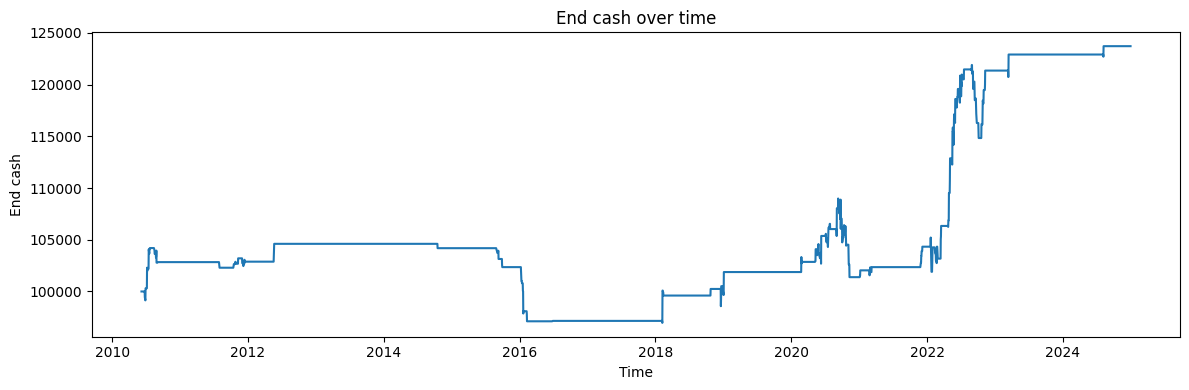

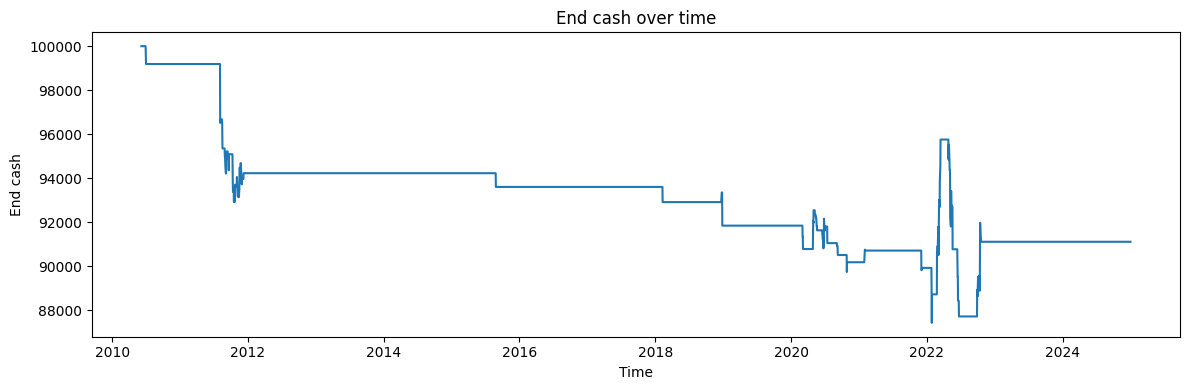

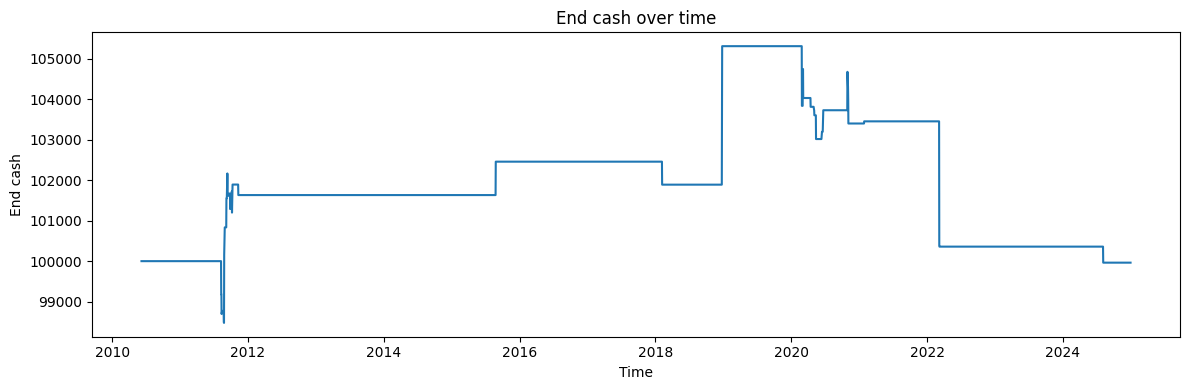

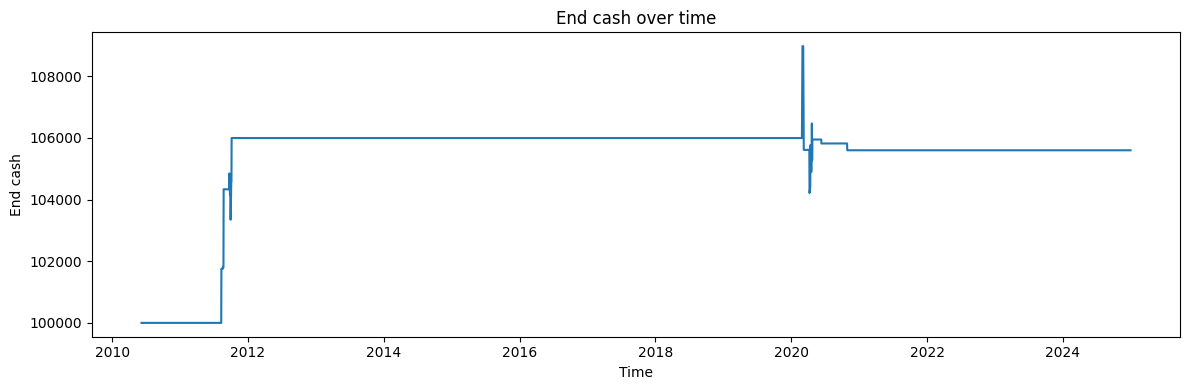

In [156]:
for i in [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30,35), (35, 40), (40, 45)]:
    results = backtest_with_hyperparameters(0.1, 0.005, 10, 14, 0.1, i[0], i[1])
    print(f"Results for VIX treshold: {i}")
    print(evaluate_strategy(results))
    s = results.copy()

    sp_df = pd.read_csv("/data/workspace_files/SP500.csv")
    sp_df['SP500'] = 189095.59434874536 * sp_df['SP500'] / 1938.76
    sp_df

    # If you have a Time column, make it the datetime index
    if "Time" in s.columns:
        s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
        s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

    if "observation_date" in sp_df.columns:
        sp_df["observation_date"] = pd.to_datetime(sp_df["observation_date"], errors="coerce")
        sp_df = sp_df.dropna(subset=["observation_date"]).sort_values("observation_date").set_index("observation_date")

    # Plot end_cash over time
    plt.figure(figsize=(12,4))
    plt.plot(s.date, s["end_cash"].astype(float))
    # plt.plot(sp_df['SP500'].astype(float))
    plt.plot
    plt.title("End cash over time")
    plt.xlabel("Time")
    plt.ylabel("End cash")
    plt.tight_layout()
    plt.show()